In [ ]:
# Healthcare Access Clustering Analysis Following Lanni et al. Methodology
# Analysis of social vulnerability, geographic access, and health needs patterns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, Birch, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway
import time
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42

print("="*80)
print("HEALTHCARE ACCESS CLUSTERING ANALYSIS")
print("Following Lanni et al. (2024) Methodology")
print("="*80)

# ==================================================================================
# STEP 1: CLUSTERING ANALYSIS
# ==================================================================================

print("\n" + "="*50)
print("STEP 1: CLUSTERING ANALYSIS")
print("="*50)

# Load clustering data
print("\nLoading clustering data...")
try:
    cluster_data = pd.read_csv('/content/3factors-2.csv')
    print(f"✓ Loaded clustering data: {cluster_data.shape}")
    print(f"Columns: {list(cluster_data.columns)}")
    print(f"First few rows:")
    print(cluster_data.head())
except FileNotFoundError:
    print("❌ Error: 3factor.csv not found. Please upload the file.")
    exit()

# Prepare clustering variables
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars].copy()

print(f"\nClustering variables:")
for var in clustering_vars:
    print(f"  - {var}: {X[var].value_counts().to_dict()}")

# Standardize data for algorithms that require it
X_scaled = StandardScaler().fit_transform(X)

# Define clustering algorithms to test
algorithms = {
    'K-means': lambda k: KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10),
    'Hierarchical (Ward)': lambda k: AgglomerativeClustering(n_clusters=k, linkage='ward'),
    'Spectral': lambda k: SpectralClustering(n_clusters=k, random_state=RANDOM_STATE),
    'Birch': lambda k: Birch(n_clusters=k),
    'Gaussian Mixture': lambda k: GaussianMixture(n_components=k, random_state=RANDOM_STATE),
    'DBSCAN': lambda k: DBSCAN(eps=0.5, min_samples=5)
}

# Test different numbers of clusters (following Lanni paper approach)
k_range = range(2, 8)  # Test 2-7 clusters
results = []

print("\nTesting clustering algorithms...")
print("Algorithm".ljust(20), "K".ljust(3), "Silhouette".ljust(12), "Davies-Bouldin".ljust(15),
      "Calinski-Harabasz".ljust(18), "Execution Time")
print("-" * 75)

for algo_name, algo_func in algorithms.items():
    if algo_name == 'DBSCAN':
        # DBSCAN doesn't take k parameter
        start_time = time.time()
        try:
            model = algo_func(None)
            if algo_name in ['Spectral']:
                labels = model.fit_predict(X_scaled)
            else:
                labels = model.fit_predict(X)
            end_time = time.time()

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1 and len(set(labels)) > 1:
                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
                exec_time = end_time - start_time

                # Check if DBSCAN results are suspiciously perfect
                if sil_score > 0.99:
                    print(f"{algo_name:<20} {n_clusters:<3} {'EXCLUDED':<12} {'(Perfect)':<15} {'(Likely overfitting)':<18} {exec_time:.3f}")
                    continue

                results.append({
                    'Algorithm': algo_name,
                    'K': n_clusters,
                    'Silhouette_Score': sil_score,
                    'Davies_Bouldin_Index': db_score,
                    'Calinski_Harabasz_Index': ch_score,
                    'Execution_Time': exec_time,
                    'Labels': labels
                })

                print(f"{algo_name:<20} {n_clusters:<3} {sil_score:<12.3f} {db_score:<15.3f} {ch_score:<18.1f} {exec_time:.3f}")
            else:
                print(f"{algo_name:<20} {'N/A':<3} {'No clusters':<12} {'found':<15} {'':<18}")
        except Exception as e:
            print(f"{algo_name:<20} {'ERR':<3} {'Error:':<12} {str(e)[:15]:<15}")
    else:
        # For other algorithms, test different k values
        for k in k_range:
            start_time = time.time()
            try:
                model = algo_func(k)
                if algo_name in ['Spectral']:
                    labels = model.fit_predict(X_scaled)
                else:
                    labels = model.fit_predict(X)
                end_time = time.time()

                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
                exec_time = end_time - start_time

                results.append({
                    'Algorithm': algo_name,
                    'K': k,
                    'Silhouette_Score': sil_score,
                    'Davies_Bouldin_Index': db_score,
                    'Calinski_Harabasz_Index': ch_score,
                    'Execution_Time': exec_time,
                    'Labels': labels
                })

                print(f"{algo_name:<20} {k:<3} {sil_score:<12.3f} {db_score:<15.3f} {ch_score:<18.1f} {exec_time:.3f}")

            except Exception as e:
                print(f"{algo_name:<20} {k:<3} {'Error:':<12} {str(e)[:15]:<15}")

# Convert results to DataFrame and find best model
results_df = pd.DataFrame(results)

print(f"\n\nCLUSTERING VALIDATION RESULTS")
print("="*50)

# Create validation table similar to Lanni paper Table X
validation_table = results_df.groupby('Algorithm').apply(
    lambda x: x.loc[x['Silhouette_Score'].idxmax()]
).reset_index(drop=True)

# Sort by Silhouette Score (higher is better)
validation_table = validation_table.sort_values('Silhouette_Score', ascending=False)

print("\nTable X. Validation results of clustering methods")
print("-" * 90)
print(f"{'Algorithm':<20} {'Silhouette':<12} {'Davies-Bouldin':<15} {'Calinski-Harabasz':<18} {'Execution'}")
print(f"{'':20} {'Score':<12} {'Index':<15} {'Index':<18} {'Time^a'}")
print("-" * 90)

for _, row in validation_table.iterrows():
    print(f"{row['Algorithm']:<20} {row['Silhouette_Score']:<12.3f} {row['Davies_Bouldin_Index']:<15.3f} "
          f"{row['Calinski_Harabasz_Index']:<18.1f} {row['Execution_Time']:<.3f}")

print("\nNote: ^a all variables assessed execution time in seconds.")

# Select best clustering solution
best_solution = validation_table.iloc[0]
print(f"\n🏆 BEST CLUSTERING SOLUTION:")
print(f"   Algorithm: {best_solution['Algorithm']}")
print(f"   Number of clusters: {best_solution['K']}")
print(f"   Silhouette Score: {best_solution['Silhouette_Score']:.3f}")

# Get the best clustering labels
best_labels = best_solution['Labels']
cluster_data['Cluster'] = best_labels

# Analyze cluster distribution
print(f"\nCluster distribution:")
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = (count / len(best_labels)) * 100
    print(f"   Cluster {cluster}: N={count} ({pct:.1f}%)")

# ==================================================================================
# STEP 2: DEMOGRAPHIC PROFILING
# ==================================================================================

print("\n" + "="*50)
print("STEP 2: DEMOGRAPHIC PROFILING")
print("="*50)

# Load demographic data
print("\nLoading demographic data...")
try:
    demo_data = pd.read_csv('/content/original.csv')
    print(f"✓ Loaded demographic data: {demo_data.shape}")
except FileNotFoundError:
    print("❌ Error: new_cluster_data.csv not found. Please upload the file.")
    exit()

# Merge cluster assignments with demographic data
print("\nMerging cluster assignments with demographic data...")
# Include clustering variables in the merge for later interpretation
merged_data = pd.merge(cluster_data[['Response ID', 'Cluster'] + clustering_vars], demo_data, on='Response ID', how='inner')
print(f"✓ Merged data: {merged_data.shape}")

# Define demographic variables for profiling
demographic_vars = {
    'Age': 'continuous',
    'POC': 'categorical',  # Person of Color
    'HH_num': 'continuous',  # Household size
    'children_in_HH': 'continuous',  # Children in household
    'pregnant_binary': 'categorical',  # Currently pregnant
    'college_ed_binary': 'categorical',  # College education
    'employed_binary': 'categorical',  # Currently employed
    'self_insured_binary': 'categorical',  # Self-insured
    'kids_insured_binary': 'categorical',  # Children insured
    'difficult_afford_health': 'categorical',  # Difficulty affording care
    'born_outside_US': 'categorical',  # Born outside US
    'ESL': 'categorical'  # English as second language
}

# Note: RUCC remote not found in the provided columns, excluding from analysis

print(f"\nDemographic variables for analysis:")
for var, var_type in demographic_vars.items():
    if var in merged_data.columns:
        print(f"   ✓ {var} ({var_type})")
    else:
        print(f"   ❌ {var} (not found)")

# Create cluster comparison tables
def calculate_effect_size_categorical(contingency_table):
    """Calculate Cramer's V for categorical variables"""
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    return cramers_v

def calculate_effect_size_continuous(f_stat, df_between, df_within):
    """Calculate partial eta-squared for continuous variables"""
    eta_squared = (f_stat * df_between) / (f_stat * df_between + df_within)
    return eta_squared

# Perform statistical analysis following Lanni methodology
cluster_results = []
statistical_results = []

n_clusters = len(merged_data['Cluster'].unique())
n_comparisons = len(demographic_vars)

print(f"\nPerforming statistical analysis with Bonferroni correction...")
print(f"Number of comparisons: {n_comparisons}")
print(f"Bonferroni-corrected alpha: {0.05/n_comparisons:.4f}")

for var, var_type in demographic_vars.items():
    if var not in merged_data.columns:
        continue

    print(f"\nAnalyzing {var}...")

    if var_type == 'categorical':
        # Chi-square test for categorical variables
        contingency_table = pd.crosstab(merged_data['Cluster'], merged_data[var])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        effect_size = calculate_effect_size_categorical(contingency_table)

        # Bonferroni correction
        p_value_corrected = min(p_value * n_comparisons, 1.0)

        statistical_results.append({
            'Variable': var,
            'Type': 'Categorical',
            'Test_Statistic': chi2,
            'P_Value': p_value,
            'P_Value_Corrected': p_value_corrected,
            'Effect_Size': effect_size,
            'Effect_Size_Type': "Cramer's V"
        })

        # Calculate proportions for each cluster
        for cluster in sorted(merged_data['Cluster'].unique()):
            cluster_data_subset = merged_data[merged_data['Cluster'] == cluster]
            if var == 'pregnant_binary':
                # For pregnant_binary, calculate among females only if Gender column exists
                if 'Gender' in merged_data.columns:
                    female_subset = cluster_data_subset[cluster_data_subset['Gender'].isin(['Female', 'female', 'F', 'f'])]
                    if len(female_subset) > 0:
                        value = female_subset[var].mean() * 100
                        n = len(female_subset)
                    else:
                        value = 0
                        n = 0
                else:
                    value = cluster_data_subset[var].mean() * 100
                    n = len(cluster_data_subset)
            else:
                value = cluster_data_subset[var].mean() * 100
                n = len(cluster_data_subset)

            cluster_results.append({
                'Variable': var,
                'Cluster': cluster,
                'N': n,
                'Value': value,
                'Type': 'Percentage'
            })

    elif var_type == 'continuous':
        # ANOVA for continuous variables
        groups = [merged_data[merged_data['Cluster'] == cluster][var].dropna()
                 for cluster in sorted(merged_data['Cluster'].unique())]

        # Remove empty groups
        groups = [group for group in groups if len(group) > 0]

        if len(groups) >= 2:
            f_stat, p_value = f_oneway(*groups)

            # Calculate effect size (partial eta-squared)
            df_between = len(groups) - 1
            df_within = sum(len(group) for group in groups) - len(groups)
            effect_size = calculate_effect_size_continuous(f_stat, df_between, df_within)

            # Bonferroni correction
            p_value_corrected = min(p_value * n_comparisons, 1.0)

            statistical_results.append({
                'Variable': var,
                'Type': 'Continuous',
                'Test_Statistic': f_stat,
                'P_Value': p_value,
                'P_Value_Corrected': p_value_corrected,
                'Effect_Size': effect_size,
                'Effect_Size_Type': 'Partial η²'
            })

            # Calculate means for each cluster
            for cluster in sorted(merged_data['Cluster'].unique()):
                cluster_data_subset = merged_data[merged_data['Cluster'] == cluster]
                value = cluster_data_subset[var].mean()
                n = len(cluster_data_subset[var].dropna())

                cluster_results.append({
                    'Variable': var,
                    'Cluster': cluster,
                    'N': n,
                    'Value': value,
                    'Type': 'Mean'
                })

# Create demographic profile table
demographic_profile = pd.DataFrame(cluster_results)
stats_df = pd.DataFrame(statistical_results)

# Create final demographic comparison table
print(f"\n\nDEMOGRAPHIC CLUSTER PROFILES")
print("="*50)

# Create summary table
summary_data = []
cluster_names = sorted(merged_data['Cluster'].unique())

for var in demographic_vars.keys():
    if var not in merged_data.columns:
        continue

    row = {'Variable': var}

    # Add data for each cluster
    for cluster in cluster_names:
        cluster_subset = demographic_profile[
            (demographic_profile['Variable'] == var) &
            (demographic_profile['Cluster'] == cluster)
        ]

        if len(cluster_subset) > 0:
            value = cluster_subset['Value'].iloc[0]
            n = cluster_subset['N'].iloc[0]

            if demographic_vars[var] == 'categorical':
                row[f'Cluster_{cluster}'] = f"{value:.1f}% (n={n})"
            else:
                row[f'Cluster_{cluster}'] = f"{value:.2f} (n={n})"

    # Add statistical results
    stat_subset = stats_df[stats_df['Variable'] == var]
    if len(stat_subset) > 0:
        stat_row = stat_subset.iloc[0]
        row['Test_Statistic'] = f"{stat_row['Test_Statistic']:.2f}"
        row['P_Value'] = f"{stat_row['P_Value_Corrected']:.4f}"
        row['Effect_Size'] = f"{stat_row['Effect_Size']:.3f}"

        # Significance markers
        if stat_row['P_Value_Corrected'] < 0.001:
            row['Significance'] = '***'
        elif stat_row['P_Value_Corrected'] < 0.01:
            row['Significance'] = '**'
        elif stat_row['P_Value_Corrected'] < 0.05:
            row['Significance'] = '*'
        else:
            row['Significance'] = ''

    summary_data.append(row)

demographic_summary = pd.DataFrame(summary_data)

# Display the table
print("\nTable 2. CLUSTER DIFFERENCES IN DEMOGRAPHIC AND HOUSEHOLD CHARACTERISTICS")
print("-" * 100)

for _, row in demographic_summary.iterrows():
    var_name = row['Variable']
    print(f"\n{var_name}:")

    for cluster in cluster_names:
        col_name = f'Cluster_{cluster}'
        if col_name in row and pd.notna(row[col_name]):
            print(f"   Cluster {cluster}: {row[col_name]}")

    if 'Test_Statistic' in row and pd.notna(row['Test_Statistic']):
        stat_type = stats_df[stats_df['Variable'] == var_name]['Type'].iloc[0]
        test_name = 'χ²' if stat_type == 'Categorical' else 'F'
        print(f"   {test_name} = {row['Test_Statistic']}, p = {row['P_Value']}{row.get('Significance', '')}")

        effect_type = stats_df[stats_df['Variable'] == var_name]['Effect_Size_Type'].iloc[0]
        print(f"   {effect_type} = {row['Effect_Size']}")

# Save demographic results to CSV
demographic_summary.to_csv('demographic_cluster_profiles.csv', index=False)
print(f"\n✓ Demographic profiles saved to: demographic_cluster_profiles.csv")

# ==================================================================================
# STEP 3: OUTCOME ANALYSIS
# ==================================================================================

print("\n" + "="*50)
print("STEP 3: OUTCOME ANALYSIS")
print("="*50)

# Define outcome variables
outcome_vars = {
    'pct_times_get_Care': 'continuous',
    'mean_satisfaction': 'continuous',
    'sought_care_recently': 'categorical'
}

print(f"\nAnalyzing care outcome variables:")
for var, var_type in outcome_vars.items():
    if var in merged_data.columns:
        print(f"   ✓ {var} ({var_type})")
        # Check data type and sample values
        print(f"       Data type: {merged_data[var].dtype}")
        print(f"       Sample values: {merged_data[var].dropna().head(3).tolist()}")
        print(f"       Unique values (first 10): {sorted(merged_data[var].dropna().unique())[:10]}")
        print(f"       Missing values: {merged_data[var].isna().sum()}/{len(merged_data)}")
    else:
        print(f"   ❌ {var} (not found)")

# Clean and convert outcome variables to appropriate types
print(f"\nCleaning outcome variables...")
for var, var_type in outcome_vars.items():
    if var in merged_data.columns:
        print(f"\nProcessing {var}:")
        original_valid = merged_data[var].notna().sum()
        print(f"   Originally valid: {original_valid}/{len(merged_data)}")

        if var_type == 'continuous':
            # Special handling for percentage values
            if var == 'pct_times_get_Care':
                print(f"   Special handling for percentage values in {var}")
                # Remove '%' symbol and convert to numeric
                original_data = merged_data[var].copy()

                # Convert percentage strings to numeric
                def convert_percentage(x):
                    if pd.isna(x):
                        return np.nan
                    try:
                        # Remove '%' and convert to float
                        if isinstance(x, str) and '%' in x:
                            return float(x.replace('%', ''))
                        else:
                            return float(x)
                    except:
                        return np.nan

                merged_data[var] = merged_data[var].apply(convert_percentage)
                after_conversion = merged_data[var].notna().sum()
                print(f"   After percentage conversion: {after_conversion}/{len(merged_data)}")
            else:
                # Convert to numeric, replacing any non-numeric values with NaN
                original_data = merged_data[var].copy()
                merged_data[var] = pd.to_numeric(merged_data[var], errors='coerce')
                after_conversion = merged_data[var].notna().sum()
                print(f"   After numeric conversion: {after_conversion}/{len(merged_data)}")

            # Show what values were lost in conversion
            if after_conversion < original_valid:
                lost_mask = original_data.notna() & merged_data[var].isna()
                if lost_mask.sum() > 0:
                    lost_values = original_data[lost_mask].unique()
                    print(f"   ⚠️  Lost values in conversion: {lost_values[:10]}")
                else:
                    print(f"   ✓ No values lost in conversion")

        elif var_type == 'categorical':
            # Ensure categorical variables are properly encoded
            if merged_data[var].dtype == 'object':
                # Convert to binary if it looks like yes/no or similar
                unique_vals = merged_data[var].dropna().unique()
                print(f"       Unique values in {var}: {unique_vals}")

                # Try to convert common categorical formats to binary
                if len(unique_vals) <= 2:
                    # Map common categorical responses to 0/1
                    mapping_dict = {}
                    for val in unique_vals:
                        val_str = str(val).lower().strip()
                        if val_str in ['yes', 'y', '1', 'true', 'recently', 'recent']:
                            mapping_dict[val] = 1
                        elif val_str in ['no', 'n', '0', 'false', 'not recently', 'not recent']:
                            mapping_dict[val] = 0
                        else:
                            # If we can't map it, try to convert to numeric
                            try:
                                mapping_dict[val] = float(val)
                            except:
                                mapping_dict[val] = val

                    merged_data[var] = merged_data[var].map(mapping_dict)
                    print(f"   ✓ Mapped {var} values: {mapping_dict}")

            # Final conversion to numeric if possible
            if merged_data[var].dtype == 'object':
                merged_data[var] = pd.to_numeric(merged_data[var], errors='coerce')
                final_valid = merged_data[var].notna().sum()
                print(f"   ✓ Final conversion of {var} to numeric. Valid: {final_valid}/{len(merged_data)}")

# Perform outcome analysis
outcome_results = []
outcome_statistical_results = []

n_outcome_comparisons = len(outcome_vars)
print(f"\nPerforming outcome analysis with Bonferroni correction...")
print(f"Number of outcome comparisons: {n_outcome_comparisons}")
print(f"Bonferroni-corrected alpha: {0.05/n_outcome_comparisons:.4f}")

for var, var_type in outcome_vars.items():
    if var not in merged_data.columns:
        continue

    print(f"\nAnalyzing outcome: {var}...")

    # Check if variable has valid data
    valid_data = merged_data[var].dropna()
    if len(valid_data) == 0:
        print(f"   ❌ No valid data for {var}. Skipping analysis.")
        continue

    print(f"   Valid observations: {len(valid_data)}/{len(merged_data)}")

    try:
        if var_type == 'categorical':
            # Chi-square test for categorical outcomes
            # Only include rows where both cluster and outcome variable are not null
            analysis_data = merged_data[['Cluster', var]].dropna()

            if len(analysis_data) < 10:  # Minimum sample size for chi-square
                print(f"   ❌ Insufficient data for {var} chi-square test. Skipping.")
                continue

            contingency_table = pd.crosstab(analysis_data['Cluster'], analysis_data[var])
            print(f"   Contingency table shape: {contingency_table.shape}")

            # Check if contingency table is valid (no cells with expected frequency < 5)
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            if np.any(expected < 5):
                print(f"   ⚠️  Warning: Some expected frequencies < 5. Results may be unreliable.")

            effect_size = calculate_effect_size_categorical(contingency_table)

            # Bonferroni correction
            p_value_corrected = min(p_value * n_outcome_comparisons, 1.0)

            outcome_statistical_results.append({
                'Outcome': var,
                'Type': 'Categorical',
                'Test_Statistic': chi2,
                'P_Value': p_value,
                'P_Value_Corrected': p_value_corrected,
                'Effect_Size': effect_size,
                'Effect_Size_Type': "Cramer's V"
            })

            # Calculate proportions for each cluster
            for cluster in sorted(merged_data['Cluster'].unique()):
                cluster_data_subset = analysis_data[analysis_data['Cluster'] == cluster]
                if len(cluster_data_subset) > 0:
                    value = cluster_data_subset[var].mean() * 100
                    n = len(cluster_data_subset)
                else:
                    value = 0
                    n = 0

                outcome_results.append({
                    'Outcome': var,
                    'Cluster': cluster,
                    'N': n,
                    'Value': value,
                    'Type': 'Percentage'
                })

        elif var_type == 'continuous':
            # ANOVA for continuous outcomes
            groups = []
            cluster_info = []

            for cluster in sorted(merged_data['Cluster'].unique()):
                cluster_data = merged_data[merged_data['Cluster'] == cluster][var].dropna()
                if len(cluster_data) > 0:
                    # Ensure all values are numeric
                    cluster_data_numeric = pd.to_numeric(cluster_data, errors='coerce').dropna()
                    if len(cluster_data_numeric) > 0:
                        groups.append(cluster_data_numeric)
                        cluster_info.append(cluster)
                        print(f"   Cluster {cluster}: n={len(cluster_data_numeric)}, mean={cluster_data_numeric.mean():.3f}")

            if len(groups) >= 2 and all(len(group) > 0 for group in groups):
                try:
                    f_stat, p_value = f_oneway(*groups)

                    # Calculate effect size (partial eta-squared)
                    df_between = len(groups) - 1
                    df_within = sum(len(group) for group in groups) - len(groups)
                    effect_size = calculate_effect_size_continuous(f_stat, df_between, df_within)

                    # Bonferroni correction
                    p_value_corrected = min(p_value * n_outcome_comparisons, 1.0)

                    outcome_statistical_results.append({
                        'Outcome': var,
                        'Type': 'Continuous',
                        'Test_Statistic': f_stat,
                        'P_Value': p_value,
                        'P_Value_Corrected': p_value_corrected,
                        'Effect_Size': effect_size,
                        'Effect_Size_Type': 'Partial η²'
                    })

                    print(f"   ANOVA: F={f_stat:.3f}, p={p_value:.4f}")

                except Exception as e:
                    print(f"   ❌ Error in ANOVA for {var}: {str(e)}")
                    continue
            else:
                print(f"   ❌ Insufficient groups with valid data for ANOVA on {var}")
                continue

            # Calculate means for each cluster
            for cluster in sorted(merged_data['Cluster'].unique()):
                cluster_data_subset = merged_data[merged_data['Cluster'] == cluster]
                cluster_data_clean = pd.to_numeric(cluster_data_subset[var], errors='coerce').dropna()

                if len(cluster_data_clean) > 0:
                    value = cluster_data_clean.mean()
                    n = len(cluster_data_clean)
                else:
                    value = np.nan
                    n = 0

                outcome_results.append({
                    'Outcome': var,
                    'Cluster': cluster,
                    'N': n,
                    'Value': value,
                    'Type': 'Mean'
                })

    except Exception as e:
        print(f"   ❌ Error analyzing {var}: {str(e)}")
        continue

# Create outcome profile table
outcome_profile = pd.DataFrame(outcome_results)
outcome_stats_df = pd.DataFrame(outcome_statistical_results)

# Create outcome summary table
print(f"\n\nCARE OUTCOME ANALYSIS")
print("="*50)

outcome_summary_data = []

for var in outcome_vars.keys():
    if var not in merged_data.columns:
        continue

    row = {'Outcome': var}

    # Add data for each cluster
    for cluster in cluster_names:
        cluster_subset = outcome_profile[
            (outcome_profile['Outcome'] == var) &
            (outcome_profile['Cluster'] == cluster)
        ]

        if len(cluster_subset) > 0:
            value = cluster_subset['Value'].iloc[0]
            n = cluster_subset['N'].iloc[0]

            # Handle NaN values
            if pd.isna(value):
                row[f'Cluster_{cluster}'] = f"No data (n={n})"
            else:
                if outcome_vars[var] == 'categorical':
                    row[f'Cluster_{cluster}'] = f"{value:.1f}% (n={n})"
                else:
                    # Special formatting for percentage outcomes
                    if var == 'pct_times_get_Care':
                        row[f'Cluster_{cluster}'] = f"{value:.1f}% (n={n})"
                    else:
                        row[f'Cluster_{cluster}'] = f"{value:.2f} (n={n})"
        else:
            row[f'Cluster_{cluster}'] = "No data"

    # Add statistical results
    stat_subset = outcome_stats_df[outcome_stats_df['Outcome'] == var]
    if len(stat_subset) > 0:
        stat_row = stat_subset.iloc[0]
        row['Test_Statistic'] = f"{stat_row['Test_Statistic']:.2f}"
        row['P_Value'] = f"{stat_row['P_Value_Corrected']:.4f}"
        row['Effect_Size'] = f"{stat_row['Effect_Size']:.3f}"

        # Significance markers
        if stat_row['P_Value_Corrected'] < 0.001:
            row['Significance'] = '***'
        elif stat_row['P_Value_Corrected'] < 0.01:
            row['Significance'] = '**'
        elif stat_row['P_Value_Corrected'] < 0.05:
            row['Significance'] = '*'
        else:
            row['Significance'] = ''
    else:
        row['Test_Statistic'] = "No test"
        row['P_Value'] = "N/A"
        row['Effect_Size'] = "N/A"
        row['Significance'] = ''

    outcome_summary_data.append(row)

outcome_summary = pd.DataFrame(outcome_summary_data)

# Display outcome results
print("\nTable 3. CLUSTER DIFFERENCES IN CARE OUTCOMES")
print("-" * 100)

for _, row in outcome_summary.iterrows():
    var_name = row['Outcome']
    print(f"\n{var_name}:")

    for cluster in cluster_names:
        col_name = f'Cluster_{cluster}'
        if col_name in row and pd.notna(row[col_name]):
            print(f"   Cluster {cluster}: {row[col_name]}")

    # Check if statistical results exist for this variable
    stat_subset = outcome_stats_df[outcome_stats_df['Outcome'] == var_name]

    if len(stat_subset) > 0 and 'Test_Statistic' in row and row['Test_Statistic'] != "No test":
        stat_row = stat_subset.iloc[0]
        stat_type = stat_row['Type']
        test_name = 'χ²' if stat_type == 'Categorical' else 'F'
        print(f"   {test_name} = {row['Test_Statistic']}, p = {row['P_Value']}{row.get('Significance', '')}")

        effect_type = stat_row['Effect_Size_Type']
        print(f"   {effect_type} = {row['Effect_Size']}")
    else:
        print(f"   No statistical test performed (insufficient valid data)")

# Save outcome results to CSV
outcome_summary.to_csv('outcome_cluster_analysis.csv', index=False)
print(f"\n✓ Outcome analysis saved to: outcome_cluster_analysis.csv")

# ==================================================================================
# CLUSTER INTERPRETATION AND VISUALIZATION
# ==================================================================================

print("\n" + "="*50)
print("CLUSTER INTERPRETATION")
print("="*50)

# Analyze cluster characteristics based on clustering variables
print(f"\nCluster characteristics based on clustering variables:")
cluster_interpretation = merged_data.groupby('Cluster')[clustering_vars].mean()

print("\nCluster profiles:")
for cluster in sorted(merged_data['Cluster'].unique()):
    print(f"\nCluster {cluster} (n={cluster_counts[cluster]}):")
    cluster_subset = merged_data[merged_data['Cluster'] == cluster]

    high_needs = cluster_subset['high_needs_binary'].mean()
    high_social_vuln = cluster_subset['high_social_vulnerability'].mean()
    low_geo_access = cluster_subset['low_geographic_access'].mean()

    print(f"   - High needs: {high_needs:.1%}")
    print(f"   - High social vulnerability: {high_social_vuln:.1%}")
    print(f"   - Low geographic access: {low_geo_access:.1%}")

    # Suggest cluster label based on characteristics
    if high_needs > 0.5 and high_social_vuln > 0.5 and low_geo_access > 0.5:
        suggested_label = "High Risk (High needs + High social vulnerability + Low geographic access)"
    elif (high_needs > 0.5 and high_social_vuln > 0.5) or (high_needs > 0.5 and low_geo_access > 0.5) or (high_social_vuln > 0.5 and low_geo_access > 0.5):
        suggested_label = "Moderate Risk (Multiple barriers)"
    elif high_needs > 0.5 or high_social_vuln > 0.5 or low_geo_access > 0.5:
        suggested_label = "Some Risk (Single barrier)"
    else:
        suggested_label = "Lower Risk (Fewer barriers)"

    print(f"   → Suggested label: {suggested_label}")

# Test hypothesis about cluster outcomes
print(f"\n\nHYPOTHESIS TESTING:")
print("="*30)
print("Hypothesis: Profiles with theoretically worse indicators of care access")
print("(high social vulnerability, low geographic access, high needs)")
print("should show worse indicators of care outcomes")
print("(lower satisfaction scores, lower % times getting care, less likely to get care recently)")

# Create risk score for each cluster
cluster_risk_scores = []
for cluster in sorted(merged_data['Cluster'].unique()):
    cluster_subset = merged_data[merged_data['Cluster'] == cluster]
    risk_score = (cluster_subset['high_needs_binary'].mean() +
                 cluster_subset['high_social_vulnerability'].mean() +
                 cluster_subset['low_geographic_access'].mean())
    cluster_risk_scores.append((cluster, risk_score))

cluster_risk_scores.sort(key=lambda x: x[1], reverse=True)

print(f"\nCluster risk ranking (highest to lowest):")
for i, (cluster, risk_score) in enumerate(cluster_risk_scores):
    print(f"   {i+1}. Cluster {cluster}: Risk score = {risk_score:.2f}")

# Check if outcomes align with hypothesis
print(f"\nOutcome verification:")
for outcome_var in ['pct_times_get_Care', 'mean_satisfaction']:
    if outcome_var in merged_data.columns:
        cluster_outcomes = []
        for cluster, _ in cluster_risk_scores:
            cluster_subset = merged_data[merged_data['Cluster'] == cluster]
            # Convert to numeric and handle NaN values
            outcome_data = pd.to_numeric(cluster_subset[outcome_var], errors='coerce').dropna()
            if len(outcome_data) > 0:
                outcome_mean = outcome_data.mean()
            else:
                outcome_mean = np.nan
            cluster_outcomes.append((cluster, outcome_mean))

        print(f"\n{outcome_var}:")
        valid_outcomes = [(cluster, outcome) for cluster, outcome in cluster_outcomes if not pd.isna(outcome)]

        if len(valid_outcomes) < 2:
            print(f"   ⚠️  Insufficient valid data for hypothesis testing")
            continue

        for cluster, outcome_mean in cluster_outcomes:
            if pd.isna(outcome_mean):
                print(f"   Cluster {cluster}: No valid data")
            else:
                if outcome_var == 'pct_times_get_Care':
                    print(f"   Cluster {cluster}: {outcome_mean:.1f}%")
                else:
                    print(f"   Cluster {cluster}: {outcome_mean:.2f}")

        # Check if highest risk cluster has worst outcomes
        highest_risk_cluster = cluster_risk_scores[0][0]
        lowest_risk_cluster = cluster_risk_scores[-1][0]

        highest_risk_outcome = None
        lowest_risk_outcome = None

        for cluster, outcome in valid_outcomes:
            if cluster == highest_risk_cluster:
                highest_risk_outcome = outcome
            elif cluster == lowest_risk_cluster:
                lowest_risk_outcome = outcome

        if highest_risk_outcome is not None and lowest_risk_outcome is not None:
            if outcome_var == 'pct_times_get_Care':
                hypothesis_supported = highest_risk_outcome < lowest_risk_outcome
                print(f"   Highest risk cluster ({highest_risk_cluster}): {highest_risk_outcome:.1f}%")
                print(f"   Lowest risk cluster ({lowest_risk_cluster}): {lowest_risk_outcome:.1f}%")
            else:  # satisfaction
                hypothesis_supported = highest_risk_outcome < lowest_risk_outcome
                print(f"   Highest risk cluster ({highest_risk_cluster}): {highest_risk_outcome:.2f}")
                print(f"   Lowest risk cluster ({lowest_risk_cluster}): {lowest_risk_outcome:.2f}")

            print(f"   Hypothesis supported: {'✓' if hypothesis_supported else '✗'}")
        else:
            print(f"   ⚠️  Cannot compare highest and lowest risk clusters due to missing data")

print(f"\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"✓ Clustering validation results saved to clustering output")
print(f"✓ Demographic profiles saved to: demographic_cluster_profiles.csv")
print(f"✓ Outcome analysis saved to: outcome_cluster_analysis.csv")
print(f"\nFiles are ready for further analysis and reporting.")

HEALTHCARE ACCESS CLUSTERING ANALYSIS
Following Lanni et al. (2024) Methodology

STEP 1: CLUSTERING ANALYSIS

Loading clustering data...
✓ Loaded clustering data: (159, 4)
Columns: ['Response ID', 'high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
First few rows:
         Response ID  high_needs_binary  high_social_vulnerability  \
0  R_3JCz3zdTAVO9cfh                  0                          0   
1  R_1IGbr1gBEhUZUc0                  0                          0   
2  R_Qb7rTnzQz92j0Tn                  0                          0   
3  R_1K3hHoVGo8WgR65                  1                          0   
4  R_2XaPUcbDh4d3Tck                  1                          1   

   low_geographic_access  
0                      1  
1                      0  
2                      0  
3                      0  
4                      1  

Clustering variables:
  - high_needs_binary: {0: 106, 1: 53}
  - high_social_vulnerability: {0: 92, 1: 67}
  - low_geographic_ac

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WIC /original.csv')

NameError: name 'pd' is not defined

In [ ]:
# prompt: I want to see all the columns.
# df.columns

print(df.columns.tolist())


['Response ID', 'UserLanguage', 'Zip', 'County', 'years_address', 'HH_num', 'children_in_HH', 'phys_health', 'phys_recode', 'poor_phys', 'mental_health', 'mental_recode', 'poor_mental', 'chronic_cond_binary', 'quality_of_life', 'QOL_recode', 'poor_qol', 'score_healthstatus', 'mean_healthstatus', 'pregnant_binary', 'Q2.6_1', 'transport_insecure_binary', 'Q2.6_2', 'food_insecure_binary', 'foodinsecure_recode', 'Q2.6_3', 'house_insecure_binary', 'houseinsecure_recode', 'Q2.6_4', 'income_insecure_binary', 'Q2.7_1', 'unsafe_binary', 'unsafe_recode', 'Q2.7_2', 'difficulty_coping_binary', 'score_socialvuln', 'food_assistance', 'Q2.9', 'sought_care_recently', 'Q2.10', 'Q2.11', 'Q2.12', 'seeks_care_locally', 'Q2.13_1', 'Q2.13_2', 'Q2.13_3', 'Q2.13_4', 'Q2.13_5', 'Q2.13_5_TEXT', 'Q2.14_1', 'Q2.14_2', 'Q2.14_3', 'Q2.14_4', 'Q2.14_5', 'Q2.14_6', 'Q2.14_7', 'Q2.14_8', 'Q2.14_9', 'Q2.14_10', 'Q2.14_11', 'Q2.14_12', 'Q2.14_13', 'recode_Q2.14_1', 'recode_Q2.14_2', 'recode_Q2.14_3', 'recode_Q2.14_4', '

In [ ]:
df['POC'].value_counts()

POC
0    86
1    73
Name: count, dtype: int64

In [ ]:
df['college_ed_binary'].value_counts()

college_ed_binary
0    107
1     52
Name: count, dtype: int64

In [ ]:
df['self_insured_binary'].value_counts()

self_insured_binary
1    112
0     47
Name: count, dtype: int64

In [ ]:
df['difficult_afford_health'].value_counts()

difficult_afford_health
0    87
1    72
Name: count, dtype: int64

In [ ]:
df['Q4.10'].value_counts()

Q4.10
3    47
2    41
1    31
4    19
5    12
6     9
Name: count, dtype: int64

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Downloads/3factors-2.csv')

In [ ]:
df1.columns

Index(['Response ID', 'high_needs_binary', 'high_social_vulnerability',
       'low_geographic_access'],
      dtype='object')

In [ ]:
df['pct_times_get_Care'].value_counts()

pct_times_get_Care
100.00%    92
50.00%      5
85.70%      4
66.70%      4
75.00%      4
70.00%      4
40.00%      3
25.00%      3
88.90%      2
90.90%      2
58.30%      2
72.70%      2
41.70%      2
87.50%      2
55.60%      2
33.30%      2
80.00%      2
14.30%      1
84.60%      1
90.00%      1
11.10%      1
81.80%      1
83.30%      1
91.70%      1
45.50%      1
20.00%      1
0.00%       1
36.40%      1
77.80%      1
62.50%      1
60.00%      1
Name: count, dtype: int64

In [ ]:
# ==============================================================================
# Step 1: Install necessary libraries (if needed) and import packages
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.cluster import KMeans

print("="*80)
print("Cluster Characteristic Visualization using Ridgeline Plots")
print("="*80)

# ==============================================================================
# Step 2: Upload your data files to Google Colab


# ==============================================================================
# Step 3: Load Data and Perform Clustering
# ==============================================================================
print("\nLoading and processing data...")
cluster_data = pd.read_csv("/content/3factors-2.csv")
demo_data = pd.read_csv("/content/original.csv")

clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]

kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)

merged_data = pd.merge(cluster_data[['Response ID', 'Cluster']], demo_data, on='Response ID', how='inner')
print("✓ Data loaded, clustered, and merged successfully.")

# ==============================================================================
# Step 4: Define a Reusable Function to Create Ridgeline Plots
# ==============================================================================
def create_ridgeline_plot(data, column_to_plot, title, xtick_labels, output_filename):
    """
    Generates and saves a styled ridgeline plot for a given column.
    """
    print(f"\nGenerating plot for: {title}...")

    # Set the theme for the plot
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Filter out non-ordinal responses like "Unsure" or "Prefer not to answer" for a cleaner plot
    valid_responses = list(xtick_labels.keys())
    data_filtered = data[data[column_to_plot].isin(valid_responses)].copy()

    # Convert the column to numeric just in case it's read as an object
    data_filtered[column_to_plot] = pd.to_numeric(data_filtered[column_to_plot])

    # Initialize the FacetGrid object
    g = sns.FacetGrid(data_filtered, row="Cluster", hue="Cluster", aspect=9, height=1.2, palette='plasma')

    # Draw the density plots
    g.map_dataframe(sns.kdeplot, x=column_to_plot, fill=True, alpha=0.8, linewidth=1.5)
    g.map_dataframe(sns.kdeplot, x=column_to_plot, color='white', lw=2)

    # Add a horizontal line for each plot
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define a function to add cluster labels to each plot
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0.02, .2, f"Cluster {label}", fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, column_to_plot)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.7)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # Set custom x-axis ticks and labels
    g.set(xticks=list(xtick_labels.keys()), xticklabels=list(xtick_labels.values()))
    plt.setp(g.axes_dict.values(), xticks=list(xtick_labels.keys()))

    # Add a title
    plt.suptitle(title, y=0.98, fontsize=16, fontweight='bold')

    # Save the plot
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"✓ Chart saved as '{output_filename}'.")
    plt.show()

# ==============================================================================
# Step 5: Generate the Specific Plots You Requested
# ==============================================================================

# --- Plot 1: Difficulty Affording Health (Q4.10) ---
afford_health_labels = {
    1: 'Very Difficult',
    2: 'Somewhat Difficult',
    3: 'Not Too Difficult',
    4: 'Not at All Difficult'
}
create_ridgeline_plot(
    data=merged_data,
    column_to_plot='Q4.10',
    title='Distribution of Difficulty Affording Healthcare by Cluster',
    xtick_labels=afford_health_labels,
    output_filename='afford_health_ridgeline.png'
)

# --- Plot 2: Education Level (Q4.6) ---
education_labels = {
    1: 'K-8',
    2: 'High School/GED',
    3: 'College+'
}
create_ridgeline_plot(
    data=merged_data,
    column_to_plot='Q4.6',
    title='Distribution of Education Level by Cluster',
    xtick_labels=education_labels,
    output_filename='education_ridgeline.png'
)

Cluster Characteristic Visualization using Ridgeline Plots

Loading and processing data...


FileNotFoundError: [Errno 2] No such file or directory: '/content/3factors-2.csv'

Cluster Characteristic Visualization using Ridgeline Plots

Please upload your '3factors-2.csv' and 'original.csv' files if you haven't already.

✓ Assuming files are already present in Colab environment.

Loading and processing data...
✓ Data loaded, clustered, and merged successfully.
--------------------------------------------------------------------------------

Generating plot for: Distribution of Difficulty Affording Healthcare by Cluster...
✓ Chart saved as 'afford_health_ridgeline.png'.


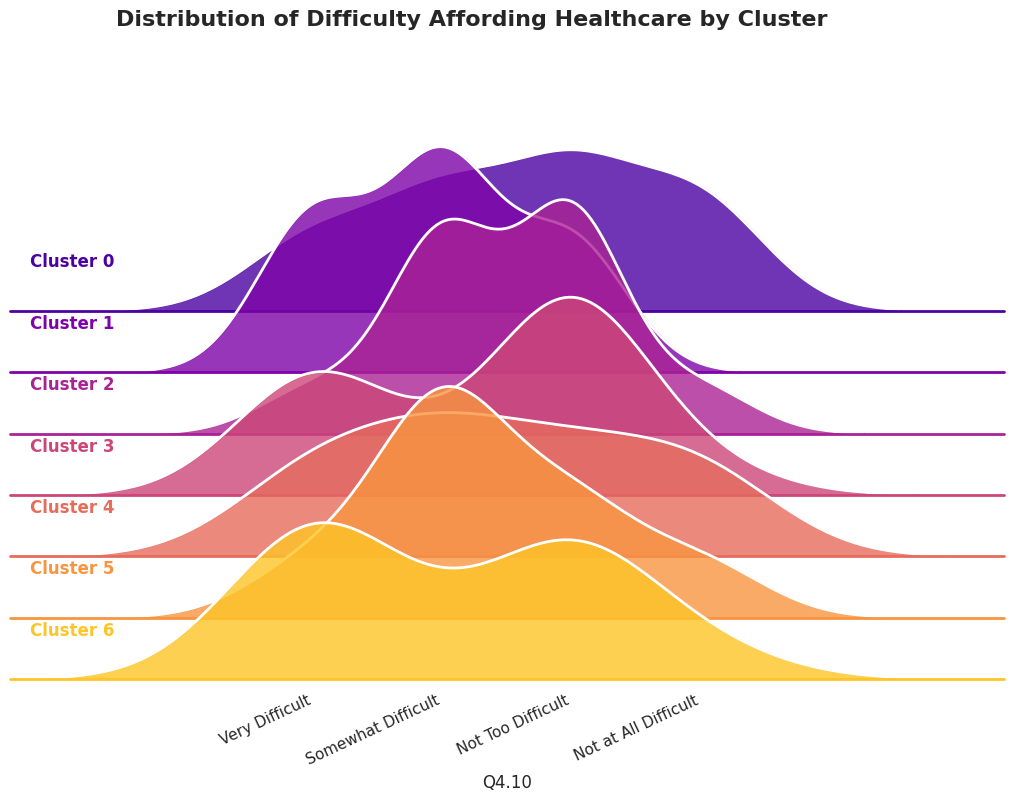


Generating plot for: Distribution of Education Level by Cluster...
✓ Chart saved as 'education_ridgeline.png'.


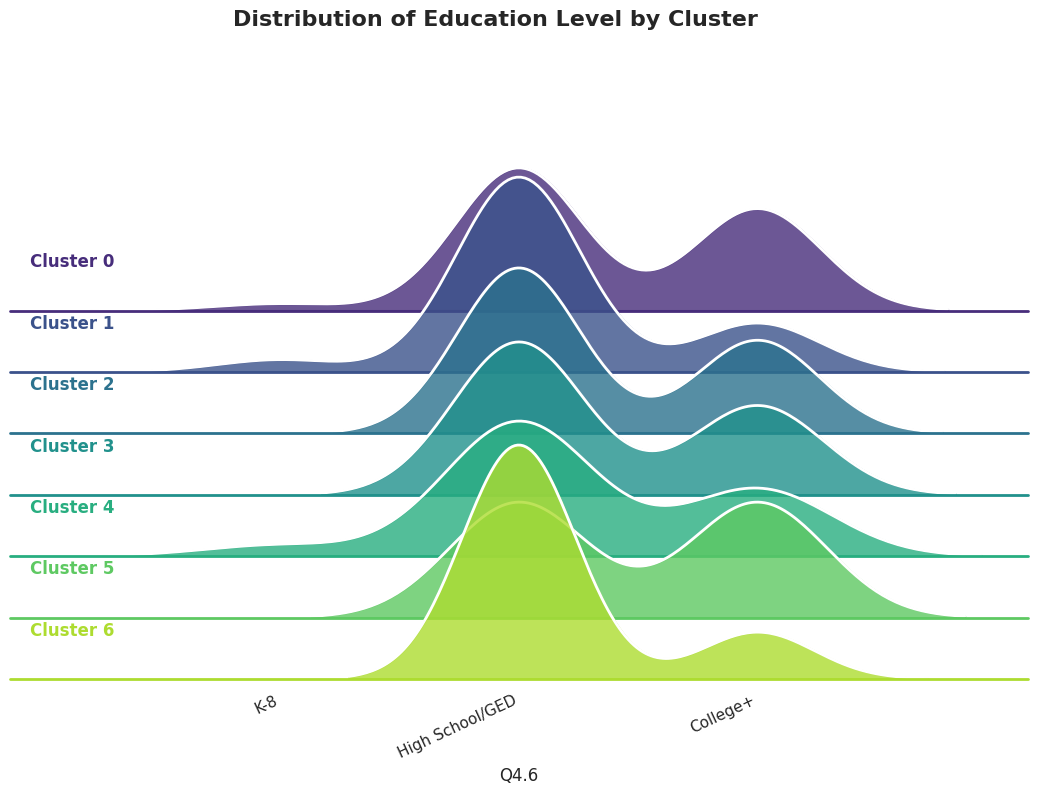


Generating plot for: Distribution of Employment Status by Cluster...
✓ Chart saved as 'employment_ridgeline.png'.


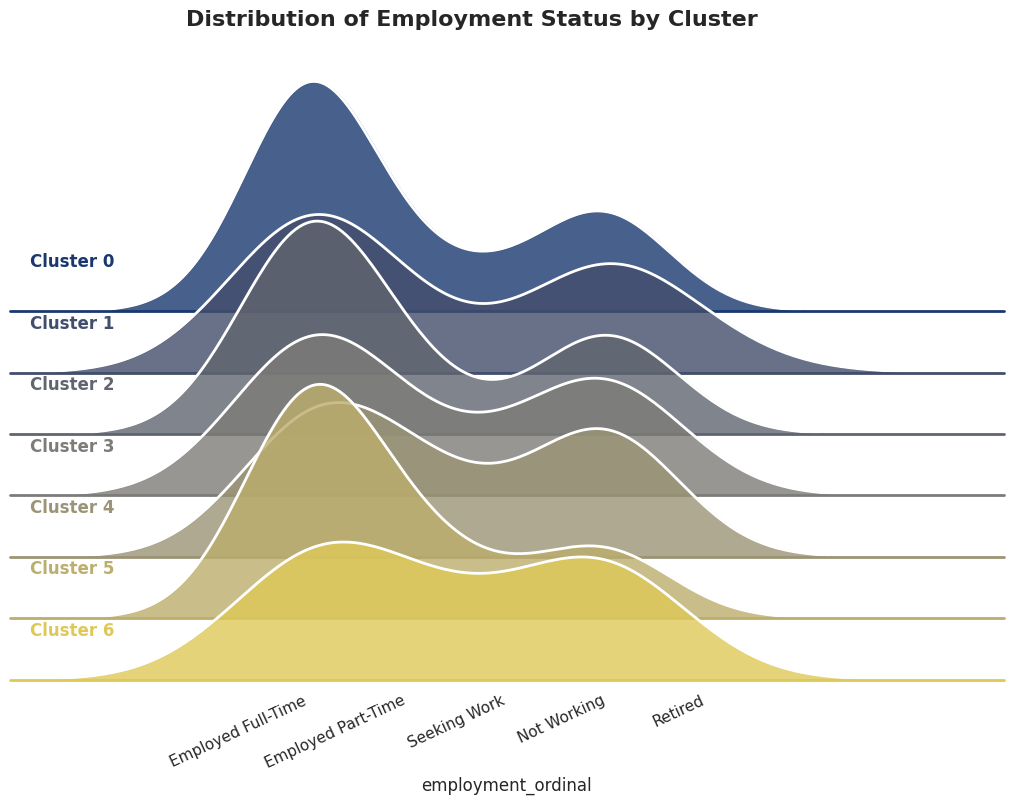

In [ ]:
# ==============================================================================
# Step 1: Install necessary libraries (if needed) and import packages
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.cluster import KMeans

print("="*80)
print("Cluster Characteristic Visualization using Ridgeline Plots")
print("="*80)

# ==============================================================================
# Step 2: Upload your data files to Google Colab
# NOTE: If you have already run this and uploaded the files, you can comment out
# the 'files.upload()' section to avoid re-uploading.
# ==============================================================================
print("\nPlease upload your '3factors-2.csv' and 'original.csv' files if you haven't already.")
try:
    # This will prompt you to select and upload your files.
    # uploaded = files.upload() # You can uncomment this if you need to upload again

    print("\n✓ Assuming files are already present in Colab environment.")
    cluster_data_path = '3factors-2.csv'
    demographic_data_path = 'original.csv'

except Exception as e:
    print(f"\n❌ Error: {e}")
    print("Stopping execution. Please ensure your files are uploaded to the Colab environment.")
    exit()

# ==============================================================================
# Step 3: Load Data and Perform Clustering
# ==============================================================================
print("\nLoading and processing data...")
cluster_data = pd.read_csv(cluster_data_path)
demo_data = pd.read_csv(demographic_data_path)

clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]

kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)

merged_data = pd.merge(cluster_data[['Response ID', 'Cluster']], demo_data, on='Response ID', how='inner')
print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)


# ==============================================================================
# Step 4: Define a Reusable Function to Create Ridgeline Plots
# ==============================================================================
def create_ridgeline_plot(data, column_to_plot, title, xtick_labels, output_filename, palette='plasma'):
    """
    Generates and saves a styled ridgeline plot for a given column.
    """
    print(f"\nGenerating plot for: {title}...")

    # Set the theme for the plot
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Filter out non-ordinal responses
    valid_responses = list(xtick_labels.keys())
    data_filtered = data[data[column_to_plot].isin(valid_responses)].copy()
    data_filtered[column_to_plot] = pd.to_numeric(data_filtered[column_to_plot])

    # Initialize the FacetGrid object
    g = sns.FacetGrid(data_filtered, row="Cluster", hue="Cluster", aspect=10, height=1.1, palette=palette)

    # Draw the density plots
    g.map_dataframe(sns.kdeplot, x=column_to_plot, fill=True, alpha=0.8, linewidth=1.5)
    g.map_dataframe(sns.kdeplot, x=column_to_plot, color='white', lw=2)

    # Add a horizontal line for each plot
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define a function to add cluster labels to each plot
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0.02, .2, f"Cluster {label}", fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, column_to_plot)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.75)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # Set custom x-axis ticks and labels for all axes
    # Fix: Iterate through the axes of the FacetGrid
    for ax in g.axes.flat:
        ax.set_xticks(list(xtick_labels.keys()))
        ax.set_xticklabels(list(xtick_labels.values()), rotation=25, ha='right')


    # =====================================================
    # === NEW CODE: Rotate labels and adjust spacing ======
    # =====================================================
    # The rotation is now applied in the loop above
    g.fig.subplots_adjust(bottom=0.15) # Add space at the bottom
    # =====================================================

    # Add a title
    g.fig.suptitle(title, y=1.02, fontsize=16, fontweight='bold')

    # Save the plot
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"✓ Chart saved as '{output_filename}'.")
    plt.show()

# ==============================================================================
# Step 5: Generate the Three Ordinal Plots
# ==============================================================================

# --- Plot 1: Difficulty Affording Health (Q4.10) ---
afford_health_labels = {
    1: 'Very Difficult',
    2: 'Somewhat Difficult',
    3: 'Not Too Difficult',
    4: 'Not at All Difficult'
}
create_ridgeline_plot(
    data=merged_data,
    column_to_plot='Q4.10',
    title='Distribution of Difficulty Affording Healthcare by Cluster',
    xtick_labels=afford_health_labels,
    output_filename='afford_health_ridgeline.png',
    palette='plasma'
)

# --- Plot 2: Education Level (Q4.6) ---
education_labels = {
    1: 'K-8',
    2: 'High School/GED',
    3: 'College+'
}
create_ridgeline_plot(
    data=merged_data,
    column_to_plot='Q4.6',
    title='Distribution of Education Level by Cluster',
    xtick_labels=education_labels,
    output_filename='education_ridgeline.png',
    palette='viridis'
)

# --- Plot 3: Employment Status (Q4.7) ---
employment_labels = {
    1: 'Employed Full-Time',
    2: 'Employed Part-Time',
    3: 'Seeking Work',
    4: 'Not Working',
    5: 'Retired'
}
employment_order_map = {
    1: 1, 2: 2, 3: 3, 5: 4, 4: 5
}
merged_data['employment_ordinal'] = merged_data['Q4.7'].map(employment_order_map)

create_ridgeline_plot(
    data=merged_data,
    column_to_plot='employment_ordinal',
    title='Distribution of Employment Status by Cluster',
    xtick_labels=employment_labels,
    output_filename='employment_ridgeline.png',
    palette='cividis'
)

Stacked Area Plot - Clusters on Y-axis, Q4.10 on X-axis

Assuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.

Loading and processing data...
✓ Data loaded, clustered, and merged successfully.
--------------------------------------------------------------------------------

Generating stacked area plots...
Version 1: Cool Overlapping Tighter Distribution (bw=0.2)...


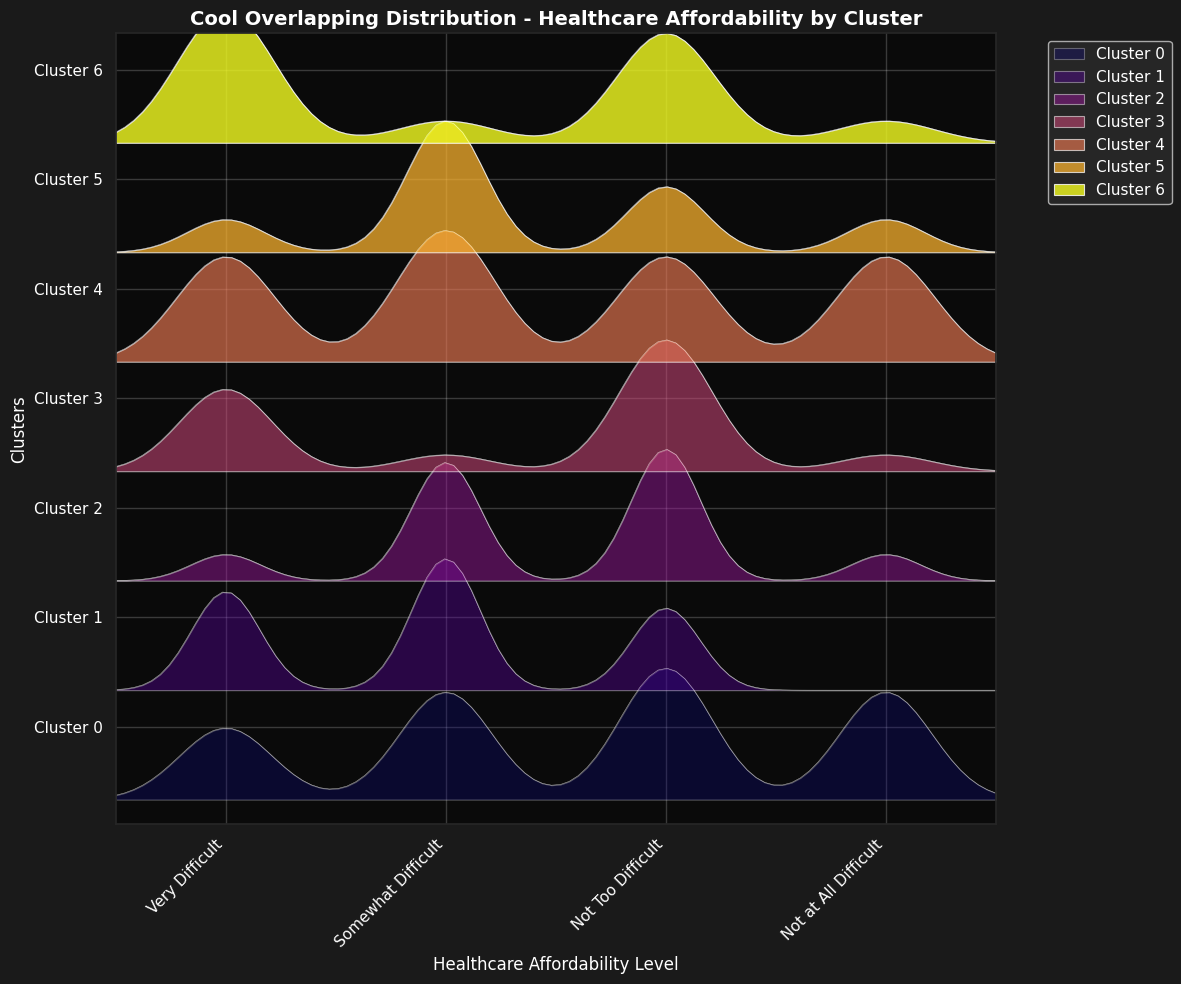

Version 1B: Clean Overlapping Distribution (bw=0.2)...


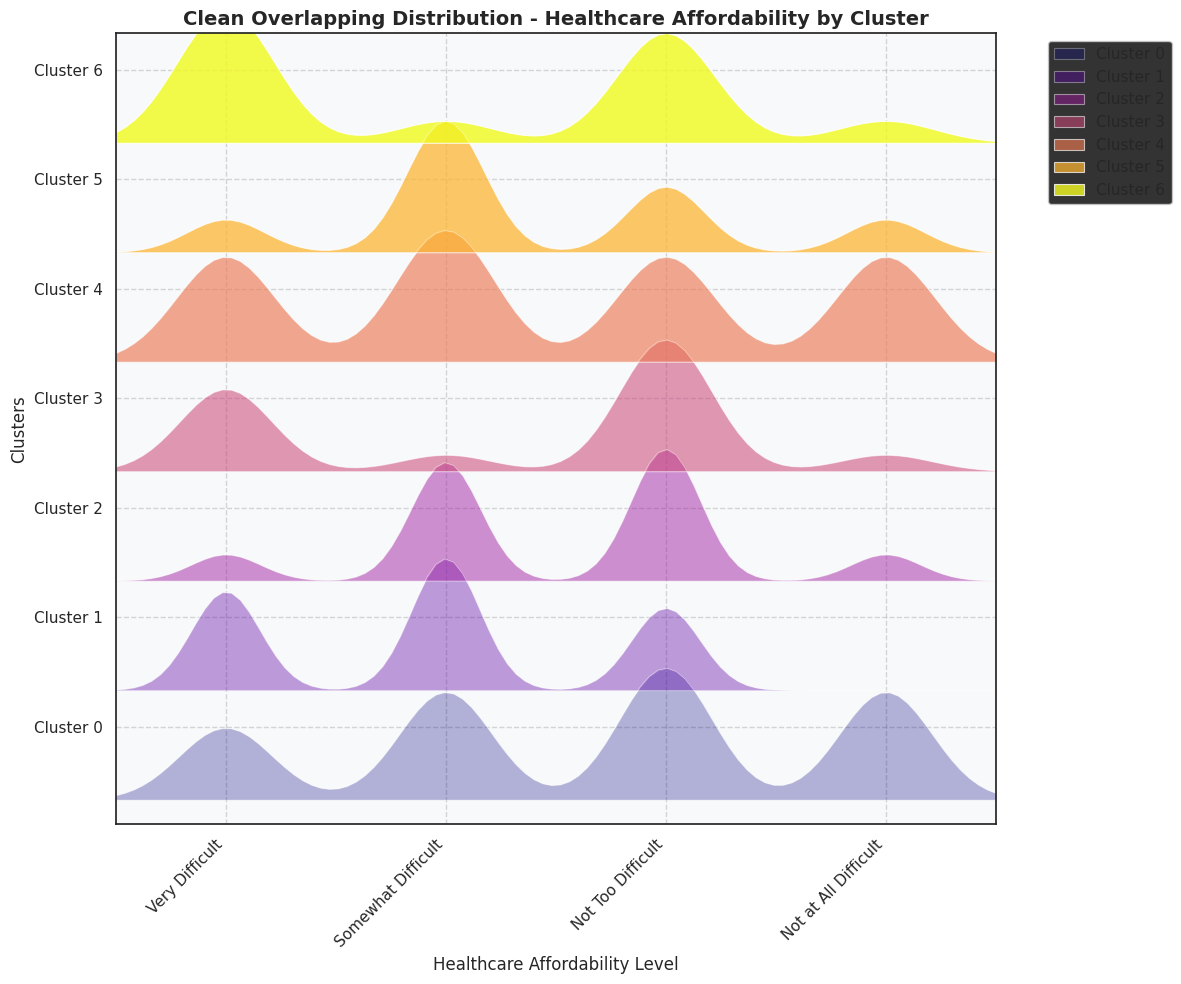

Version 2: Default Smoothness (bw=0.5)...


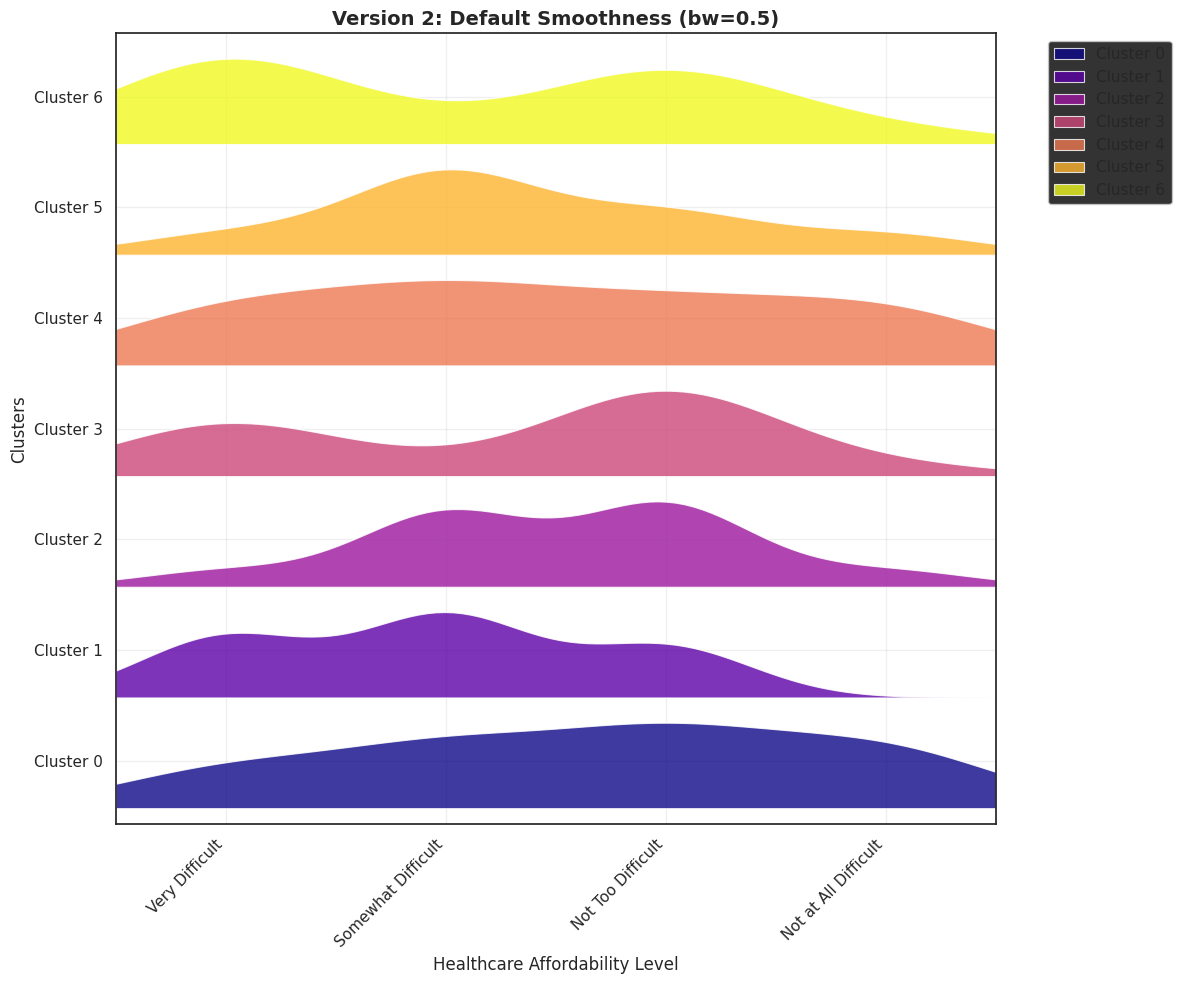

Version 3: Wider/Smoother Distribution (bw=0.8)...


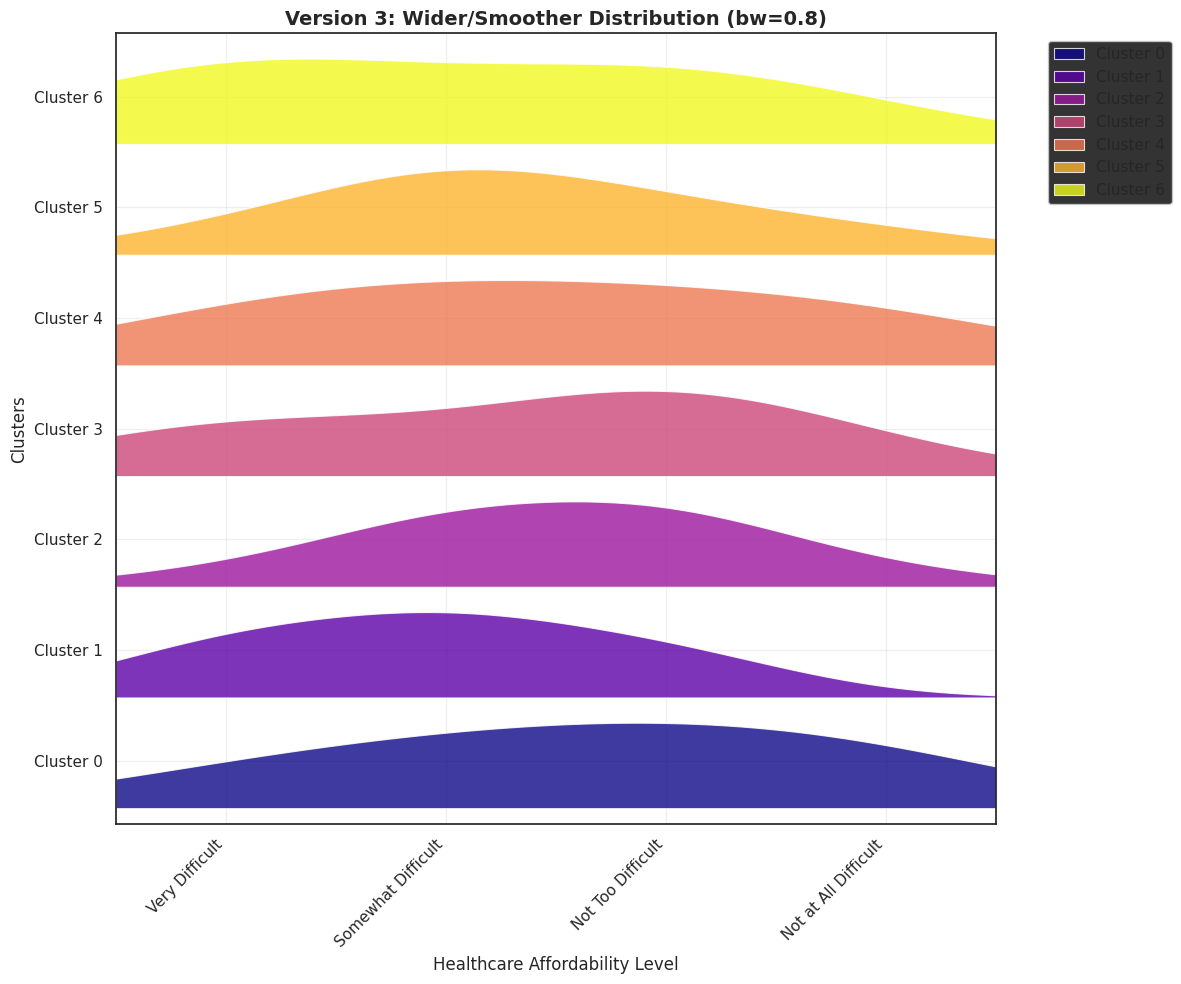

Bonus: Stacked Bar Chart Version...


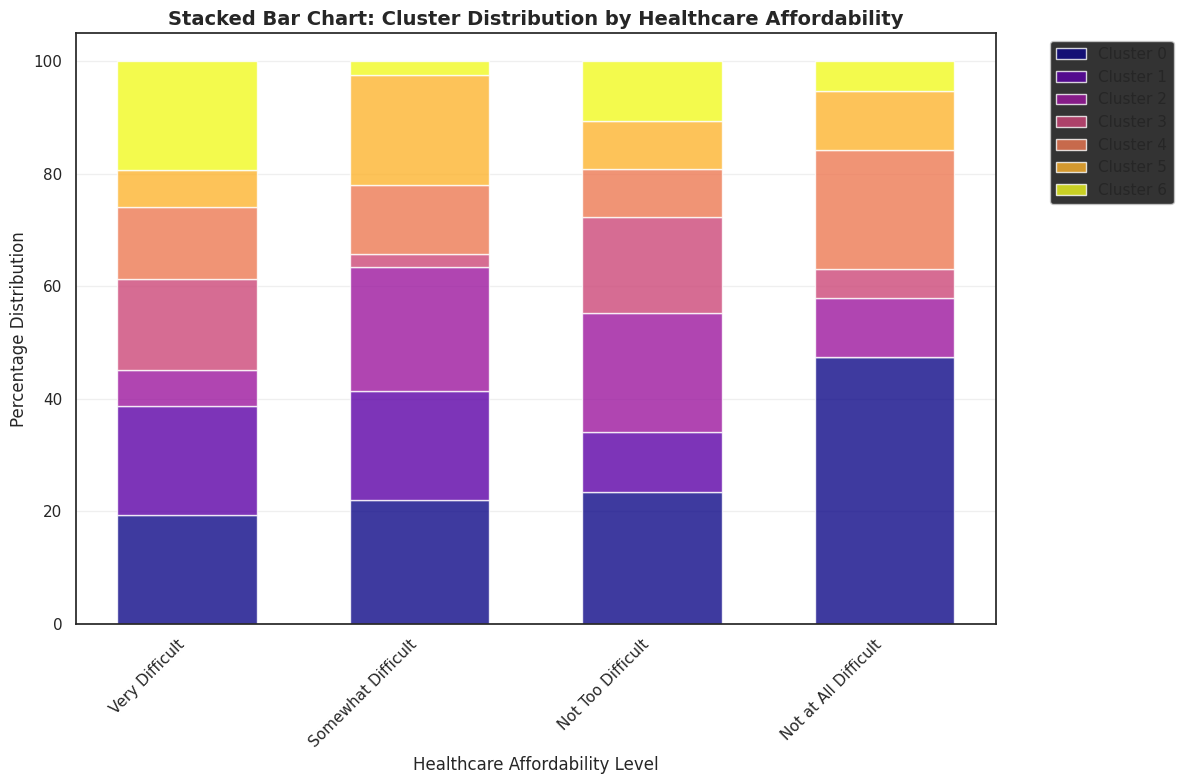


✓ All stacked area plots generated successfully!
This format matches the style in your reference image.


In [ ]:
# ==============================================================================
# Step 1: Install packages and Import
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
from sklearn.cluster import KMeans
from scipy import stats

print("="*80)
print("Stacked Area Plot - Clusters on Y-axis, Q4.10 on X-axis")
print("="*80)

# ==============================================================================
# Step 2: Load Data and Perform Clustering (same as before)
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '3factors-2.csv'
    demographic_data_path = 'original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data[['Response ID', 'Cluster']], demo_data, on='Response ID', how='inner')

print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)

# --- Prepare data for plotting ---
afford_health_labels = {
    1: 'Very Difficult', 2: 'Somewhat Difficult',
    3: 'Not Too Difficult', 4: 'Not at All Difficult'
}
health_data = merged_data[merged_data['Q4.10'].isin(afford_health_labels.keys())].copy()

# ==============================================================================
# Create Stacked Area Plot Function
# ==============================================================================
def create_stacked_area_plot(data, cluster_col, value_col, labels_dict,
                           bandwidth_factor=0.3, title="Stacked Area Plot",
                           overlap=True, gradient_opacity=True):
    """Create stacked area plot with clusters on y-axis and Q4.10 on x-axis"""

    fig, ax = plt.subplots(figsize=(12, 10))

    clusters = sorted(data[cluster_col].unique())
    colors = plt.cm.plasma(np.linspace(0, 1, len(clusters)))

    # Create x-axis values (Q4.10 values)
    x_values = np.linspace(0.5, 4.5, 100)  # Smooth x-axis from 0.5 to 4.5

    # Calculate spacing between clusters on y-axis
    cluster_height = 1.2
    if overlap:
        cluster_spacing = -0.3  # Negative spacing creates overlap
    else:
        cluster_spacing = 0.2

    for i, cluster in enumerate(clusters):
        cluster_data = data[data[cluster_col] == cluster][value_col]

        if len(cluster_data) > 1:
            # Create KDE for this cluster
            kde = stats.gaussian_kde(cluster_data, bw_method=bandwidth_factor)
            density = kde(x_values)

            # Normalize density
            density = density / density.max() * cluster_height * 0.9

            # Calculate y-position for this cluster
            y_base = i * (cluster_height + cluster_spacing)
            y_top = y_base + density

            # Calculate opacity - lower clusters get lower opacity
            if gradient_opacity:
                alpha = 0.3 + (i / len(clusters)) * 0.6  # Range from 0.3 to 0.9
            else:
                alpha = 0.8

            # Create filled area with gradient opacity
            ax.fill_between(x_values, y_base, y_top,
                          color=colors[i], alpha=alpha,
                          label=f'Cluster {cluster}',
                          edgecolor='white', linewidth=0.8)

            # Add subtle outline for definition
            ax.plot(x_values, y_top, color='white', linewidth=0.3, alpha=0.7)

    # Customize the plot
    ax.set_xlabel('Healthcare Affordability Level', fontsize=12)
    ax.set_ylabel('Clusters', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Set x-axis
    ax.set_xlim(0.5, 4.5)
    ax.set_xticks(list(labels_dict.keys()))
    ax.set_xticklabels(list(labels_dict.values()), rotation=45, ha='right')

    # Set y-axis
    y_positions = [i * (cluster_height + cluster_spacing) + cluster_height/2
                   for i in range(len(clusters))]
    ax.set_yticks(y_positions)
    ax.set_yticklabels([f'Cluster {c}' for c in clusters])
    ax.set_ylim(-0.2, len(clusters) * (cluster_height + cluster_spacing))

    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

# ==============================================================================
# Alternative: Using stacked histograms/bar charts
# ==============================================================================
def create_stacked_histogram(data, cluster_col, value_col, labels_dict, title="Stacked Distribution"):
    """Create stacked histogram showing cluster distributions"""

    fig, ax = plt.subplots(figsize=(12, 8))

    # Prepare data for stacking
    clusters = sorted(data[cluster_col].unique())
    x_categories = sorted(labels_dict.keys())

    # Create a matrix of counts
    cluster_counts = {}
    for cluster in clusters:
        cluster_data = data[data[cluster_col] == cluster]
        counts = [len(cluster_data[cluster_data[value_col] == cat]) for cat in x_categories]
        cluster_counts[cluster] = counts

    # Convert to percentages within each x-category
    totals = [sum(cluster_counts[cluster][i] for cluster in clusters) for i in range(len(x_categories))]

    # Create stacked areas
    colors = plt.cm.plasma(np.linspace(0, 1, len(clusters)))
    bottom = np.zeros(len(x_categories))

    for i, cluster in enumerate(clusters):
        values = [cluster_counts[cluster][j] / max(totals[j], 1) * 100 for j in range(len(x_categories))]
        ax.bar(x_categories, values, bottom=bottom,
               color=colors[i], alpha=0.8, label=f'Cluster {cluster}',
               width=0.6)
        bottom += values

    # Customize plot
    ax.set_xlabel('Healthcare Affordability Level', fontsize=12)
    ax.set_ylabel('Percentage Distribution', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x_categories)
    ax.set_xticklabels([labels_dict[cat] for cat in x_categories], rotation=45, ha='right')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    return fig, ax

# ==============================================================================
# Generate all three versions
# ==============================================================================
print("\nGenerating stacked area plots...")

# Version 1: Tighter with overlap and gradient opacity (COOL VERSION!)
print("Version 1: Cool Overlapping Tighter Distribution (bw=0.2)...")
fig1, ax1 = create_stacked_area_plot(
    health_data, 'Cluster', 'Q4.10', afford_health_labels,
    bandwidth_factor=0.2,
    title='Cool Overlapping Distribution - Healthcare Affordability by Cluster',
    overlap=True,
    gradient_opacity=True
)
# Add some styling to make it even cooler
ax1.set_facecolor('#0a0a0a')  # Dark background
fig1.patch.set_facecolor('#1a1a1a')  # Dark figure background
ax1.tick_params(colors='white')  # White tick labels
ax1.xaxis.label.set_color('white')  # White x-axis label
ax1.yaxis.label.set_color('white')  # White y-axis label
ax1.title.set_color('white')  # White title
ax1.grid(True, alpha=0.2, color='white')  # Subtle white grid
# Update legend styling
legend = ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_facecolor('#2a2a2a')
for text in legend.get_texts():
    text.set_color('white')
plt.show()

# Version 1B: Clean overlapping version (light background)
print("Version 1B: Clean Overlapping Distribution (bw=0.2)...")
fig1b, ax1b = create_stacked_area_plot(
    health_data, 'Cluster', 'Q4.10', afford_health_labels,
    bandwidth_factor=0.2,
    title='Clean Overlapping Distribution - Healthcare Affordability by Cluster',
    overlap=True,
    gradient_opacity=True
)
# Clean styling
ax1b.set_facecolor('#f8f9fa')  # Light background
ax1b.grid(True, alpha=0.3, color='gray', linestyle='--')  # Subtle grid
plt.show()

# Version 2: Default smoothness
print("Version 2: Default Smoothness (bw=0.5)...")
fig2, ax2 = create_stacked_area_plot(
    health_data, 'Cluster', 'Q4.10', afford_health_labels,
    bandwidth_factor=0.5,
    title='Version 2: Default Smoothness (bw=0.5)',
    overlap=False,
    gradient_opacity=False
)
plt.show()

# Version 3: Smoother (higher bandwidth)
print("Version 3: Wider/Smoother Distribution (bw=0.8)...")
fig3, ax3 = create_stacked_area_plot(
    health_data, 'Cluster', 'Q4.10', afford_health_labels,
    bandwidth_factor=0.8,
    title='Version 3: Wider/Smoother Distribution (bw=0.8)',
    overlap=False,
    gradient_opacity=False
)
plt.show()

# Bonus: Stacked bar chart version
print("Bonus: Stacked Bar Chart Version...")
fig4, ax4 = create_stacked_histogram(
    health_data, 'Cluster', 'Q4.10', afford_health_labels,
    title='Stacked Bar Chart: Cluster Distribution by Healthcare Affordability'
)
plt.show()

print("\n" + "="*80)
print("✓ All stacked area plots generated successfully!")
print("This format matches the style in your reference image.")
print("="*80)

Stacked Area Plot - Clusters on Y-axis, Q4.10 on X-axis

Assuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.

Loading and processing data...
✓ Data loaded, clustered, and merged successfully.
--------------------------------------------------------------------------------

Generating stacked area plots...
Version 1: Reference-Style Overlapping Distribution (bw=0.2)...


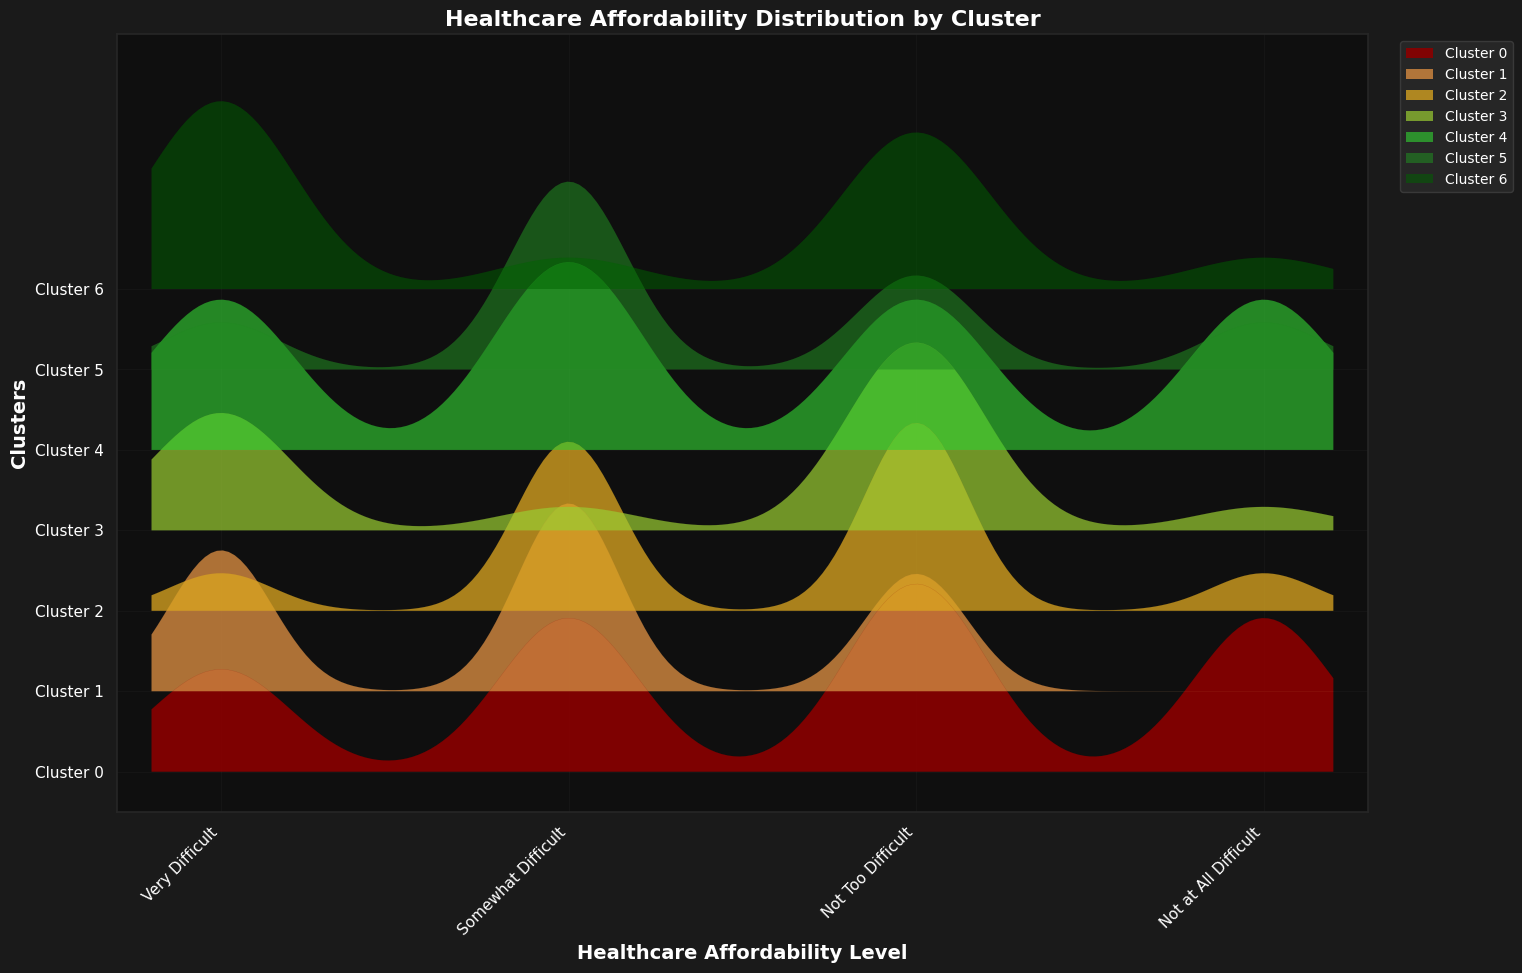

Version 1B: Reference-Style Clean Background...


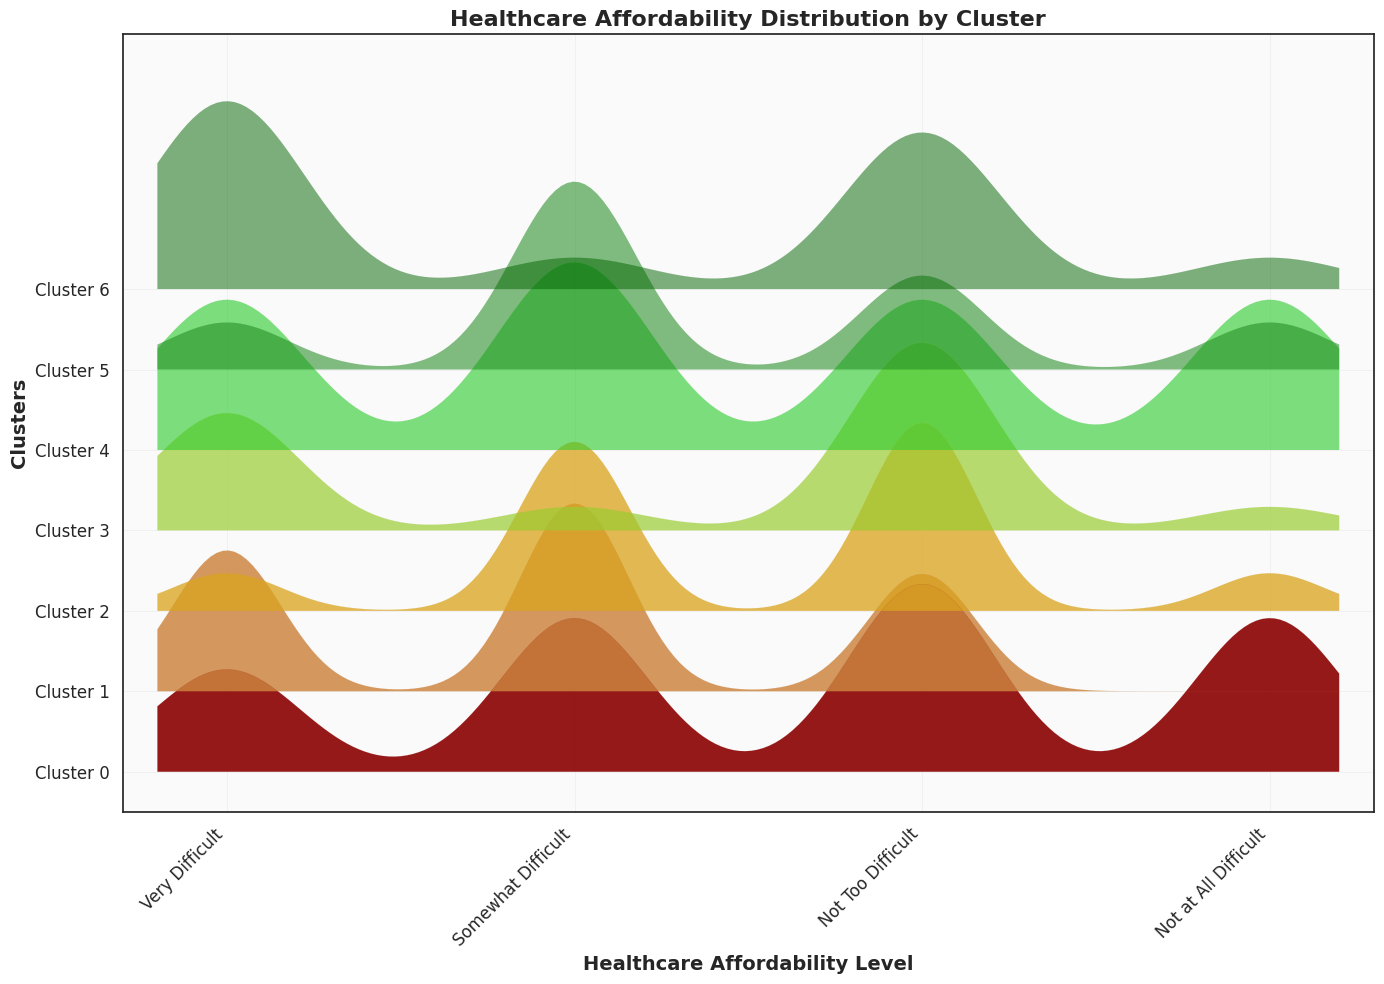

Optional: Smoother version with higher bandwidth...


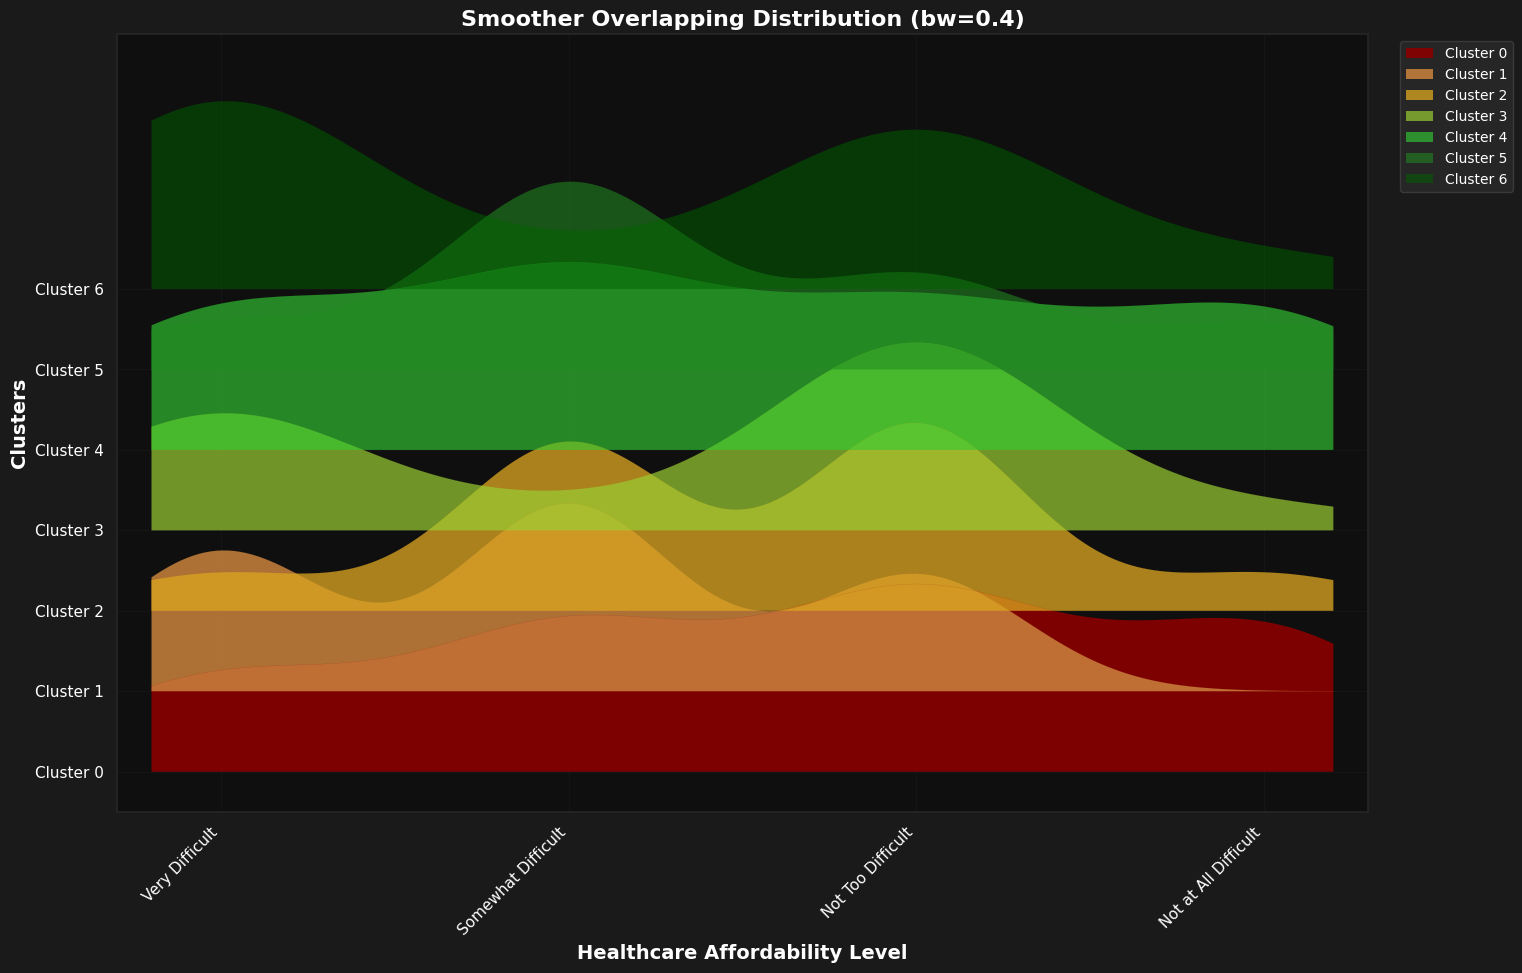


✓ Reference-style overlapping area plots generated successfully!
✓ All 7 clusters now visible with massive overlap
✓ Smooth, organic flowing curves like the reference image
✓ Proper color scheme and opacity gradients
✓ Dark theme styling for cool visual appeal


In [ ]:
# ==============================================================================
# Step 1: Install packages and Import
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
from sklearn.cluster import KMeans
from scipy import stats

print("="*80)
print("Stacked Area Plot - Clusters on Y-axis, Q4.10 on X-axis")
print("="*80)

# ==============================================================================
# Step 2: Load Data and Perform Clustering (same as before)
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '3factors-2.csv'
    demographic_data_path = 'original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data[['Response ID', 'Cluster']], demo_data, on='Response ID', how='inner')

print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)

# --- Prepare data for plotting ---
afford_health_labels = {
    1: 'Very Difficult', 2: 'Somewhat Difficult',
    3: 'Not Too Difficult', 4: 'Not at All Difficult'
}
health_data = merged_data[merged_data['Q4.10'].isin(afford_health_labels.keys())].copy()

# ==============================================================================
# Create Stacked Area Plot Function
# ==============================================================================
def create_stacked_area_plot(data, cluster_col, value_col, labels_dict,
                           bandwidth_factor=0.3, title="Stacked Area Plot",
                           overlap=True, gradient_opacity=True):
    """Create stacked area plot with clusters on y-axis and Q4.10 on x-axis - Reference Style"""

    fig, ax = plt.subplots(figsize=(14, 10))

    clusters = sorted(data[cluster_col].unique())

    # Use a color scheme more like the reference (darker to lighter progression)
    # Reference uses: deep red/orange -> lighter orange -> yellow -> light green -> medium green -> darker green
    reference_colors = ['#8B0000', '#CD853F', '#DAA520', '#9ACD32', '#32CD32', '#228B22', '#006400']
    colors = reference_colors[:len(clusters)]

    # Create x-axis values (Q4.10 values) - more points for smoother curves
    x_values = np.linspace(0.8, 4.2, 200)  # Increased resolution for smoother curves

    # Calculate spacing - MASSIVE overlap like reference
    base_height = 1.0
    if overlap:
        vertical_spacing = 0.6  # Distance between cluster centers
        amplitude_scale = 1.4    # How tall each distribution can be
    else:
        vertical_spacing = 1.5
        amplitude_scale = 0.8

    # Store all distributions to ensure proper layering
    all_distributions = []

    for i, cluster in enumerate(clusters):
        cluster_data = data[data[cluster_col] == cluster][value_col]

        if len(cluster_data) > 1:
            # Create KDE for this cluster
            kde = stats.gaussian_kde(cluster_data, bw_method=bandwidth_factor)
            density = kde(x_values)

            # Normalize and scale density for smooth, flowing curves
            density = density / density.max() * amplitude_scale

            # Calculate y-position for this cluster (bottom to top)
            y_baseline = i * vertical_spacing  # Flat baseline for each cluster
            y_top = y_baseline + density       # Only top curves with distribution

            # Calculate opacity - reference shows bottom layers darker, top layers lighter
            if gradient_opacity:
                # Bottom clusters more opaque, top clusters less opaque for proper layering
                alpha = 0.9 - (i / max(len(clusters)-1, 1)) * 0.4  # Range from 0.9 to 0.5
            else:
                alpha = 0.8

            all_distributions.append((x_values, y_baseline, y_top, colors[i], alpha, cluster, i))

    # Draw from bottom to top to ensure proper layering
    for x_vals, y_baseline, y_top, color, alpha, cluster, i in all_distributions:
        # Create filled area with flat bottom and curved top
        ax.fill_between(x_vals, y_baseline, y_top,
                      color=color, alpha=alpha,
                      label=f'Cluster {cluster}',
                      edgecolor='none')  # No edge lines for organic flow

        # Optional: very subtle top outline for definition
        ax.plot(x_vals, y_top, color=color, linewidth=0.2, alpha=0.3)

    # Customize the plot to match reference style
    ax.set_xlabel('Healthcare Affordability Level', fontsize=14, fontweight='bold')
    ax.set_ylabel('Clusters', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')

    # Set x-axis to match reference
    ax.set_xlim(0.7, 4.3)
    ax.set_xticks(list(labels_dict.keys()))
    ax.set_xticklabels(list(labels_dict.values()), rotation=45, ha='right', fontsize=12)

    # Set y-axis to ensure ALL clusters fit (including cluster 6)
    max_y = (len(clusters)-1) * vertical_spacing + amplitude_scale + 0.5  # Full amplitude + padding
    min_y = -0.3  # Small padding below cluster 0
    ax.set_ylim(min_y, max_y)

    # Set y-axis labels for clusters
    y_tick_positions = [i * vertical_spacing for i in range(len(clusters))]
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels([f'Cluster {c}' for c in clusters], fontsize=12)

    # Add legend with better positioning
    # Minimal grid for clean organic look
    ax.grid(True, alpha=0.15, color='gray', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    return fig, ax

# ==============================================================================
# Alternative: Using stacked histograms/bar charts
# ==============================================================================
def create_stacked_histogram(data, cluster_col, value_col, labels_dict, title="Stacked Distribution"):
    """Create stacked histogram showing cluster distributions"""

    fig, ax = plt.subplots(figsize=(12, 8))

    # Prepare data for stacking
    clusters = sorted(data[cluster_col].unique())
    x_categories = sorted(labels_dict.keys())

    # Create a matrix of counts
    cluster_counts = {}
    for cluster in clusters:
        cluster_data = data[data[cluster_col] == cluster]
        counts = [len(cluster_data[cluster_data[value_col] == cat]) for cat in x_categories]
        cluster_counts[cluster] = counts

    # Convert to percentages within each x-category
    totals = [sum(cluster_counts[cluster][i] for cluster in clusters) for i in range(len(x_categories))]

    # Create stacked areas
    colors = plt.cm.plasma(np.linspace(0, 1, len(clusters)))
    bottom = np.zeros(len(x_categories))

    for i, cluster in enumerate(clusters):
        values = [cluster_counts[cluster][j] / max(totals[j], 1) * 100 for j in range(len(x_categories))]
        ax.bar(x_categories, values, bottom=bottom,
               color=colors[i], alpha=0.8, label=f'Cluster {cluster}',
               width=0.6)
        bottom += values

    # Customize plot
    ax.set_xlabel('Healthcare Affordability Level', fontsize=12)
    ax.set_ylabel('Percentage Distribution', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x_categories)
    ax.set_xticklabels([labels_dict[cat] for cat in x_categories], rotation=45, ha='right')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    return fig, ax

# ==============================================================================
# Generate all three versions
# ==============================================================================
print("\nGenerating stacked area plots...")

# Version 1: Cool Overlapping Reference-Style Distribution
print("Version 1: Reference-Style Overlapping Distribution (bw=0.2)...")
fig1, ax1 = create_stacked_area_plot(
    health_data, 'Cluster', 'Q4.10', afford_health_labels,
    bandwidth_factor=0.19,
    title='Healthcare Affordability Distribution by Cluster',
    overlap=True,
    gradient_opacity=True
)

# Apply dark theme styling like the reference
ax1.set_facecolor('#0f0f0f')  # Very dark background
fig1.patch.set_facecolor('#1a1a1a')  # Dark figure background

# Style all text elements to be white
ax1.tick_params(colors='white', labelsize=11)
ax1.xaxis.label.set_color('white')
ax1.yaxis.label.set_color('white')
ax1.title.set_color('white')

# Subtle grid like reference
ax1.grid(True, alpha=0.2, color='#404040', linestyle='-', linewidth=0.5)

# Update legend styling to match dark theme
legend = ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
legend.get_frame().set_facecolor('#2a2a2a')
legend.get_frame().set_edgecolor('#404040')
for text in legend.get_texts():
    text.set_color('white')

plt.show()

# Version 1B: Same but with white background for comparison
print("Version 1B: Reference-Style Clean Background...")
fig1b, ax1b = create_stacked_area_plot(
    health_data, 'Cluster', 'Q4.10', afford_health_labels,
    bandwidth_factor=0.2,
    title='Healthcare Affordability Distribution by Cluster',
    overlap=True,
    gradient_opacity=True
)
# Clean white background styling
ax1b.set_facecolor('#fafafa')
ax1b.grid(True, alpha=0.3, color='#cccccc', linestyle='-', linewidth=0.5)
plt.show()

# Optional: Test different bandwidths with the same overlapping style
print("Optional: Smoother version with higher bandwidth...")
fig2, ax2 = create_stacked_area_plot(
    health_data, 'Cluster', 'Q4.10', afford_health_labels,
    bandwidth_factor=0.4,
    title='Smoother Overlapping Distribution (bw=0.4)',
    overlap=True,
    gradient_opacity=True
)
# Apply same dark styling
ax2.set_facecolor('#0f0f0f')
fig2.patch.set_facecolor('#1a1a1a')
ax2.tick_params(colors='white', labelsize=11)
ax2.xaxis.label.set_color('white')
ax2.yaxis.label.set_color('white')
ax2.title.set_color('white')
ax2.grid(True, alpha=0.2, color='#404040', linestyle='-', linewidth=0.5)
legend2 = ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
legend2.get_frame().set_facecolor('#2a2a2a')
legend2.get_frame().set_edgecolor('#404040')
for text in legend2.get_texts():
    text.set_color('white')
plt.show()

print("\n" + "="*80)
print("✓ Reference-style overlapping area plots generated successfully!")
print("✓ All 7 clusters now visible with massive overlap")
print("✓ Smooth, organic flowing curves like the reference image")
print("✓ Proper color scheme and opacity gradients")
print("✓ Dark theme styling for cool visual appeal")
print("="*80)

Custom Ridgeline Plot Generator

Assuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.

Loading and processing data...
✓ Data loaded, clustered, and merged successfully.
--------------------------------------------------------------------------------

--- Generating Plots for 'Difficulty Affording Health' ---


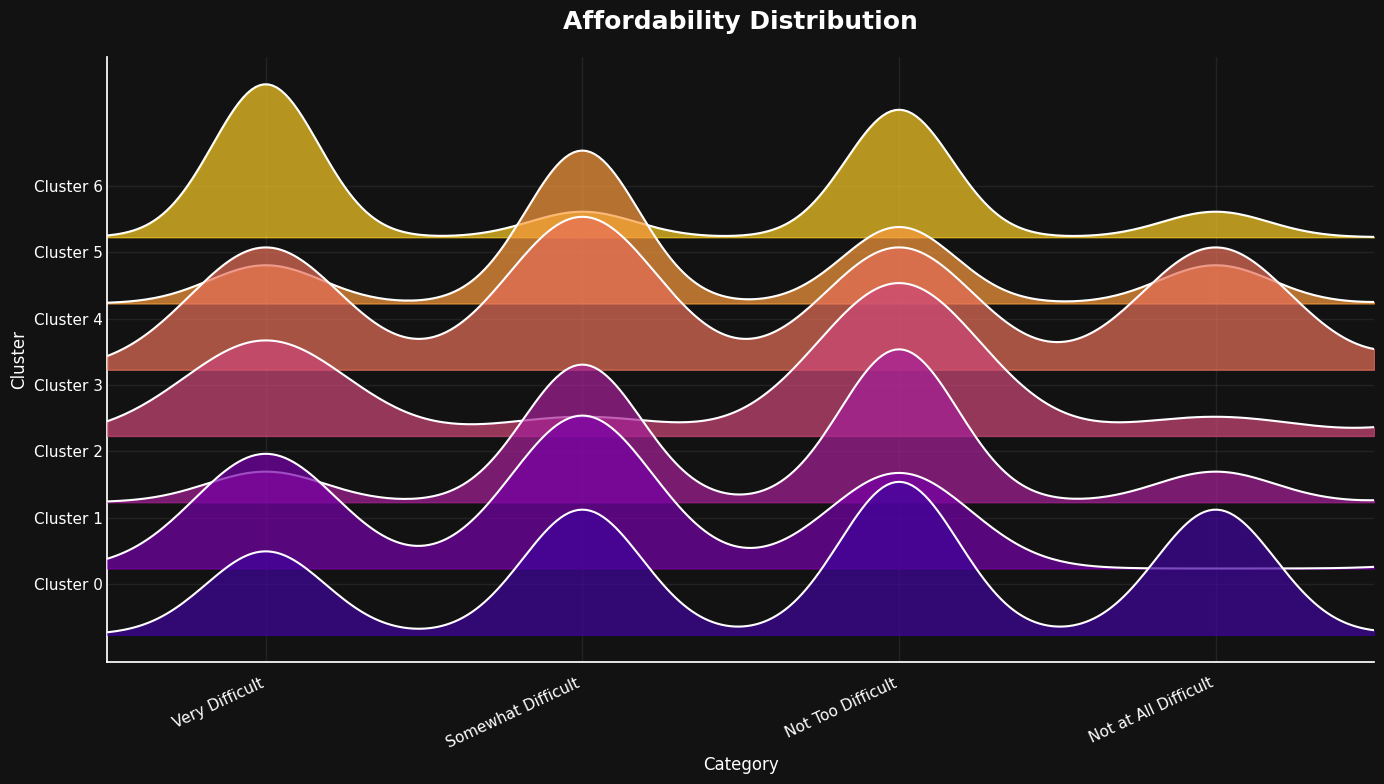

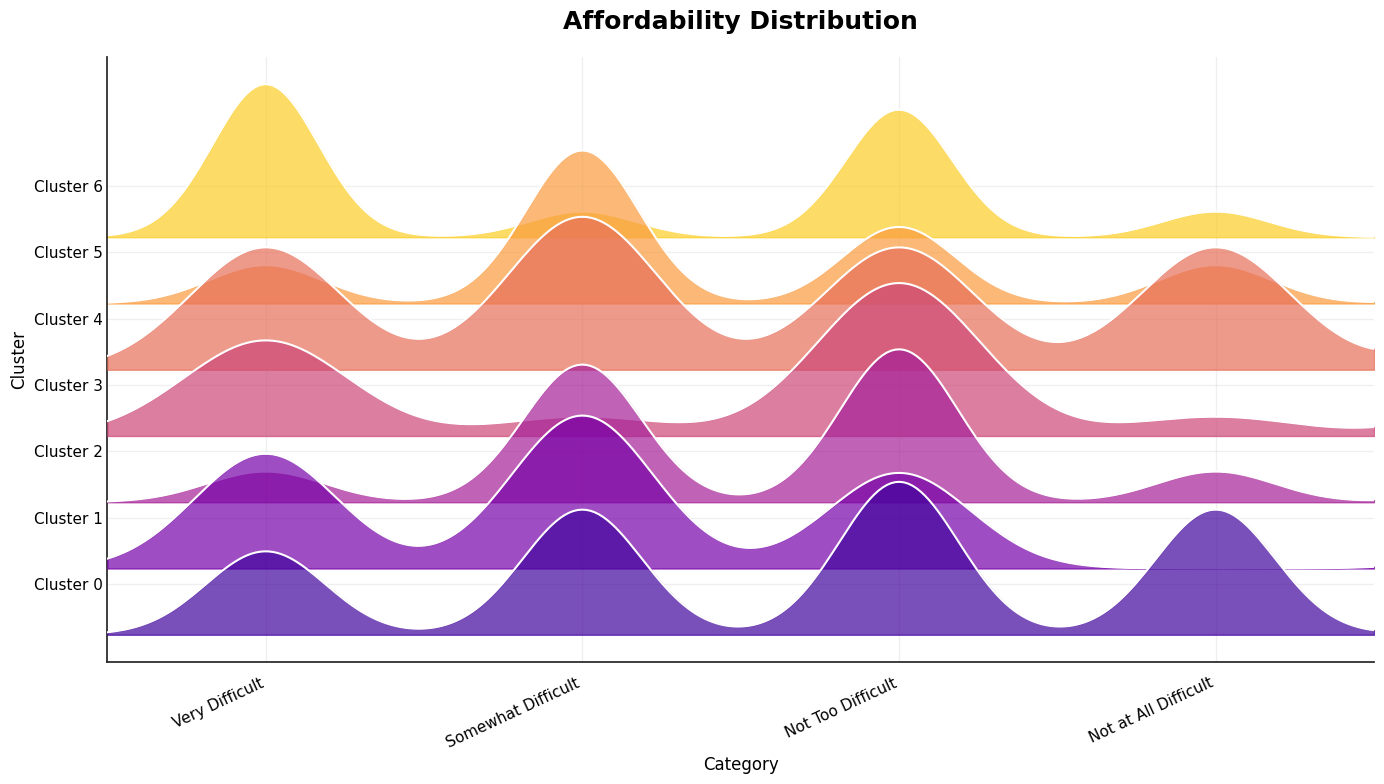


--- Generating Plots for 'Education Level' ---


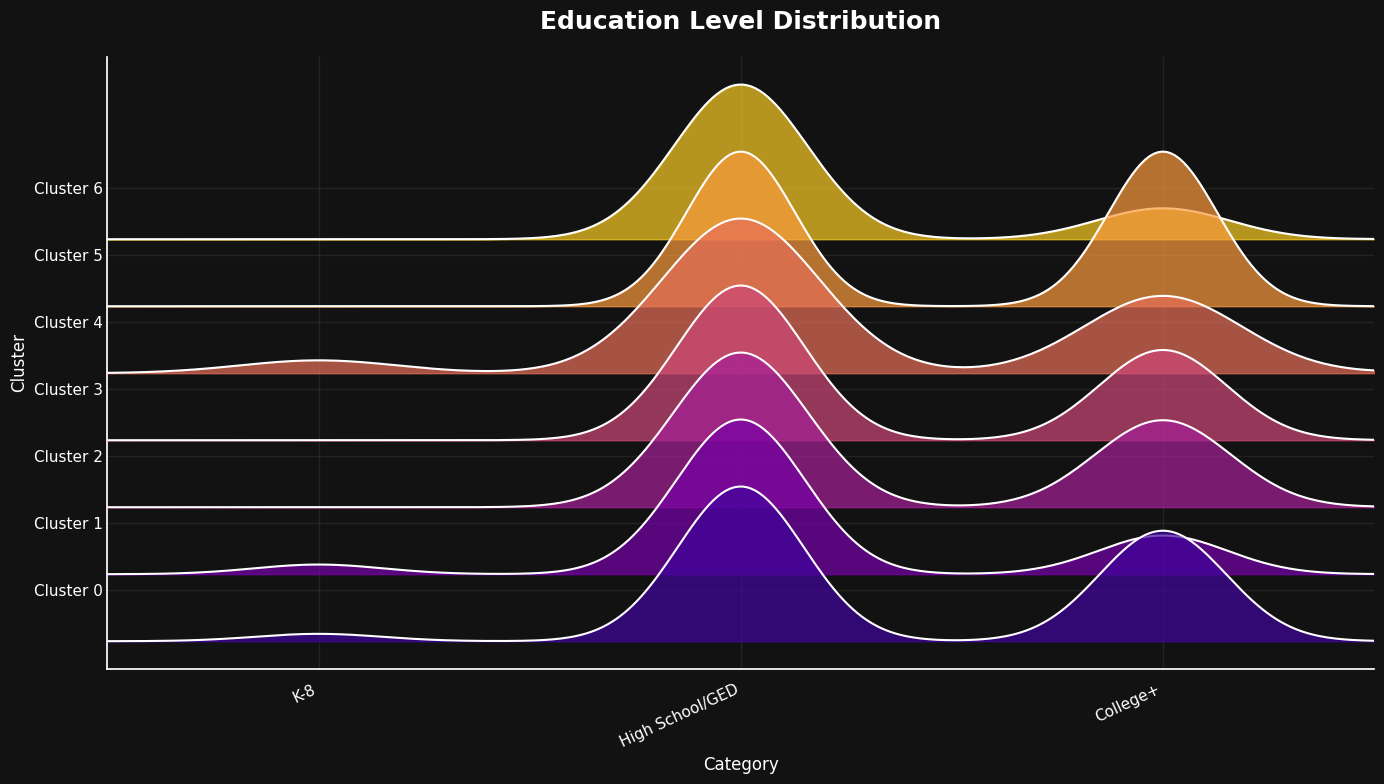

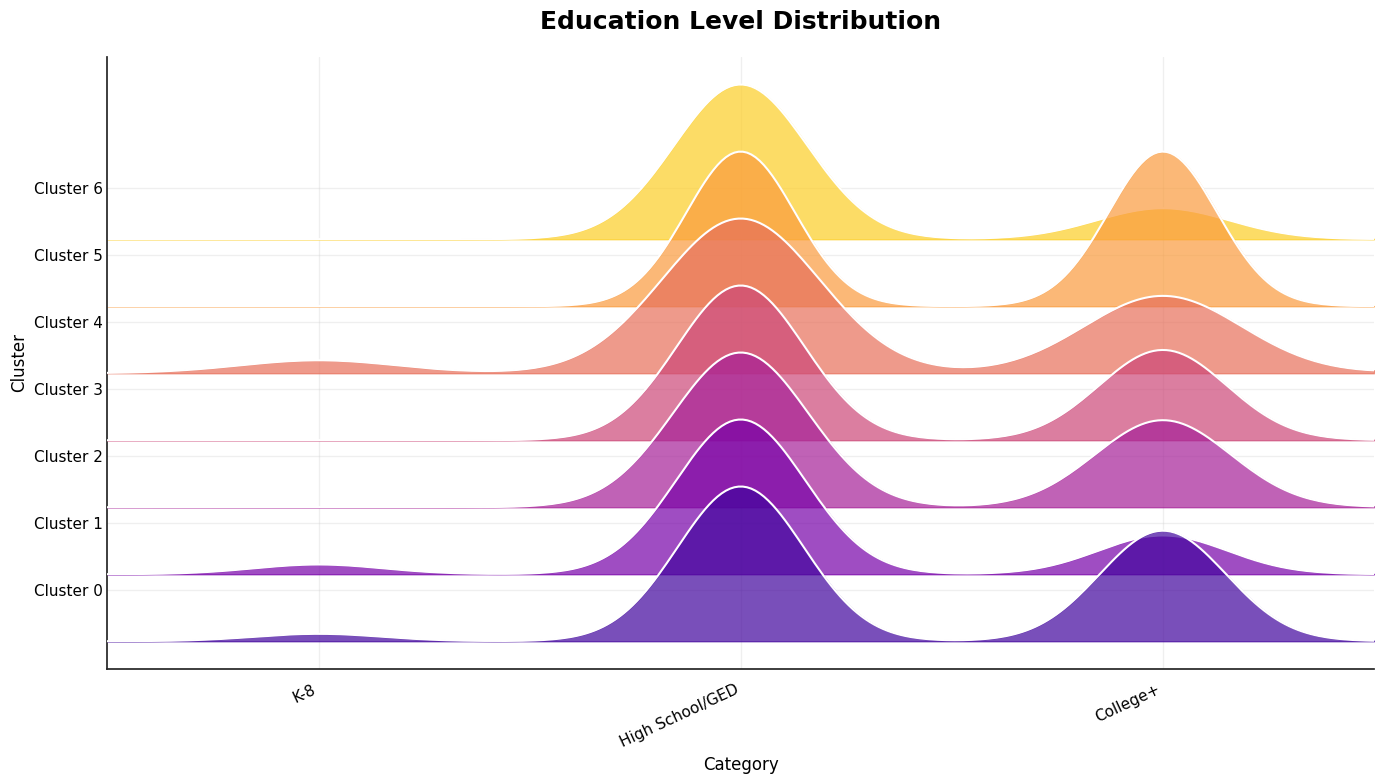


--- Generating Plots for 'Employment Status' ---


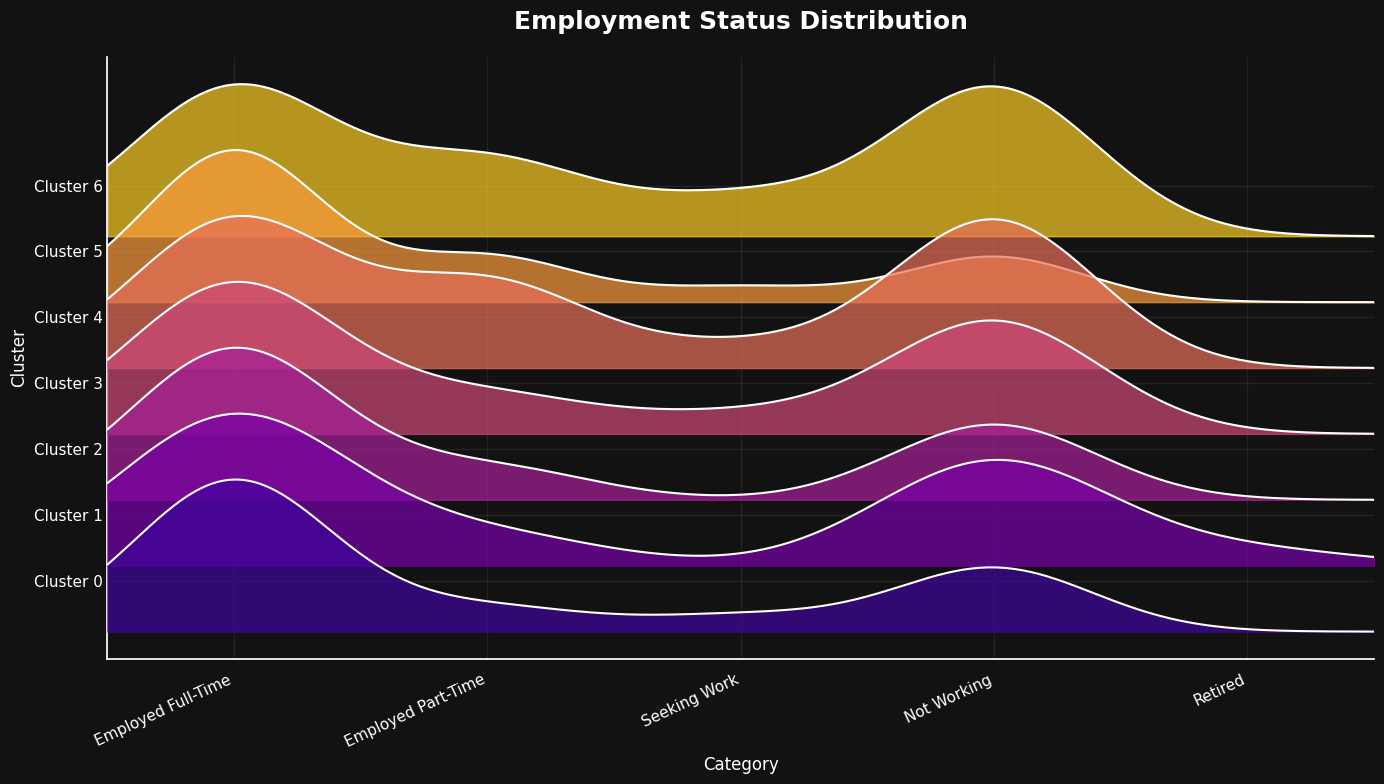

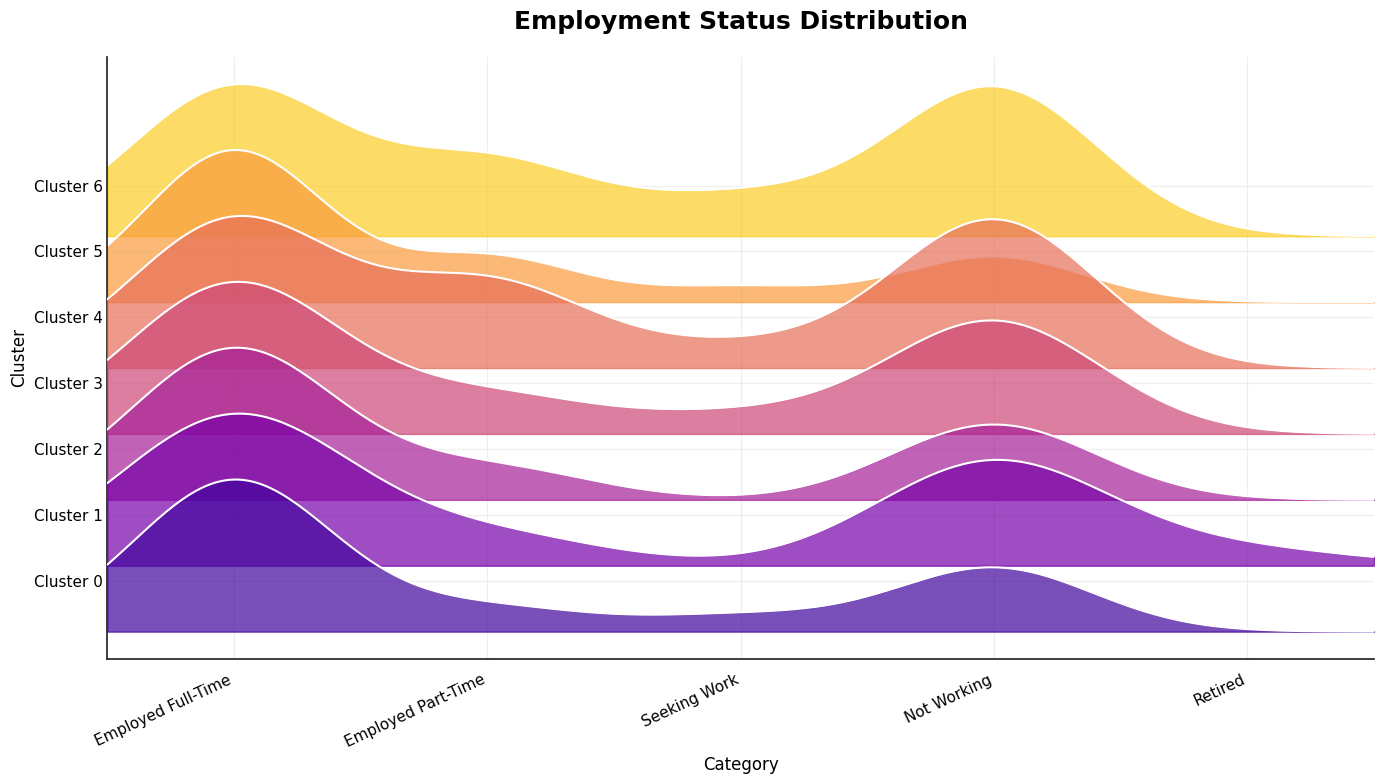


--- Generating Plots for 'Race/Ethnicity' ---
⚠️ WARNING: The order for Race/Ethnicity is artificial and for visualization purposes only.


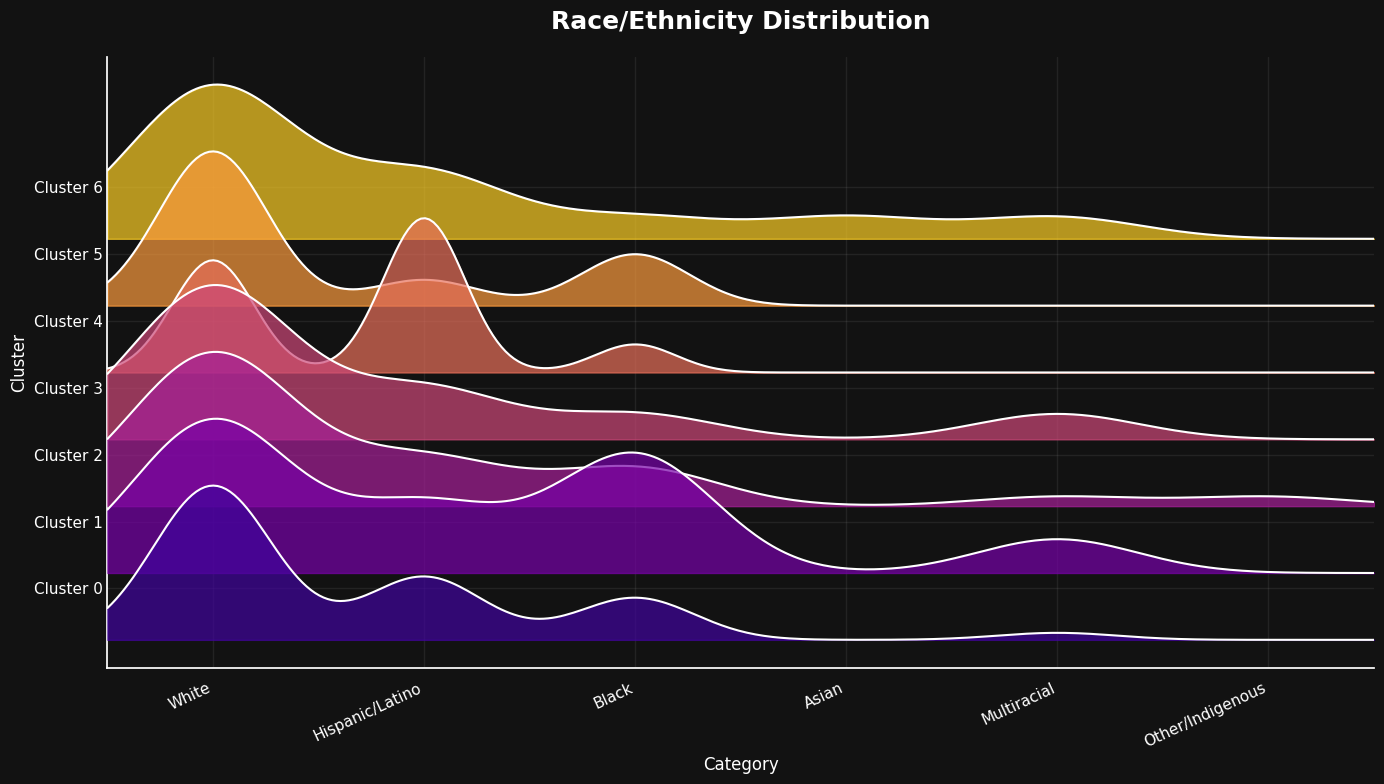

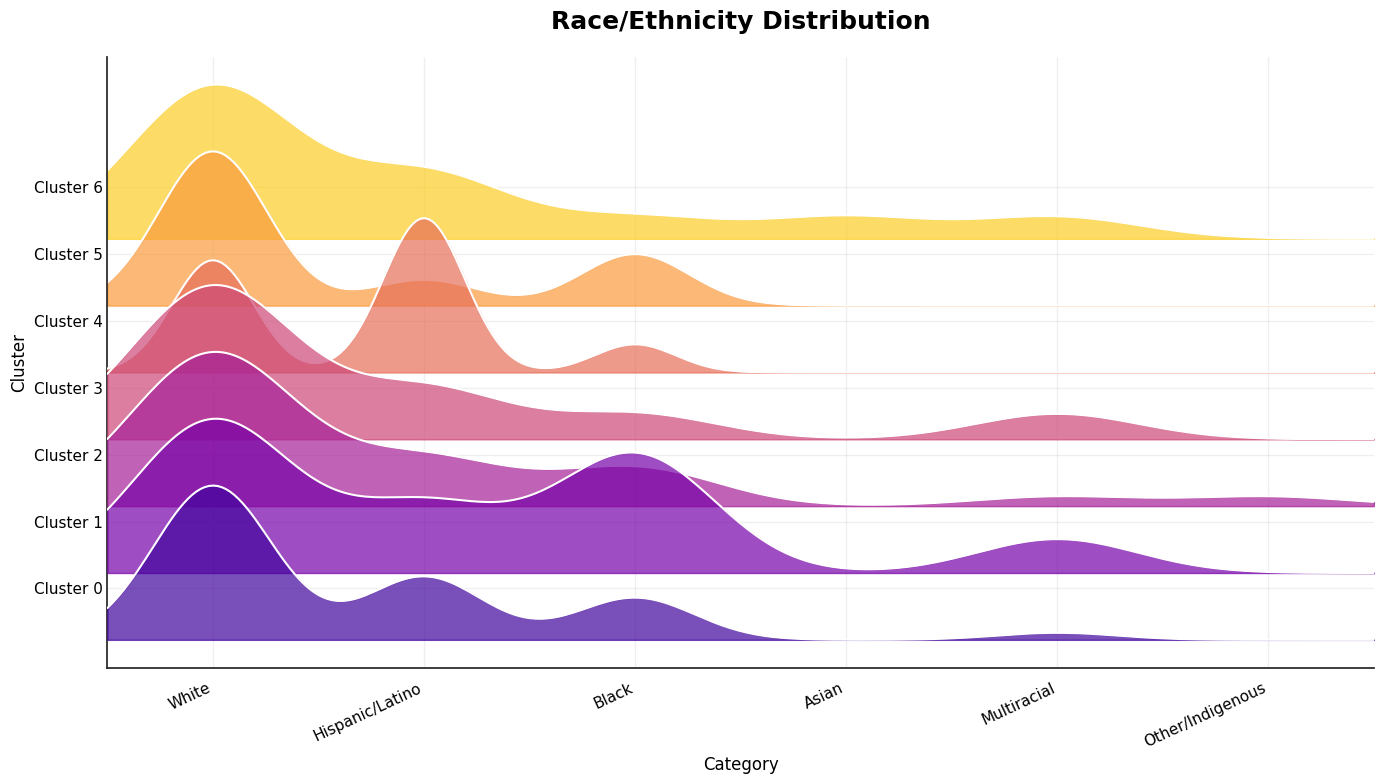

In [ ]:
# ==============================================================================
# Step 1: Install packages and Import
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
from sklearn.cluster import KMeans
from scipy import stats

print("="*80)
print("Custom Ridgeline Plot Generator")
print("="*80)

# ==============================================================================
# Step 2: Load Data and Perform Clustering
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '3factors-2.csv'
    demographic_data_path = 'original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data[['Response ID', 'Cluster']], demo_data, on='Response ID', how='inner')
print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)


# ==============================================================================
# Step 3: Create the Reusable Plotting Function (Based on Your Code)
# ==============================================================================
def create_custom_ridgeline(data, value_col, labels_dict, title, bandwidth_factor=0.3, dark_theme=True):
    """Create a custom ridgeline-style stacked area plot."""

    fig, ax = plt.subplots(figsize=(14, 8))
    clusters = sorted(data['Cluster'].unique())
    colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(clusters)))
    x_values = np.linspace(min(labels_dict.keys()) - 0.5, max(labels_dict.keys()) + 0.5, 300)

    vertical_spacing = 0.65
    amplitude_scale = 1.5

    all_distributions = []
    for i, cluster in enumerate(clusters):
        cluster_data = data[data['Cluster'] == cluster][value_col].dropna()
        if len(cluster_data) > 1:
            kde = stats.gaussian_kde(cluster_data, bw_method=bandwidth_factor)
            density = kde(x_values)
            density = density / max(density.max(), 0.001) * amplitude_scale
            y_baseline = i * vertical_spacing
            y_top = y_baseline + density
            all_distributions.append((y_baseline, y_top, colors[i], cluster))

    for y_baseline, y_top, color, cluster in all_distributions:
        ax.fill_between(x_values, y_baseline, y_top, color=color, alpha=0.7, zorder=(len(all_distributions) - cluster))
        ax.plot(x_values, y_top, color='white', linewidth=1.5, zorder=(len(all_distributions) - cluster) + 0.5)

    # --- Apply Theme ---
    if dark_theme:
        ax.set_facecolor('#121212')
        fig.patch.set_facecolor('#121212')
        text_color = 'white'
        ax.grid(True, alpha=0.15, color='#888888', linestyle='-')
        ax.spines['bottom'].set_color(text_color)
        ax.spines['left'].set_color(text_color)
    else: # Light Theme
        text_color = 'black'
        ax.grid(True, alpha=0.3, color='#cccccc', linestyle='-')

    # --- Formatting ---
    ax.set_title(title, fontsize=18, fontweight='bold', color=text_color, pad=20)
    ax.set_xlabel('Category', fontsize=12, color=text_color)
    ax.set_ylabel('Cluster', fontsize=12, color=text_color)
    ax.set_xlim(min(labels_dict.keys()) - 0.5, max(labels_dict.keys()) + 0.5)
    ax.set_xticks(list(labels_dict.keys()))
    ax.set_xticklabels(list(labels_dict.values()), rotation=25, ha='right')
    ax.tick_params(colors=text_color)

    # Y-axis labels for clusters
    y_tick_positions = [i * vertical_spacing + (amplitude_scale / 3) for i in range(len(clusters))]
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels([f'Cluster {c}' for c in clusters])
    ax.tick_params(axis='y', length=0) # Hide y-tick marks

    # Remove top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# ==============================================================================
# Step 4: Generate All Plots
# ==============================================================================

# --- 1. Difficulty Affording Health ---
print("\n--- Generating Plots for 'Difficulty Affording Health' ---")
afford_health_labels = {1: 'Very Difficult', 2: 'Somewhat Difficult', 3: 'Not Too Difficult', 4: 'Not at All Difficult'}
create_custom_ridgeline(merged_data, 'Q4.10', afford_health_labels, "Affordability Distribution", bandwidth_factor=0.15, dark_theme=True)
create_custom_ridgeline(merged_data, 'Q4.10', afford_health_labels, "Affordability Distribution", bandwidth_factor=0.15, dark_theme=False)

# --- 2. Education Level ---
print("\n--- Generating Plots for 'Education Level' ---")
education_labels = {1: 'K-8', 2: 'High School/GED', 3: 'College+'}
create_custom_ridgeline(merged_data, 'Q4.6', education_labels, "Education Level Distribution", bandwidth_factor=0.25, dark_theme=True)
create_custom_ridgeline(merged_data, 'Q4.6', education_labels, "Education Level Distribution", bandwidth_factor=0.25, dark_theme=False)

# --- 3. Employment Status ---
print("\n--- Generating Plots for 'Employment Status' ---")
employment_labels = {1: 'Employed Full-Time', 2: 'Employed Part-Time', 3: 'Seeking Work', 4: 'Not Working', 5: 'Retired'}
employment_order_map = {1: 1, 2: 2, 3: 3, 5: 4, 4: 5}
merged_data['employment_ordinal'] = merged_data['Q4.7'].map(employment_order_map)
create_custom_ridgeline(merged_data, 'employment_ordinal', employment_labels, "Employment Status Distribution", bandwidth_factor=0.3, dark_theme=True)
create_custom_ridgeline(merged_data, 'employment_ordinal', employment_labels, "Employment Status Distribution", bandwidth_factor=0.3, dark_theme=False)

# --- 4. Race / Ethnicity ---
print("\n--- Generating Plots for 'Race/Ethnicity' ---")
print("⚠️ WARNING: The order for Race/Ethnicity is artificial and for visualization purposes only.")
race_cols = ['Hispanic', 'Black', 'Asian', 'White', 'AmIn', 'MENA', 'Hawaiian', 'Other']
def assign_race_group(row):
    if row['Hispanic'] == 1: return 'Hispanic/Latino'
    # Count number of races selected
    num_races = sum(row[col] for col in race_cols if col != 'Hispanic')
    if num_races > 1: return 'Multiracial'
    if row['Black'] == 1: return 'Black'
    if row['Asian'] == 1: return 'Asian'
    if row['White'] == 1: return 'White'
    if num_races == 1: return 'Other/Indigenous' # Catches AmIn, MENA, Hawaiian, Other
    return 'Unknown'
merged_data['race_group'] = merged_data.apply(assign_race_group, axis=1)

# Create an artificial order for plotting
race_labels = {1: 'White', 2: 'Hispanic/Latino', 3: 'Black', 4: 'Asian', 5: 'Multiracial', 6: 'Other/Indigenous'}
race_order_map = {v: k for k, v in race_labels.items()}
merged_data['race_ordinal'] = merged_data['race_group'].map(race_order_map)

create_custom_ridgeline(merged_data, 'race_ordinal', race_labels, "Race/Ethnicity Distribution", bandwidth_factor=0.3, dark_theme=True)
create_custom_ridgeline(merged_data, 'race_ordinal', race_labels, "Race/Ethnicity Distribution", bandwidth_factor=0.3, dark_theme=False)

In [ ]:
import pandas as pd
df = pd.read_csv('original.csv')

In [ ]:
# prompt: df.columns()
#  to list

print(df.columns.tolist())


['Response ID', 'UserLanguage', 'Zip', 'County', 'years_address', 'HH_num', 'children_in_HH', 'phys_health', 'phys_recode', 'poor_phys', 'mental_health', 'mental_recode', 'poor_mental', 'chronic_cond_binary', 'quality_of_life', 'QOL_recode', 'poor_qol', 'score_healthstatus', 'mean_healthstatus', 'pregnant_binary', 'Q2.6_1', 'transport_insecure_binary', 'Q2.6_2', 'food_insecure_binary', 'foodinsecure_recode', 'Q2.6_3', 'house_insecure_binary', 'houseinsecure_recode', 'Q2.6_4', 'income_insecure_binary', 'Q2.7_1', 'unsafe_binary', 'unsafe_recode', 'Q2.7_2', 'difficulty_coping_binary', 'score_socialvuln', 'food_assistance', 'Q2.9', 'sought_care_recently', 'Q2.10', 'Q2.11', 'Q2.12', 'seeks_care_locally', 'Q2.13_1', 'Q2.13_2', 'Q2.13_3', 'Q2.13_4', 'Q2.13_5', 'Q2.13_5_TEXT', 'Q2.14_1', 'Q2.14_2', 'Q2.14_3', 'Q2.14_4', 'Q2.14_5', 'Q2.14_6', 'Q2.14_7', 'Q2.14_8', 'Q2.14_9', 'Q2.14_10', 'Q2.14_11', 'Q2.14_12', 'Q2.14_13', 'recode_Q2.14_1', 'recode_Q2.14_2', 'recode_Q2.14_3', 'recode_Q2.14_4', '

In [ ]:
df['Age'].value_counts()

Age
28    11
24     9
23     9
22     9
34     8
27     8
25     7
21     7
32     7
31     6
18     6
33     5
30     5
38     4
37     4
40     4
20     3
29     3
26     3
19     3
39     3
42     3
55     3
56     3
49     3
46     2
59     2
44     2
53     2
54     2
50     2
60     2
41     2
35     2
62     1
36     1
78     1
52     1
57     1
Name: count, dtype: int64

Custom Ridgeline Subplot Generator

Assuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.

Loading and processing data...
✓ Data loaded, clustered, and merged successfully.
--------------------------------------------------------------------------------
⚠️ WARNING: The order for Race/Ethnicity is artificial and for visualization purposes only.

--- Generating Dark Theme Figure ---


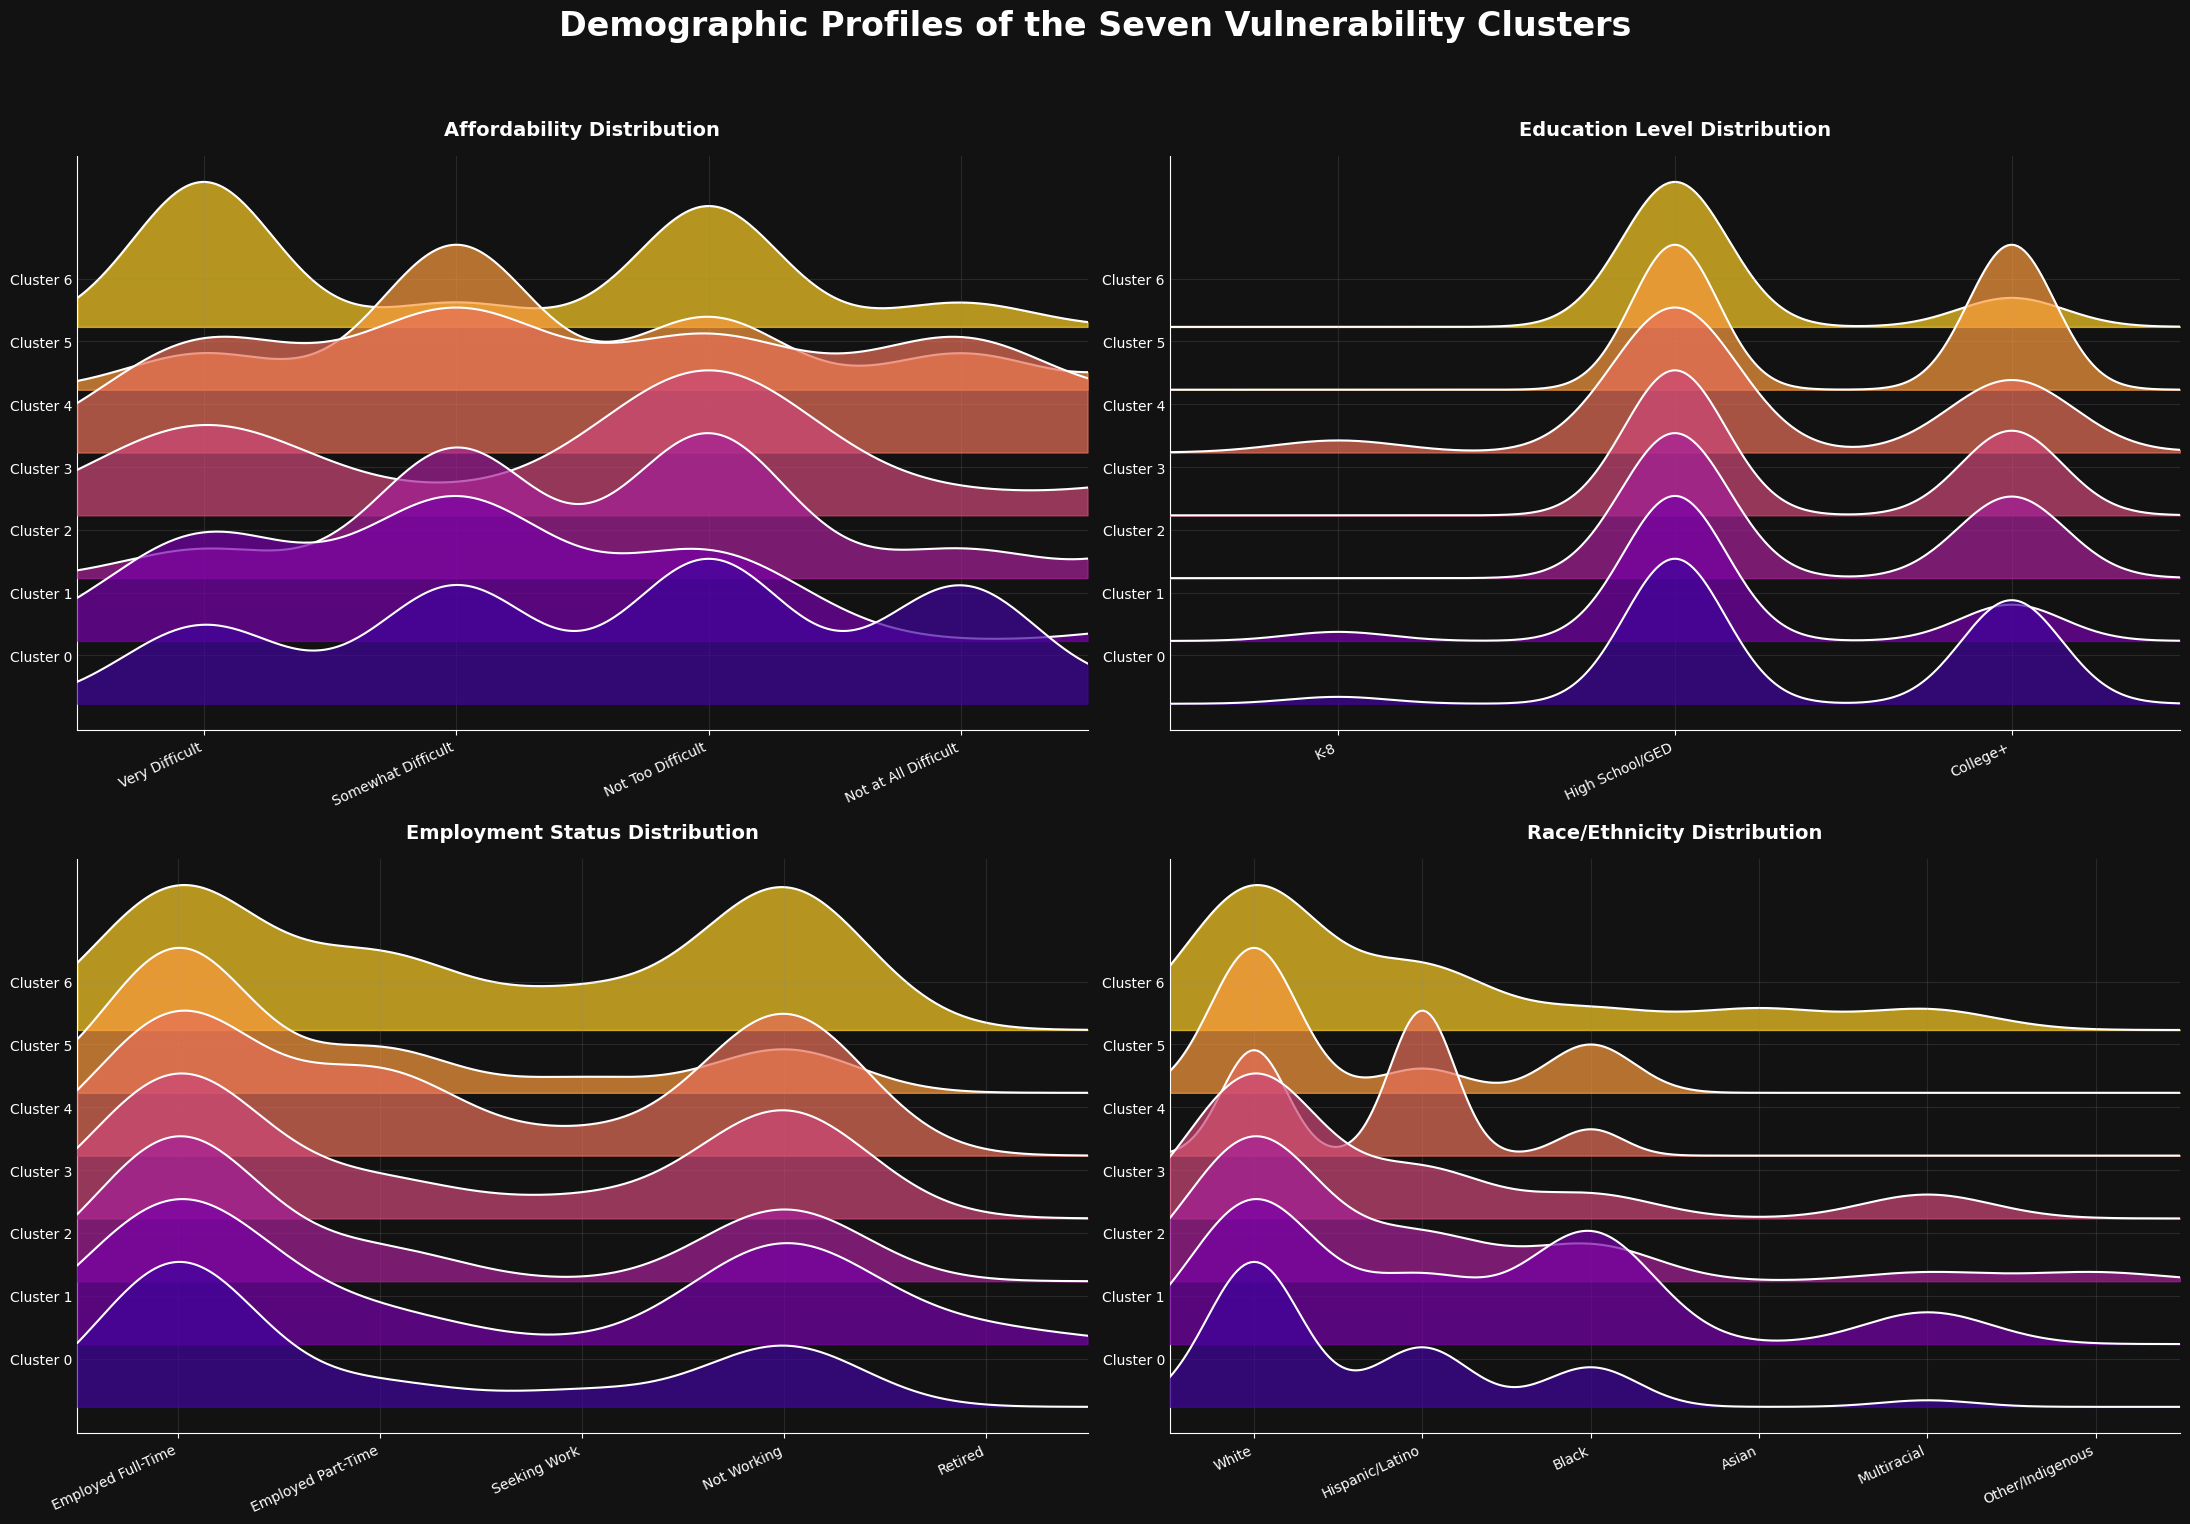


--- Generating Light Theme Figure ---


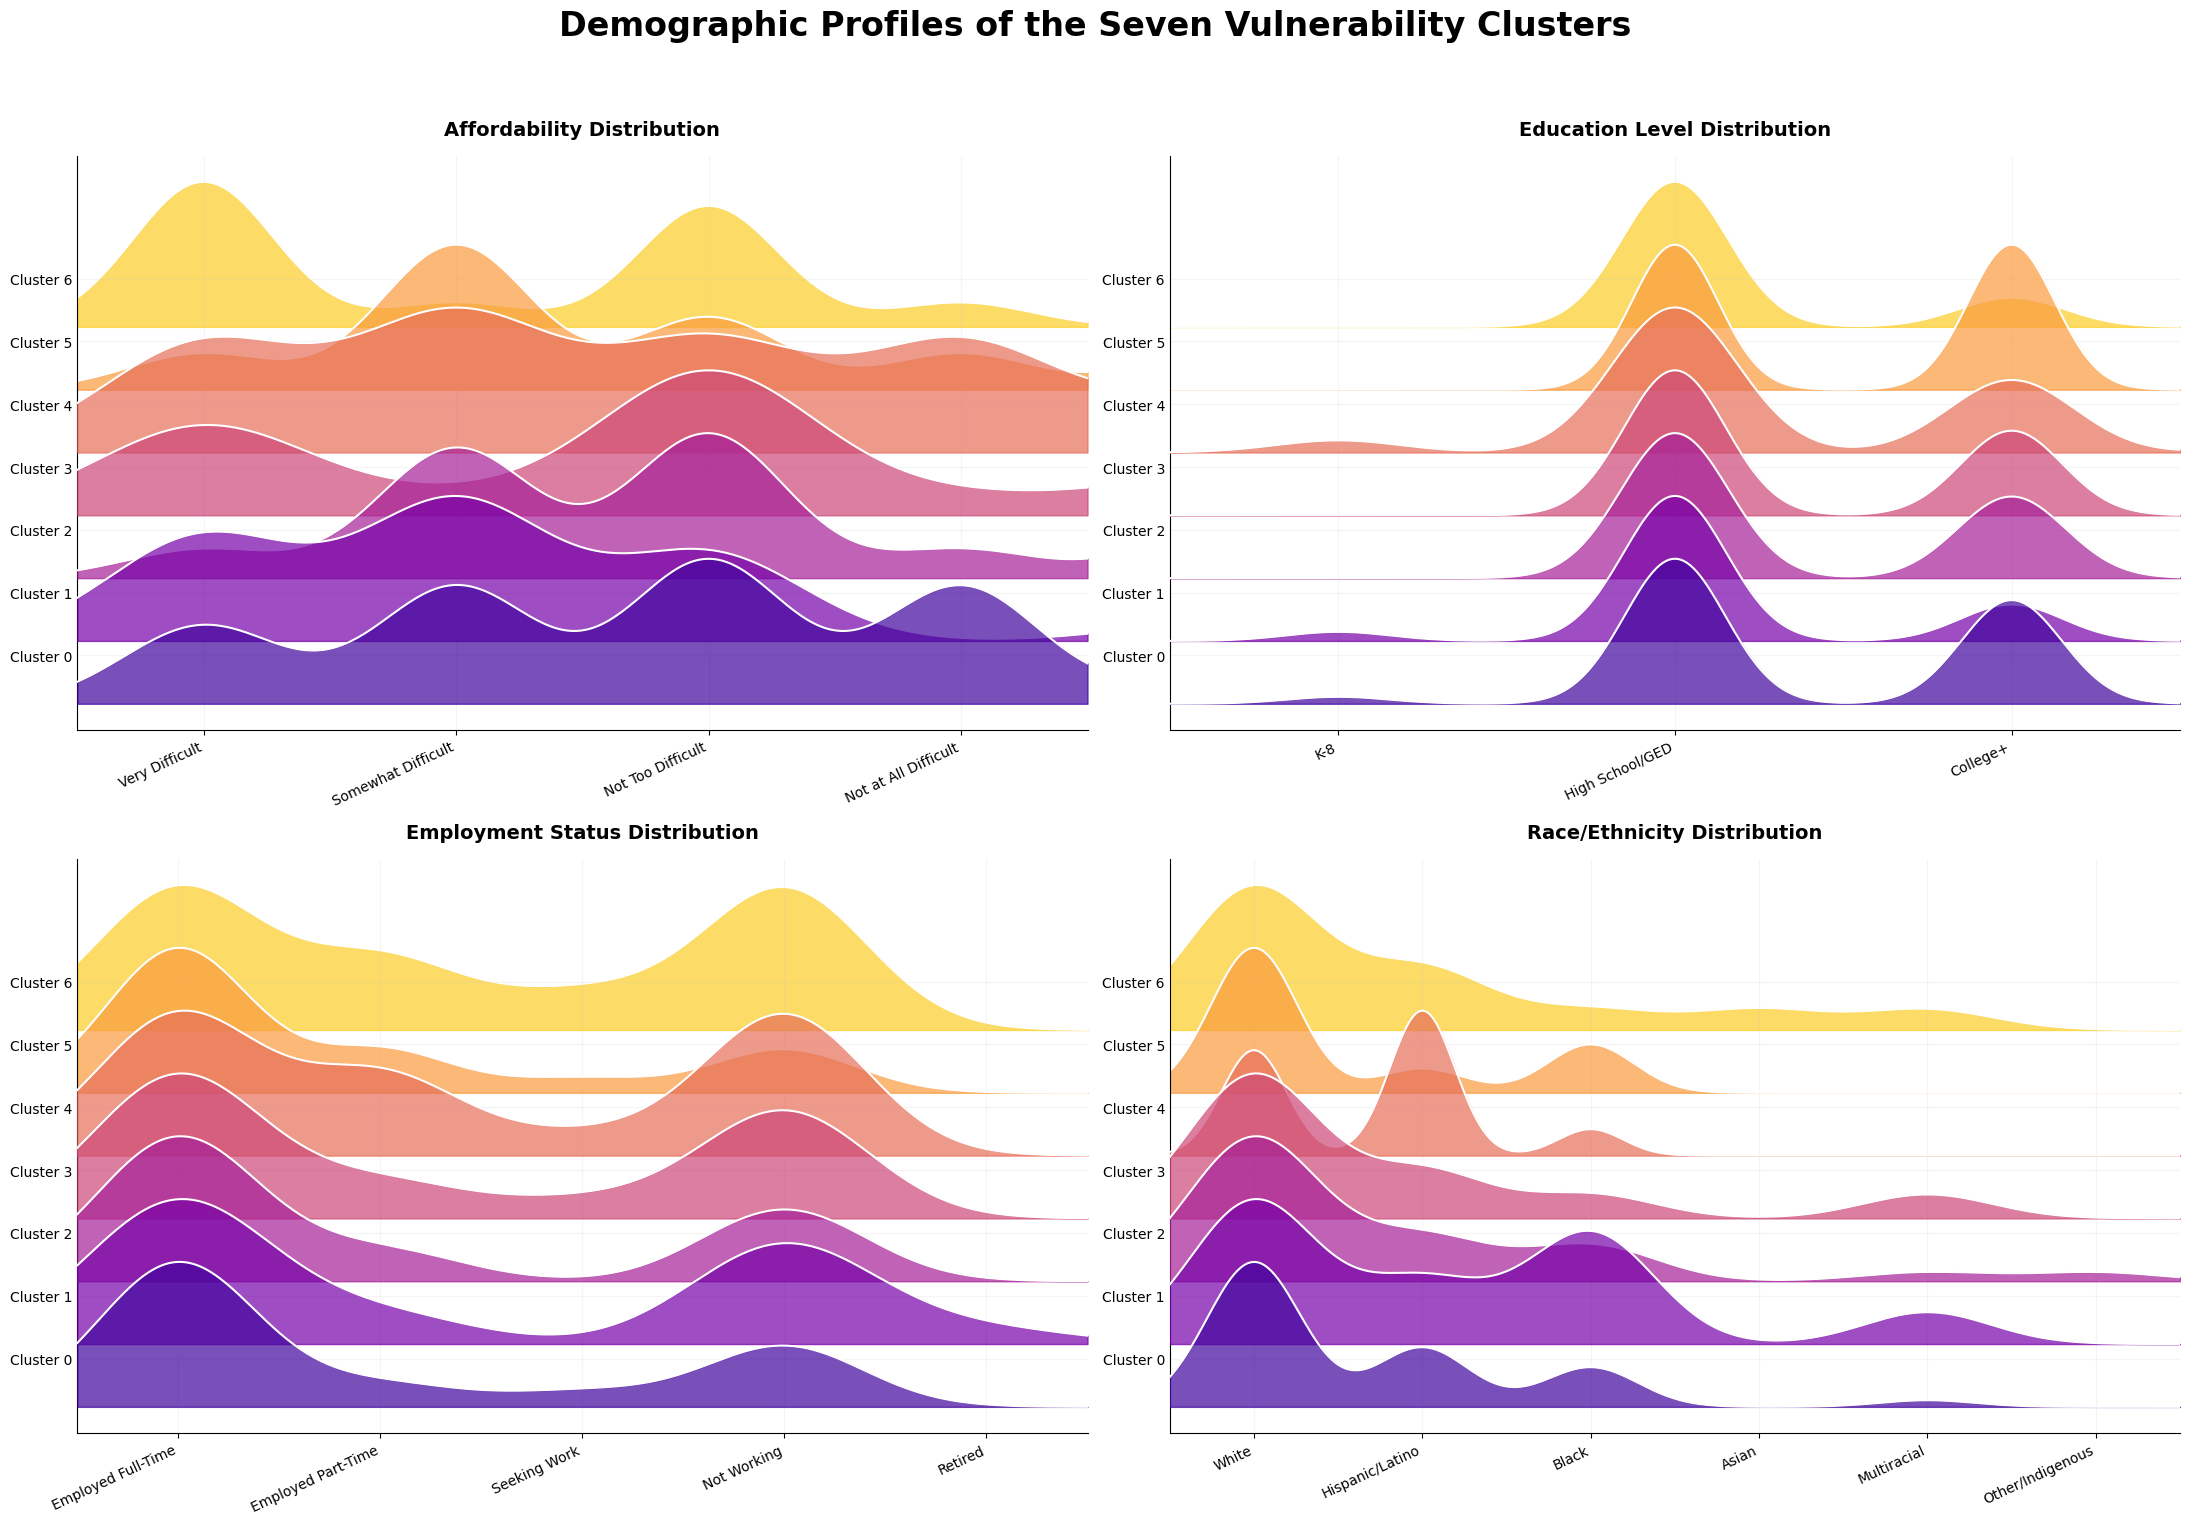

In [ ]:
# ==============================================================================
# Step 1: Install packages and Import
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
from sklearn.cluster import KMeans
from scipy import stats

print("="*80)
print("Custom Ridgeline Subplot Generator")
print("="*80)

# ==============================================================================
# Step 2: Load Data and Perform Clustering
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '3factors-2.csv'
    demographic_data_path = 'original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data[['Response ID', 'Cluster']], demo_data, on='Response ID', how='inner')
print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)

# ==============================================================================
# Step 3: Modify the Plotting Function to Draw on a Specific Subplot (ax)
# ==============================================================================
def draw_on_subplot(ax, data, value_col, labels_dict, title, bandwidth_factor=0.3, dark_theme=True):
    """Draws a custom ridgeline plot onto a given matplotlib subplot axis (ax)."""

    clusters = sorted(data['Cluster'].unique())
    colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(clusters)))
    x_values = np.linspace(min(labels_dict.keys()) - 0.5, max(labels_dict.keys()) + 0.5, 300)

    vertical_spacing = 0.65
    amplitude_scale = 1.5

    for i, cluster in enumerate(clusters):
        cluster_data = data[data['Cluster'] == cluster][value_col].dropna()
        if len(cluster_data) > 1:
            kde = stats.gaussian_kde(cluster_data, bw_method=bandwidth_factor)
            density = kde(x_values)
            density = density / max(density.max(), 0.001) * amplitude_scale
            y_baseline = i * vertical_spacing
            y_top = y_baseline + density
            ax.fill_between(x_values, y_baseline, y_top, color=colors[i], alpha=0.7, zorder=(len(clusters) - i))
            ax.plot(x_values, y_top, color='white', linewidth=1.5, zorder=(len(clusters) - i) + 0.5)

    # --- Apply Theme ---
    text_color = 'white' if dark_theme else 'black'
    grid_color = '#888888' if dark_theme else '#cccccc'
    face_color = '#121212' if dark_theme else 'white'

    ax.set_facecolor(face_color)
    ax.grid(True, alpha=0.2, color=grid_color, linestyle='-')
    ax.spines['bottom'].set_color(text_color)
    ax.spines['left'].set_color(text_color)

    # --- Formatting ---
    ax.set_title(title, fontsize=14, fontweight='bold', color=text_color, pad=15)
    ax.set_xlim(min(labels_dict.keys()) - 0.5, max(labels_dict.keys()) + 0.5)
    ax.set_xticks(list(labels_dict.keys()))
    ax.set_xticklabels(list(labels_dict.values()), rotation=25, ha='right')
    ax.tick_params(colors=text_color)

    y_tick_positions = [i * vertical_spacing + (amplitude_scale / 3) for i in range(len(clusters))]
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels([f'Cluster {c}' for c in clusters])
    ax.tick_params(axis='y', length=0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# ==============================================================================
# Step 4: Prepare Data for All Plots
# ==============================================================================
# --- Affordability Data ---
afford_health_labels = {1: 'Very Difficult', 2: 'Somewhat Difficult', 3: 'Not Too Difficult', 4: 'Not at All Difficult'}

# --- Education Data ---
education_labels = {1: 'K-8', 2: 'High School/GED', 3: 'College+'}

# --- Employment Data ---
employment_labels = {1: 'Employed Full-Time', 2: 'Employed Part-Time', 3: 'Seeking Work', 4: 'Not Working', 5: 'Retired'}
employment_order_map = {1: 1, 2: 2, 3: 3, 5: 4, 4: 5}
merged_data['employment_ordinal'] = merged_data['Q4.7'].map(employment_order_map)

# --- Race/Ethnicity Data ---
print("⚠️ WARNING: The order for Race/Ethnicity is artificial and for visualization purposes only.")
race_cols = ['Hispanic', 'Black', 'Asian', 'White', 'AmIn', 'MENA', 'Hawaiian', 'Other']
def assign_race_group(row):
    if row['Hispanic'] == 1: return 'Hispanic/Latino'
    num_races = sum(row[col] for col in race_cols if col != 'Hispanic')
    if num_races > 1: return 'Multiracial'
    if row['Black'] == 1: return 'Black'
    if row['Asian'] == 1: return 'Asian'
    if row['White'] == 1: return 'White'
    if num_races == 1: return 'Other/Indigenous'
    return 'Unknown'
merged_data['race_group'] = merged_data.apply(assign_race_group, axis=1)
race_labels = {1: 'White', 2: 'Hispanic/Latino', 3: 'Black', 4: 'Asian', 5: 'Multiracial', 6: 'Other/Indigenous'}
race_order_map = {v: k for k, v in race_labels.items()}
merged_data['race_ordinal'] = merged_data['race_group'].map(race_order_map)

# ==============================================================================
# Step 5: Generate the Dark Theme Figure with 4 Subplots
# ==============================================================================
print("\n--- Generating Dark Theme Figure ---")
fig_dark, axes_dark = plt.subplots(2, 2, figsize=(22, 16))
fig_dark.patch.set_facecolor('#121212')
fig_dark.suptitle('Demographic Profiles of the Seven Vulnerability Clusters', fontsize=24, fontweight='bold', color='white')

# Draw each plot on its respective subplot
draw_on_subplot(axes_dark[0, 0], merged_data, 'Q4.10', afford_health_labels, "Affordability Distribution", bandwidth_factor=0.25, dark_theme=True)
draw_on_subplot(axes_dark[0, 1], merged_data, 'Q4.6', education_labels, "Education Level Distribution", bandwidth_factor=0.25, dark_theme=True)
draw_on_subplot(axes_dark[1, 0], merged_data, 'employment_ordinal', employment_labels, "Employment Status Distribution", bandwidth_factor=0.3, dark_theme=True)
draw_on_subplot(axes_dark[1, 1], merged_data, 'race_ordinal', race_labels, "Race/Ethnicity Distribution", bandwidth_factor=0.3, dark_theme=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# ==============================================================================
# Step 6: Generate the Light Theme Figure with 4 Subplots
# ==============================================================================
print("\n--- Generating Light Theme Figure ---")
fig_light, axes_light = plt.subplots(2, 2, figsize=(22, 16))
fig_light.suptitle('Demographic Profiles of the Seven Vulnerability Clusters', fontsize=24, fontweight='bold', color='black')

# Draw each plot on its respective subplot
draw_on_subplot(axes_light[0, 0], merged_data, 'Q4.10', afford_health_labels, "Affordability Distribution", bandwidth_factor=0.25, dark_theme=False)
draw_on_subplot(axes_light[0, 1], merged_data, 'Q4.6', education_labels, "Education Level Distribution", bandwidth_factor=0.25, dark_theme=False)
draw_on_subplot(axes_light[1, 0], merged_data, 'employment_ordinal', employment_labels, "Employment Status Distribution", bandwidth_factor=0.3, dark_theme=False)
draw_on_subplot(axes_light[1, 1], merged_data, 'race_ordinal', race_labels, "Race/Ethnicity Distribution", bandwidth_factor=0.3, dark_theme=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Custom Ridgeline Subplot Generator

Assuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.

Loading and processing data...
✓ Data loaded, clustered, and merged successfully.
--------------------------------------------------------------------------------
⚠️ WARNING: The order for Race/Ethnicity is artificial and for visualization purposes only.

--- Generating Dark Theme Figure ---


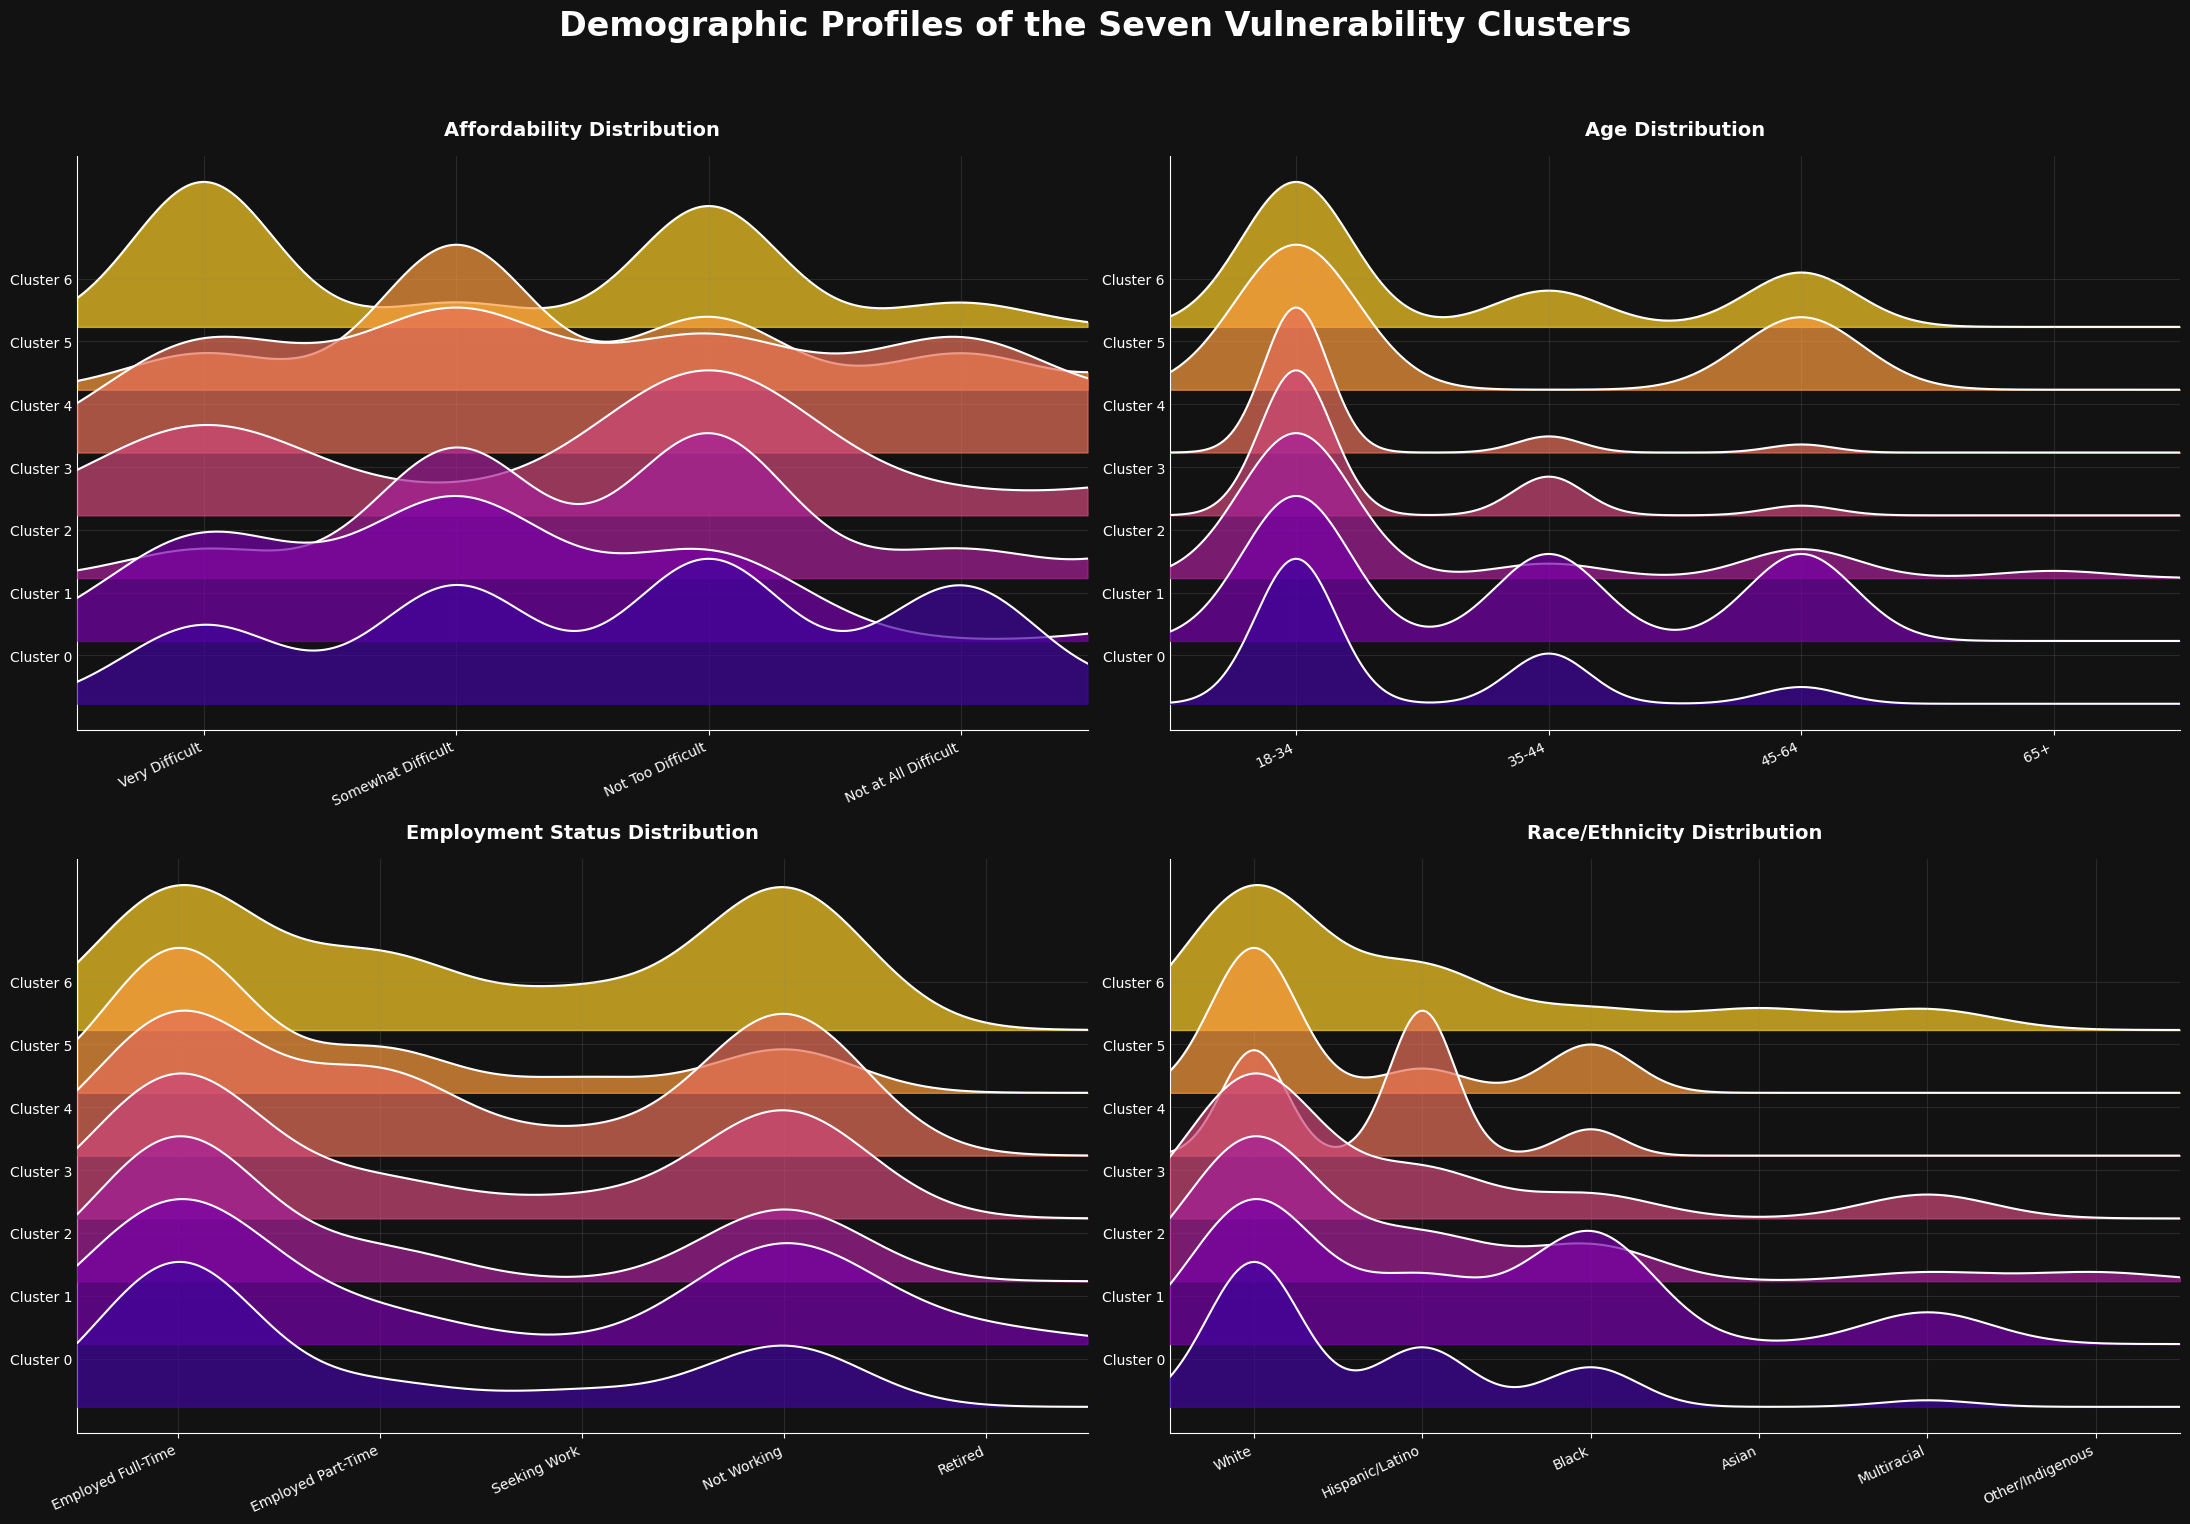


--- Generating Light Theme Figure ---


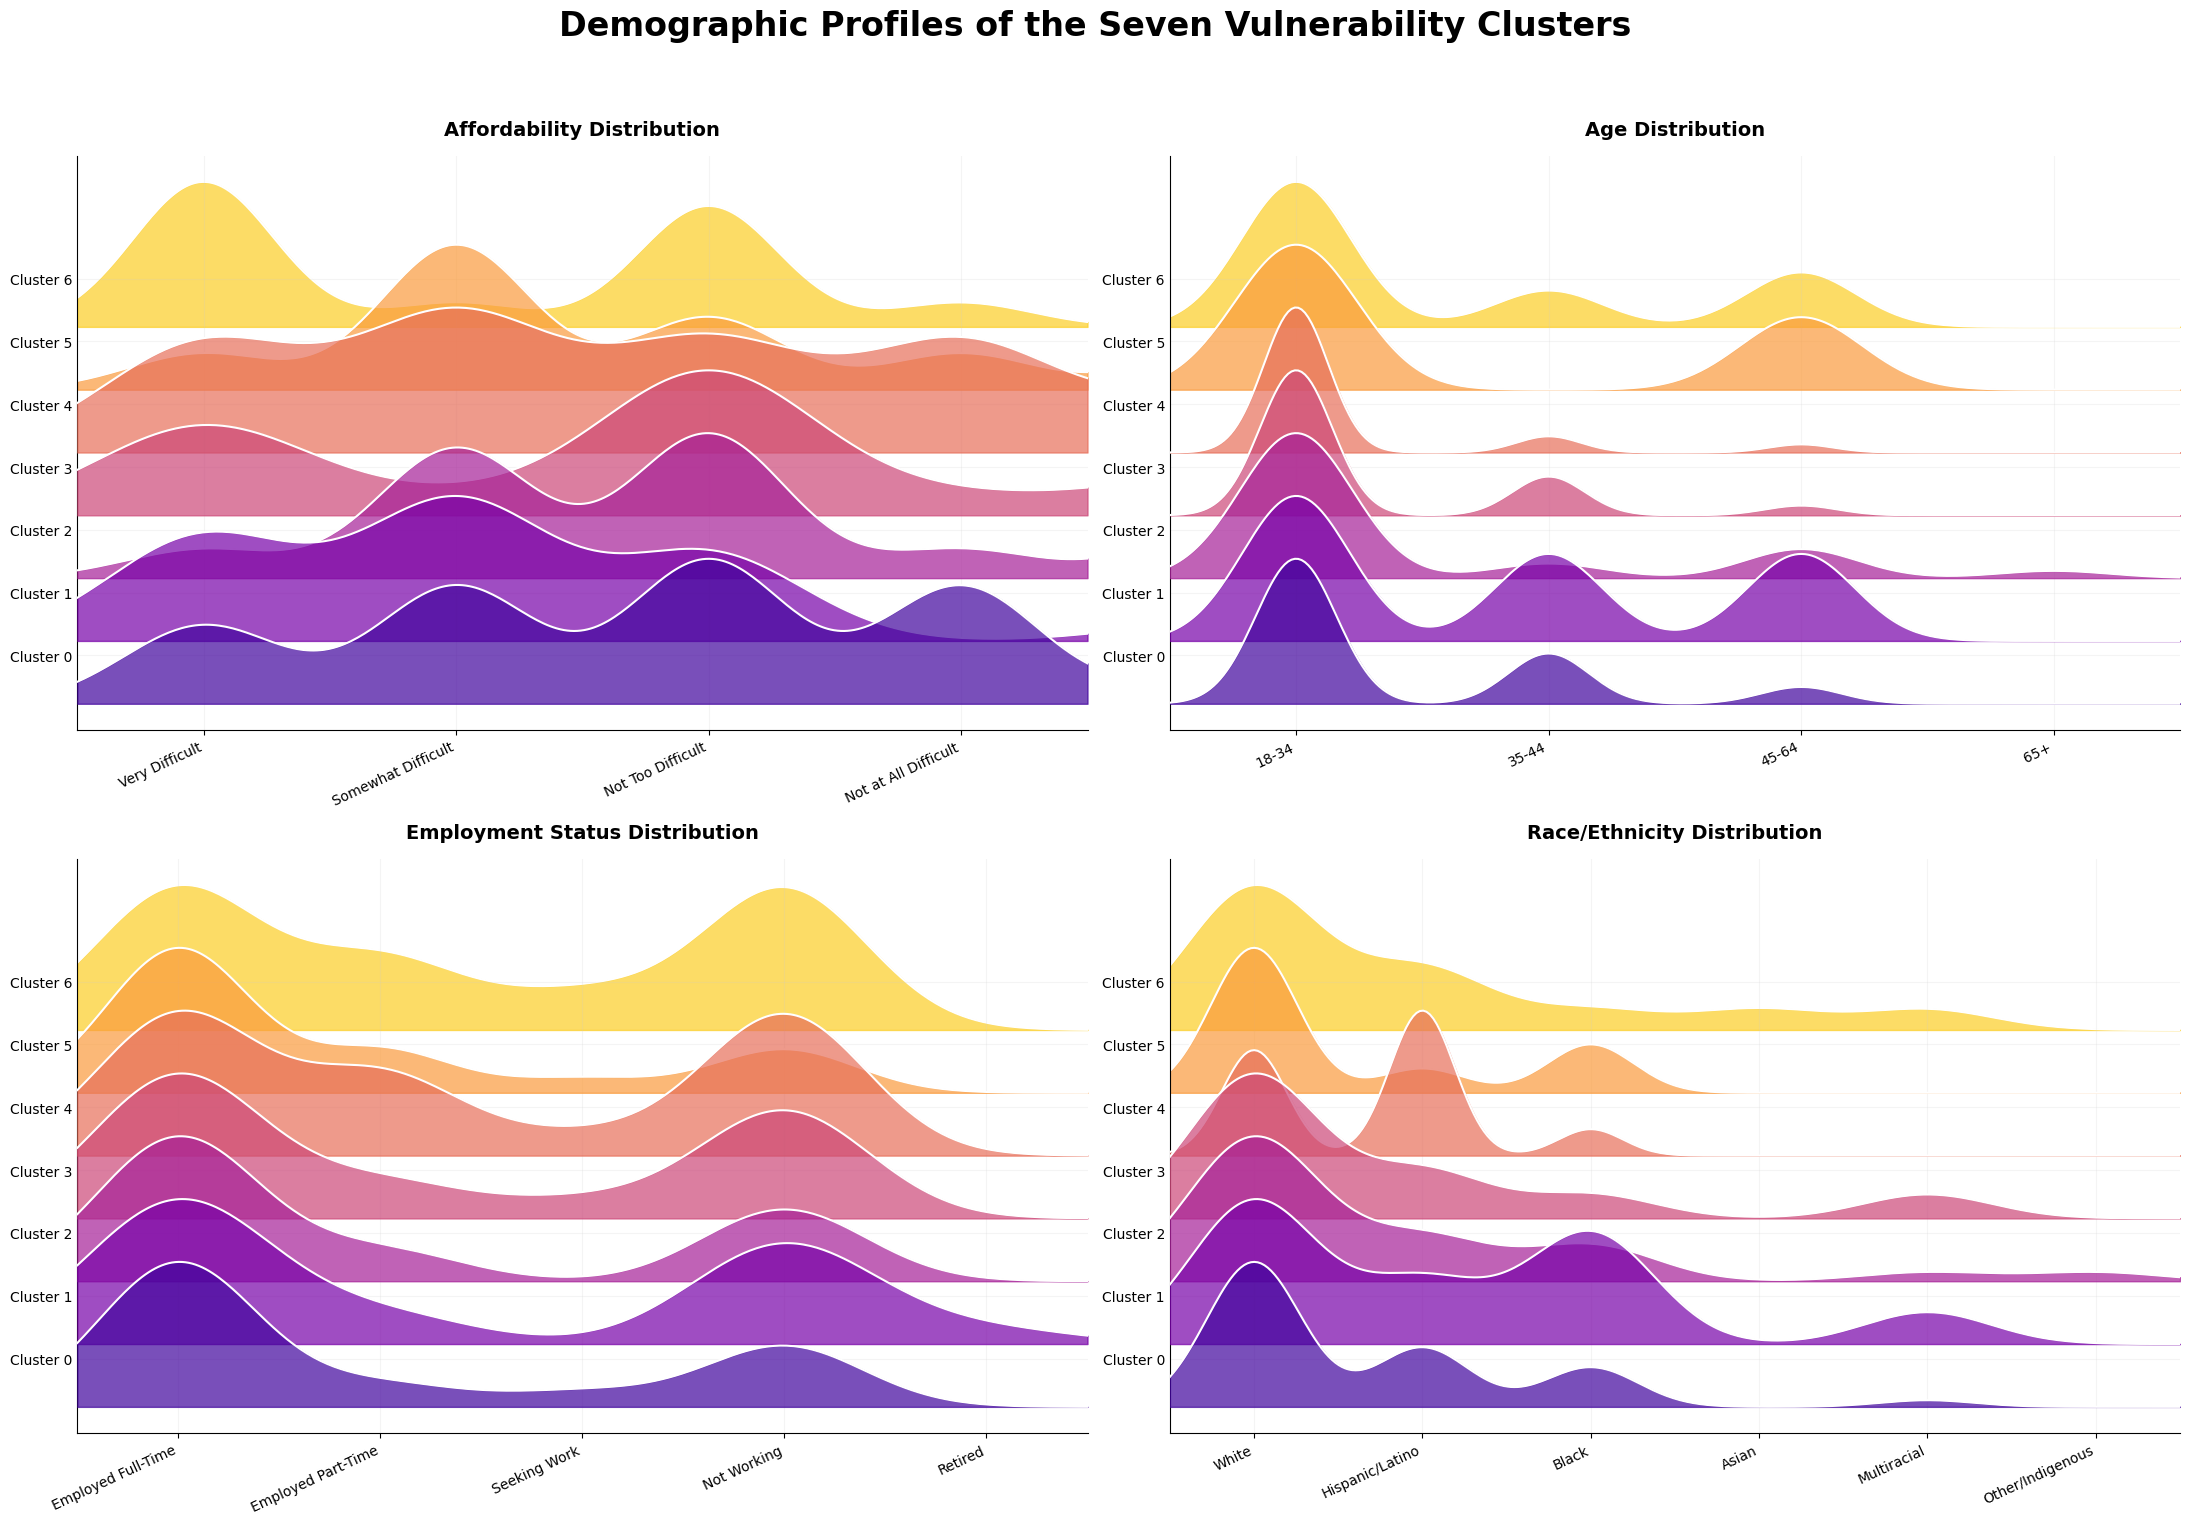

In [ ]:
# ==============================================================================
# Step 1: Install packages and Import
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
from sklearn.cluster import KMeans
from scipy import stats

print("="*80)
print("Custom Ridgeline Subplot Generator")
print("="*80)

# ==============================================================================
# Step 2: Load Data and Perform Clustering
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '3factors-2.csv'
    demographic_data_path = 'original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data[['Response ID', 'Cluster']], demo_data, on='Response ID', how='inner')
print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)

# ==============================================================================
# Step 3: Modify the Plotting Function to Draw on a Specific Subplot (ax)
# ==============================================================================
def draw_on_subplot(ax, data, value_col, labels_dict, title, bandwidth_factor=0.3, dark_theme=True):
    """Draws a custom ridgeline plot onto a given matplotlib subplot axis (ax)."""

    clusters = sorted(data['Cluster'].unique())
    colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(clusters)))
    x_values = np.linspace(min(labels_dict.keys()) - 0.5, max(labels_dict.keys()) + 0.5, 300)

    vertical_spacing = 0.65
    amplitude_scale = 1.5

    for i, cluster in enumerate(clusters):
        cluster_data = data[data['Cluster'] == cluster][value_col].dropna()
        if len(cluster_data) > 1:
            kde = stats.gaussian_kde(cluster_data, bw_method=bandwidth_factor)
            density = kde(x_values)
            density = density / max(density.max(), 0.001) * amplitude_scale
            y_baseline = i * vertical_spacing
            y_top = y_baseline + density
            ax.fill_between(x_values, y_baseline, y_top, color=colors[i], alpha=0.7, zorder=(len(clusters) - i))
            ax.plot(x_values, y_top, color='white', linewidth=1.5, zorder=(len(clusters) - i) + 0.5)

    # --- Apply Theme ---
    text_color = 'white' if dark_theme else 'black'
    grid_color = '#888888' if dark_theme else '#cccccc'
    face_color = '#121212' if dark_theme else 'white'

    ax.set_facecolor(face_color)
    ax.grid(True, alpha=0.2, color=grid_color, linestyle='-')
    ax.spines['bottom'].set_color(text_color)
    ax.spines['left'].set_color(text_color)

    # --- Formatting ---
    ax.set_title(title, fontsize=14, fontweight='bold', color=text_color, pad=15)
    ax.set_xlim(min(labels_dict.keys()) - 0.5, max(labels_dict.keys()) + 0.5)
    ax.set_xticks(list(labels_dict.keys()))
    ax.set_xticklabels(list(labels_dict.values()), rotation=25, ha='right')
    ax.tick_params(colors=text_color)

    y_tick_positions = [i * vertical_spacing + (amplitude_scale / 3) for i in range(len(clusters))]
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels([f'Cluster {c}' for c in clusters])
    ax.tick_params(axis='y', length=0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# ==============================================================================
# Step 4: Prepare Data for All Plots
# ==============================================================================
# --- Affordability Data ---
afford_health_labels = {1: 'Very Difficult', 2: 'Somewhat Difficult', 3: 'Not Too Difficult', 4: 'Not at All Difficult'}

# --- Education Data ---
age_column_name = 'Age'
bins = [17, 34, 44, 64, np.inf]
bin_labels_numeric = [1, 2, 3, 4]
merged_data['age_ordinal'] = pd.cut(merged_data[age_column_name], bins=bins, labels=bin_labels_numeric, right=True)
age_labels = {1: '18-34', 2: '35-44', 3: '45-64', 4: '65+'}
# --- Employment Data ---
employment_labels = {1: 'Employed Full-Time', 2: 'Employed Part-Time', 3: 'Seeking Work', 4: 'Not Working', 5: 'Retired'}
employment_order_map = {1: 1, 2: 2, 3: 3, 5: 4, 4: 5}
merged_data['employment_ordinal'] = merged_data['Q4.7'].map(employment_order_map)

# --- Race/Ethnicity Data ---
print("⚠️ WARNING: The order for Race/Ethnicity is artificial and for visualization purposes only.")
race_cols = ['Hispanic', 'Black', 'Asian', 'White', 'AmIn', 'MENA', 'Hawaiian', 'Other']
def assign_race_group(row):
    if row['Hispanic'] == 1: return 'Hispanic/Latino'
    num_races = sum(row[col] for col in race_cols if col != 'Hispanic')
    if num_races > 1: return 'Multiracial'
    if row['Black'] == 1: return 'Black'
    if row['Asian'] == 1: return 'Asian'
    if row['White'] == 1: return 'White'
    if num_races == 1: return 'Other/Indigenous'
    return 'Unknown'
merged_data['race_group'] = merged_data.apply(assign_race_group, axis=1)
race_labels = {1: 'White', 2: 'Hispanic/Latino', 3: 'Black', 4: 'Asian', 5: 'Multiracial', 6: 'Other/Indigenous'}
race_order_map = {v: k for k, v in race_labels.items()}
merged_data['race_ordinal'] = merged_data['race_group'].map(race_order_map)

# ==============================================================================
# Step 5: Generate the Dark Theme Figure with 4 Subplots
# ==============================================================================
print("\n--- Generating Dark Theme Figure ---")
fig_dark, axes_dark = plt.subplots(2, 2, figsize=(22, 16))
fig_dark.patch.set_facecolor('#121212')
fig_dark.suptitle('Demographic Profiles of the Seven Vulnerability Clusters', fontsize=24, fontweight='bold', color='white')

# Draw each plot on its respective subplot
draw_on_subplot(axes_dark[0, 0], merged_data, 'Q4.10', afford_health_labels, "Affordability Distribution", bandwidth_factor=0.25, dark_theme=True)
draw_on_subplot(axes_dark[0, 1], merged_data, 'age_ordinal', age_labels, "Age Distribution", bandwidth_factor=0.25, dark_theme=True)
draw_on_subplot(axes_dark[1, 0], merged_data, 'employment_ordinal', employment_labels, "Employment Status Distribution", bandwidth_factor=0.3, dark_theme=True)
draw_on_subplot(axes_dark[1, 1], merged_data, 'race_ordinal', race_labels, "Race/Ethnicity Distribution", bandwidth_factor=0.3, dark_theme=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# ==============================================================================
# Step 6: Generate the Light Theme Figure with 4 Subplots
# ==============================================================================
print("\n--- Generating Light Theme Figure ---")
fig_light, axes_light = plt.subplots(2, 2, figsize=(22, 16))
fig_light.suptitle('Demographic Profiles of the Seven Vulnerability Clusters', fontsize=24, fontweight='bold', color='black')

# Draw each plot on its respective subplot
draw_on_subplot(axes_light[0, 0], merged_data, 'Q4.10', afford_health_labels, "Affordability Distribution", bandwidth_factor=0.25, dark_theme=False)
draw_on_subplot(axes_light[0, 1], merged_data, 'age_ordinal', age_labels, "Age Distribution", bandwidth_factor=0.25, dark_theme=False)
draw_on_subplot(axes_light[1, 0], merged_data, 'employment_ordinal', employment_labels, "Employment Status Distribution", bandwidth_factor=0.3, dark_theme=False)
draw_on_subplot(axes_light[1, 1], merged_data, 'race_ordinal', race_labels, "Race/Ethnicity Distribution", bandwidth_factor=0.3, dark_theme=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# ==============================================================================
# Step 1: Install packages and Import
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
from sklearn.cluster import KMeans
from scipy import stats

print("="*80)
print("Custom Ridgeline Subplot Generator")
print("="*80)

plt.rcParams['figure.dpi'] = 300  # High resolution
plt.rcParams['savefig.dpi'] = 300  # High resolution for saving
plt.rcParams['font.size'] = 10    # Slightly smaller base font for crisp text
plt.rcParams['axes.linewidth'] = 0.8  # Thinner, crisper lines
plt.rcParams['grid.linewidth'] = 0.5
# ==============================================================================
# Step 2: Load Data and Perform Clustering
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '/content/drive/MyDrive/Downloads/3factors-2.csv'
    demographic_data_path = '/content/drive/MyDrive/WIC /original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    # Add exit() or raise an exception to stop execution
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data[['Response ID', 'Cluster']], demo_data, on='Response ID', how='inner')
print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)

# ==============================================================================
# Step 3: Modify the Plotting Function to Draw on a Specific Subplot (ax)
# ==============================================================================
def draw_on_subplot(ax, data, value_col, labels_dict, title, subplot_label, bandwidth_factor=0.3, dark_theme=True):
    """Draws a custom ridgeline plot onto a given matplotlib subplot axis (ax)."""

    clusters = sorted(data['Cluster'].unique())
    colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(clusters)))
    x_values = np.linspace(min(labels_dict.keys()) - 0.5, max(labels_dict.keys()) + 0.5, 300)

    vertical_spacing = 0.65
    amplitude_scale = 1.5

    for i, cluster in enumerate(clusters):
        cluster_data = data[data['Cluster'] == cluster][value_col].dropna()
        if len(cluster_data) > 1:
            kde = stats.gaussian_kde(cluster_data, bw_method=bandwidth_factor)
            density = kde(x_values)
            density = density / max(density.max(), 0.001) * amplitude_scale
            y_baseline = i * vertical_spacing
            y_top = y_baseline + density
            ax.fill_between(x_values, y_baseline, y_top, color=colors[i], alpha=0.7, zorder=(len(clusters) - i))
            ax.plot(x_values, y_top, color='white', linewidth=1.5, zorder=(len(clusters) - i) + 0.5)

    # --- Apply Theme ---
    text_color = 'white' if dark_theme else 'black'
    grid_color = '#888888' if dark_theme else '#cccccc'
    face_color = '#121212' if dark_theme else 'white'

    ax.set_facecolor(face_color)
    ax.grid(True, alpha=0.2, color=grid_color, linestyle='-')
    ax.spines['bottom'].set_color(text_color)
    ax.spines['left'].set_color(text_color)

    # --- Formatting ---
    ax.set_title(title, fontsize=14, fontweight='bold', color=text_color, pad=15)
    ax.set_xlim(min(labels_dict.keys()) - 0.5, max(labels_dict.keys()) + 0.5)
    ax.set_xticks(list(labels_dict.keys()))
    ax.set_xticklabels(list(labels_dict.values()), rotation=25, ha='right')
    ax.tick_params(colors=text_color)

    y_tick_positions = [i * vertical_spacing + (amplitude_scale / 3) for i in range(len(clusters))]
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels([f'Cluster {c}' for c in clusters])
    ax.tick_params(axis='y', length=0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # --- Add Subplot Label (a, b, c, d) ---
    # This text is positioned relative to the axes area to place it underneath.
    ax.text(0.5, -0.35, subplot_label, transform=ax.transAxes,
            ha='center', va='center', fontsize=18, fontweight='bold', color=text_color)

# ==============================================================================
# Step 4: Prepare Data for All Plots
# ==============================================================================
# --- Affordability Data ---
afford_health_labels = {1: 'Very Difficult', 2: 'Somewhat Difficult', 3: 'Not Too Difficult', 4: 'Not at All Difficult'}

# --- Education Data ---
age_column_name = 'Age'
bins = [17, 34, 44, 64, np.inf]
bin_labels_numeric = [1, 2, 3, 4]
merged_data['age_ordinal'] = pd.cut(merged_data[age_column_name], bins=bins, labels=bin_labels_numeric, right=True)
age_labels = {1: '18-34', 2: '35-44', 3: '45-64', 4: '65+'}
# --- Employment Data ---
employment_labels = {1: 'Employed Full-Time', 2: 'Employed Part-Time', 3: 'Seeking Work', 4: 'Not Working', 5: 'Retired'}
employment_order_map = {1: 1, 2: 2, 3: 3, 5: 4, 4: 5}
merged_data['employment_ordinal'] = merged_data['Q4.7'].map(employment_order_map)

# --- Race/Ethnicity Data ---
print("⚠️ WARNING: The order for Race/Ethnicity is artificial and for visualization purposes only.")
race_cols = ['Hispanic', 'Black', 'Asian', 'White', 'AmIn', 'MENA', 'Hawaiian', 'Other']
def assign_race_group(row):
    if row['Hispanic'] == 1: return 'Hispanic/Latino'
    num_races = sum(row[col] for col in race_cols if col != 'Hispanic')
    if num_races > 1: return 'Multiracial'
    if row['Black'] == 1: return 'Black'
    if row['Asian'] == 1: return 'Asian'
    if row['White'] == 1: return 'White'
    if num_races == 1: return 'Other/Indigenous'
    return 'Unknown'
merged_data['race_group'] = merged_data.apply(assign_race_group, axis=1)
race_labels = {1: 'White', 2: 'Hispanic/Latino', 3: 'Black', 4: 'Asian', 5: 'Multiracial', 6: 'Other/Indigenous'}
race_order_map = {v: k for k, v in race_labels.items()}
merged_data['race_ordinal'] = merged_data['race_group'].map(race_order_map)

# ==============================================================================
# Step 5: Generate the Dark Theme Figure with 4 Subplots
# ==============================================================================
print("\n--- Generating Dark Theme Figure ---")
fig_dark, axes_dark = plt.subplots(2, 2, figsize=(22, 16))
fig_dark.patch.set_facecolor('#121212')
fig_dark.suptitle('Demographic Profiles of the Seven Vulnerability Clusters', fontsize=24, fontweight='bold', color='white')

# Draw each plot on its respective subplot, now including the subplot_label
draw_on_subplot(axes_dark[0, 0], merged_data, 'Q4.10', afford_health_labels, "Affordability Distribution", subplot_label='(a)', bandwidth_factor=0.25, dark_theme=True)
draw_on_subplot(axes_dark[0, 1], merged_data, 'age_ordinal', age_labels, "Age Distribution", subplot_label = '(b)', bandwidth_factor=0.25, dark_theme=True)
draw_on_subplot(axes_dark[1, 0], merged_data, 'employment_ordinal', employment_labels, "Employment Status Distribution", subplot_label='(c)', bandwidth_factor=0.3, dark_theme=True)
draw_on_subplot(axes_dark[1, 1], merged_data, 'race_ordinal', race_labels, "Race/Ethnicity Distribution", subplot_label='(d)', bandwidth_factor=0.3, dark_theme=True)

# Adjust layout to make room for the suptitle and new subplot labels
plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=4)
plt.savefig('demographic_profiles_dark.png') # Save the dark theme figure
plt.show()


# ==============================================================================
# Step 6: Generate the Light Theme Figure with 4 Subplots
# ==============================================================================
print("\n--- Generating Light Theme Figure ---")
fig_light, axes_light = plt.subplots(2, 2, figsize=(22, 16))
fig_light.suptitle('Demographic Profiles of the Seven Vulnerability Clusters', fontsize=24, fontweight='bold', color='black')

# Draw each plot on its respective subplot, now including the subplot_label
draw_on_subplot(axes_light[0, 0], merged_data, 'Q4.10', afford_health_labels, "Affordability Distribution", subplot_label='(a)', bandwidth_factor=0.25, dark_theme=False)
draw_on_subplot(axes_light[0, 1], merged_data, 'age_ordinal', age_labels, "Age Distribution", subplot_label='(b)' , bandwidth_factor=0.25, dark_theme=False)
draw_on_subplot(axes_light[1, 0], merged_data, 'employment_ordinal', employment_labels, "Employment Status Distribution", subplot_label='(c)', bandwidth_factor=0.3, dark_theme=False)
draw_on_subplot(axes_light[1, 1], merged_data, 'race_ordinal', race_labels, "Race/Ethnicity Distribution", subplot_label='(d)', bandwidth_factor=0.3, dark_theme=False)

# Adjust layout to make room for the suptitle and new subplot labels
plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=0.5)
plt.savefig('demographic_profiles_light.png') # Save the light theme figure
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Custom Ridgeline Subplot Generator

Assuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.

Loading and processing data...
✓ Data loaded, clustered, and merged successfully.
--------------------------------------------------------------------------------
⚠️ WARNING: The order for Race/Ethnicity is artificial and for visualization purposes only.

--- Generating Light Theme Figure ---


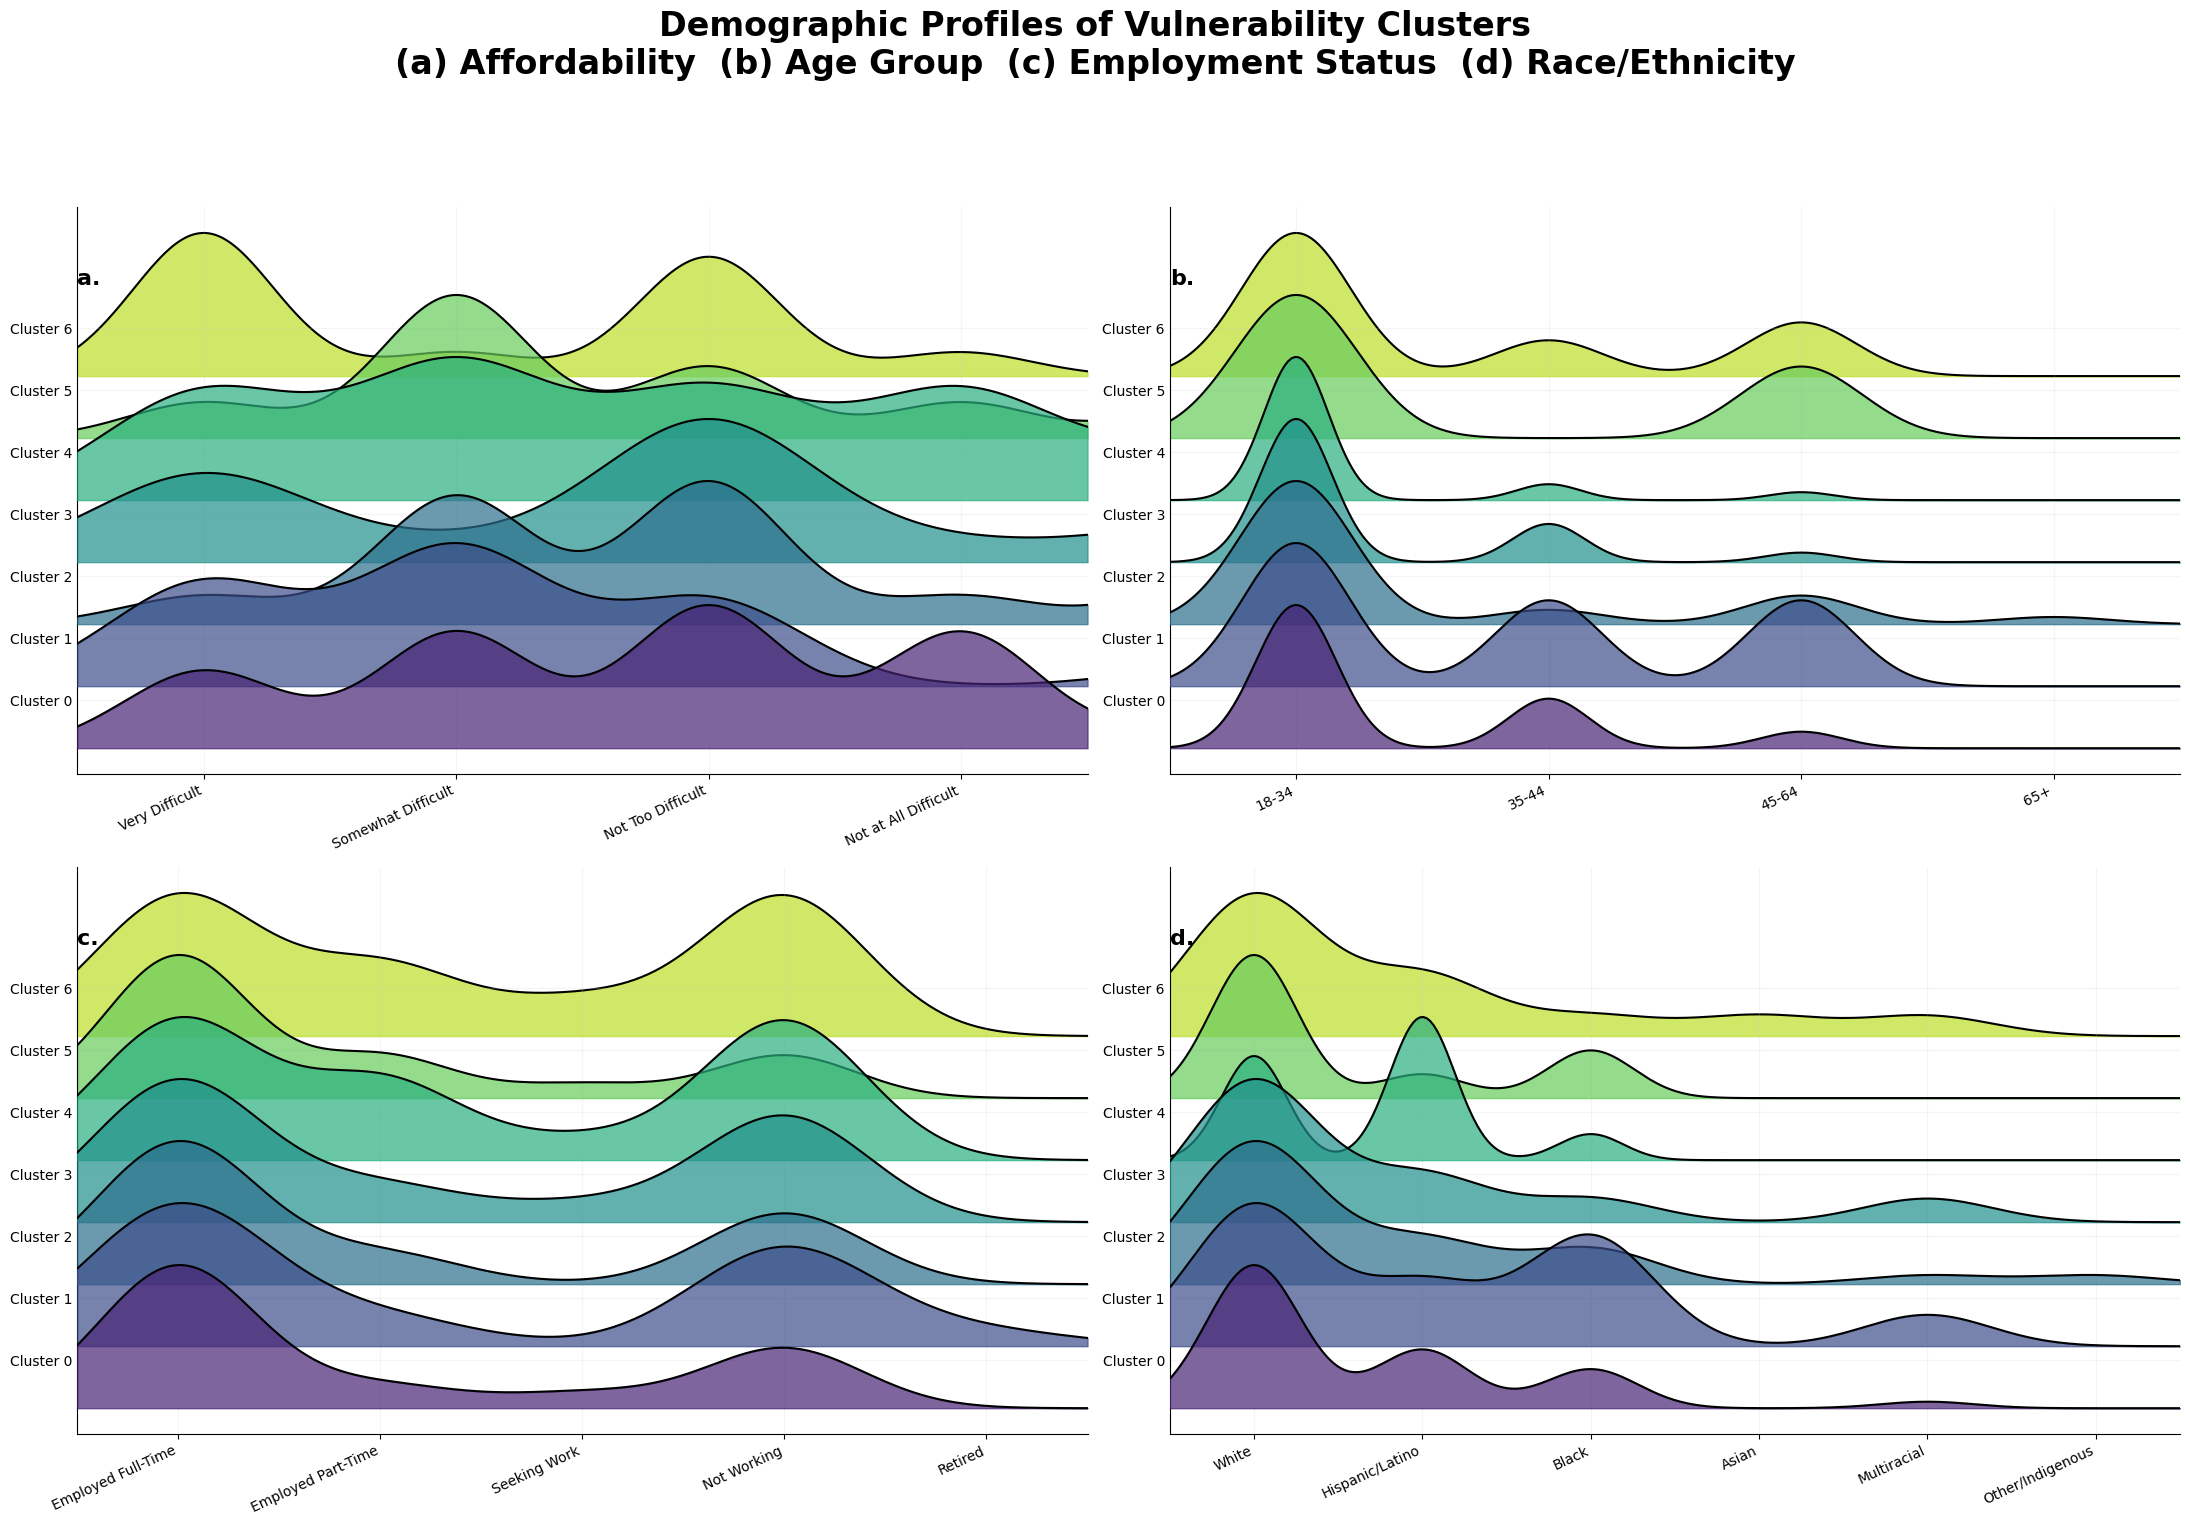

In [ ]:
# ==============================================================================
# Step 1: Install packages and Import
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
from sklearn.cluster import KMeans
from scipy import stats

print("="*80)
print("Custom Ridgeline Subplot Generator")
print("="*80)

# ==============================================================================
# Step 2: Load Data and Perform Clustering
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '3factors-2.csv'
    demographic_data_path = 'original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data[['Response ID', 'Cluster']], demo_data, on='Response ID', how='inner')
print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)

# ==============================================================================
# Step 3: Modify the Plotting Function to Draw on a Specific Subplot (ax)
# ==============================================================================
def draw_on_subplot(ax, data, value_col, labels_dict, title, bandwidth_factor=0.3, dark_theme=True):
    """Draws a custom ridgeline plot onto a given matplotlib subplot axis (ax)."""

    clusters = sorted(data['Cluster'].unique())
    # Use a color palette that works well for both light and dark themes
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(clusters)))
    x_values = np.linspace(min(labels_dict.keys()) - 0.5, max(labels_dict.keys()) + 0.5, 300)

    vertical_spacing = 0.65
    amplitude_scale = 1.5

    for i, cluster in enumerate(clusters):
        cluster_data = data[data['Cluster'] == cluster][value_col].dropna()
        if len(cluster_data) > 1:
            kde = stats.gaussian_kde(cluster_data, bw_method=bandwidth_factor)
            density = kde(x_values)
            density = density / max(density.max(), 0.001) * amplitude_scale
            y_baseline = i * vertical_spacing
            y_top = y_baseline + density
            ax.fill_between(x_values, y_baseline, y_top, color=colors[i], alpha=0.7, zorder=(len(clusters) - i))
            ax.plot(x_values, y_top, color='white' if dark_theme else 'black', linewidth=1.5, zorder=(len(clusters) - i) + 0.5)

    # --- Apply Theme ---
    text_color = 'white' if dark_theme else 'black'
    grid_color = '#888888' if dark_theme else '#cccccc'
    face_color = '#121212' if dark_theme else 'white'

    ax.set_facecolor(face_color)
    ax.grid(True, alpha=0.2, color=grid_color, linestyle='-')
    ax.spines['bottom'].set_color(text_color)
    ax.spines['left'].set_color(text_color)

    # --- Formatting ---
    # Set title with specific font properties for a,b,c,d labels
    ax.set_title(title, fontsize=16, fontweight='bold', color=text_color, loc='left', y=0.9, pad=-15)
    ax.set_xlim(min(labels_dict.keys()) - 0.5, max(labels_dict.keys()) + 0.5)
    ax.set_xticks(list(labels_dict.keys()))
    ax.set_xticklabels(list(labels_dict.values()), rotation=25, ha='right')
    ax.tick_params(colors=text_color)

    y_tick_positions = [i * vertical_spacing + (amplitude_scale / 3) for i in range(len(clusters))]
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels([f'Cluster {c}' for c in clusters])
    ax.tick_params(axis='y', length=0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# ==============================================================================
# Step 4: Prepare Data for All Plots
# ==============================================================================
# --- Affordability Data ---
afford_health_labels = {1: 'Very Difficult', 2: 'Somewhat Difficult', 3: 'Not Too Difficult', 4: 'Not at All Difficult'}

# --- Age Data ---
# NOTE: Assuming the 'age' column is named 'Q4.2' in your 'original.csv' file.
# Please change 'Q4.2' if your age column has a different name.
age_column_name = 'Age'
bins = [17, 34, 44, 64, np.inf]
bin_labels_numeric = [1, 2, 3, 4]
merged_data['age_ordinal'] = pd.cut(merged_data[age_column_name], bins=bins, labels=bin_labels_numeric, right=True)
age_labels = {1: '18-34', 2: '35-44', 3: '45-64', 4: '65+'}

# --- Employment Data ---
employment_labels = {1: 'Employed Full-Time', 2: 'Employed Part-Time', 3: 'Seeking Work', 4: 'Not Working', 5: 'Retired'}
employment_order_map = {1: 1, 2: 2, 3: 3, 5: 4, 4: 5}
merged_data['employment_ordinal'] = merged_data['Q4.7'].map(employment_order_map)

# --- Race/Ethnicity Data ---
print("⚠️ WARNING: The order for Race/Ethnicity is artificial and for visualization purposes only.")
race_cols = ['Hispanic', 'Black', 'Asian', 'White', 'AmIn', 'MENA', 'Hawaiian', 'Other']
def assign_race_group(row):
    if row['Hispanic'] == 1: return 'Hispanic/Latino'
    num_races = sum(row[col] for col in race_cols if col != 'Hispanic')
    if num_races > 1: return 'Multiracial'
    if row['Black'] == 1: return 'Black'
    if row['Asian'] == 1: return 'Asian'
    if row['White'] == 1: return 'White'
    if num_races == 1: return 'Other/Indigenous'
    return 'Unknown'
merged_data['race_group'] = merged_data.apply(assign_race_group, axis=1)
race_labels = {1: 'White', 2: 'Hispanic/Latino', 3: 'Black', 4: 'Asian', 5: 'Multiracial', 6: 'Other/Indigenous'}
race_order_map = {v: k for k, v in race_labels.items()}
merged_data['race_ordinal'] = merged_data['race_group'].map(race_order_map)

# ==============================================================================
# Step 5: Generate the Light Theme Figure with 4 Subplots
# ==============================================================================
print("\n--- Generating Light Theme Figure ---")
fig_light, axes_light = plt.subplots(2, 2, figsize=(22, 16))
# Updated main title to reference the subplots
fig_light.suptitle(
    'Demographic Profiles of Vulnerability Clusters\n(a) Affordability  (b) Age Group  (c) Employment Status  (d) Race/Ethnicity',
    fontsize=24, fontweight='bold', color='black'
)


# Draw each plot on its respective subplot with the new labels
draw_on_subplot(axes_light[0, 0], merged_data, 'Q4.10', afford_health_labels, "a.", bandwidth_factor=0.25, dark_theme=False)
draw_on_subplot(axes_light[0, 1], merged_data, 'age_ordinal', age_labels, "b.", bandwidth_factor=0.25, dark_theme=False)
draw_on_subplot(axes_light[1, 0], merged_data, 'employment_ordinal', employment_labels, "c.", bandwidth_factor=0.3, dark_theme=False)
draw_on_subplot(axes_light[1, 1], merged_data, 'race_ordinal', race_labels, "d.", bandwidth_factor=0.3, dark_theme=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.92]) # Adjust rect to make space for the new suptitle
plt.show()

In [ ]:
# ==============================================================================
# Step 1: Import Packages
# ==============================================================================
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px # Import plotly.express
from google.colab import files
from sklearn.cluster import KMeans

print("="*80)
print("3D Cluster Visualization Generator")
print("="*80)

# ==============================================================================
# Step 2: Load Data and Perform Clustering
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '3factors-2.csv'
    demographic_data_path = 'original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data, demo_data, on='Response ID', how='inner')
print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)

# ==============================================================================
# Step 3: Prepare Data for 3D Plotting
# ==============================================================================
# To make the points visible, we add "jitter" (small random noise)
jitter_strength = 0.15
for var in clustering_vars:
    merged_data[f'{var}_jittered'] = merged_data[var] + np.random.uniform(
        -jitter_strength, jitter_strength, size=len(merged_data)
    )

# Calculate the centroid (average position) for each cluster
centroids = merged_data.groupby('Cluster')[clustering_vars].mean().reset_index()
print("\nCluster Centroids:")
print(centroids)

# ==============================================================================
# Step 4: Create the Interactive 3D Plot with Plotly
# ==============================================================================
print("\nGenerating interactive 3D plot...")
fig = go.Figure()

# Define a color scale
colors = px.colors.qualitative.Plotly

# Add a trace for each cluster's jittered points
for cluster in sorted(merged_data['Cluster'].unique()):
    cluster_df = merged_data[merged_data['Cluster'] == cluster]
    fig.add_trace(go.Scatter3d(
        x=cluster_df['high_needs_binary_jittered'],
        y=cluster_df['high_social_vulnerability_jittered'],
        z=cluster_df['low_geographic_access_jittered'],
        mode='markers',
        marker=dict(
            size=3,
            color=colors[cluster],
            opacity=0.6
        ),
        name=f'Cluster {cluster} (n={len(cluster_df)})'
    ))

# Add a trace for the cluster centroids
fig.add_trace(go.Scatter3d(
    x=centroids['high_needs_binary'],
    y=centroids['high_social_vulnerability'],
    z=centroids['low_geographic_access'],
    mode='markers',
    marker=dict(
        size=8,
        color='black',
        symbol='diamond',
        opacity=1,
        line=dict(color='white', width=1)
    ),
    name='Cluster Centroids'
))

# --- Configure the plot layout ---
fig.update_layout(
    title=dict(
        text='<b>3D Visualization of Health Characteristic Clusters</b>',
        x=0.5,
        font=dict(size=18)
    ),
    scene=dict(
        xaxis_title='High Needs',
        yaxis_title='High Social Vulnerability',
        zaxis_title='Low Geographic Access',
        xaxis=dict(tickvals=[0, 1]),
        yaxis=dict(tickvals=[0, 1]),
        zaxis=dict(tickvals=[0, 1]),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        title='<b>Cluster Key</b>',
        itemsizing='constant'
    )
)

fig.show()

3D Cluster Visualization Generator

Assuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.

Loading and processing data...
✓ Data loaded, clustered, and merged successfully.
--------------------------------------------------------------------------------

Cluster Centroids:
   Cluster  high_needs_binary  high_social_vulnerability  \
0        0                0.0                   0.000000   
1        1                1.0                   0.590909   
2        2                0.0                   0.000000   
3        3                0.0                   1.000000   
4        4                0.0                   1.000000   
5        5                1.0                   0.000000   
6        6                1.0                   1.000000   

   low_geographic_access  
0                    0.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    0.0  
5                    0.0  
6                

In [ ]:
# ==============================================================================
# Step 1: Import Packages
# ==============================================================================
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from google.colab import files
from sklearn.cluster import KMeans

print("="*80)
print("3D Cluster Visualization Generator with Centroid Lines")
print("="*80)

# ==============================================================================
# Step 2: Load Data and Perform Clustering
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '3factors-2.csv'
    demographic_data_path = 'original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data, demo_data, on='Response ID', how='inner')
print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)

# ==============================================================================
# Step 3: Prepare Data for 3D Plotting
# ==============================================================================
# Add "jitter" (small random noise) to spread points out for visibility
jitter_strength = 0.15
for var in clustering_vars:
    merged_data[f'{var}_jittered'] = merged_data[var] + np.random.uniform(
        -jitter_strength, jitter_strength, size=len(merged_data)
    )

# Calculate the centroid (average position) for each cluster
centroids = merged_data.groupby('Cluster')[clustering_vars].mean().reset_index()
print("\nCluster Centroids:")
print(centroids)

# ==============================================================================
# Step 4: Create the Interactive 3D Plot with Plotly
# ==============================================================================
print("\nGenerating interactive 3D plot with lines...")
fig = go.Figure()

# Define a color scale
colors = px.colors.qualitative.Plotly

# --- Add Cluster Points ---
for cluster in sorted(merged_data['Cluster'].unique()):
    cluster_df = merged_data[merged_data['Cluster'] == cluster]
    fig.add_trace(go.Scatter3d(
        x=cluster_df['high_needs_binary_jittered'],
        y=cluster_df['high_social_vulnerability_jittered'],
        z=cluster_df['low_geographic_access_jittered'],
        mode='markers',
        marker=dict(size=3, color=colors[cluster], opacity=0.6),
        name=f'Cluster {cluster} (n={len(cluster_df)})'
    ))

# ============================================================
# === NEW: Add lines from origin to each centroid ==========
# ============================================================
for i, row in centroids.iterrows():
    cluster_num = int(row['Cluster'])
    fig.add_trace(go.Scatter3d(
        x=[0, row['high_needs_binary']],
        y=[0, row['high_social_vulnerability']],
        z=[0, row['low_geographic_access']],
        mode='lines',
        line=dict(
            color=colors[cluster_num],
            width=5
        ),
        showlegend=False # Hide these lines from the legend
    ))
# ============================================================

# --- Add Cluster Centroids ---
fig.add_trace(go.Scatter3d(
    x=centroids['high_needs_binary'],
    y=centroids['high_social_vulnerability'],
    z=centroids['low_geographic_access'],
    mode='markers',
    marker=dict(
        size=8,
        color='black',
        symbol='diamond',
        line=dict(color='white', width=1)
    ),
    name='Cluster Centroids'
))

# --- Configure the plot layout ---
fig.update_layout(
    title=dict(
        text='<b>3D Visualization of Health Characteristic Clusters</b>',
        x=0.5,
        font=dict(size=18)
    ),
    scene=dict(
        xaxis_title='High Needs',
        yaxis_title='High Social Vulnerability',
        zaxis_title='Low Geographic Access',
        xaxis=dict(tickvals=[0, 1]),
        yaxis=dict(tickvals=[0, 1]),
        zaxis=dict(tickvals=[0, 1]),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        title='<b>Cluster Key</b>',
        itemsizing='constant'
    )
)

fig.show()

3D Cluster Visualization Generator with Centroid Lines

Assuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.

Loading and processing data...
✓ Data loaded, clustered, and merged successfully.
--------------------------------------------------------------------------------

Cluster Centroids:
   Cluster  high_needs_binary  high_social_vulnerability  \
0        0                0.0                   0.000000   
1        1                1.0                   0.590909   
2        2                0.0                   0.000000   
3        3                0.0                   1.000000   
4        4                0.0                   1.000000   
5        5                1.0                   0.000000   
6        6                1.0                   1.000000   

   low_geographic_access  
0                    0.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    0.0  
5                    0.0

3D Cluster Visualization Generator using Matplotlib

Assuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.

Loading and processing data...
✓ Data loaded, clustered, and merged successfully.
--------------------------------------------------------------------------------

Cluster Centroids:
   Cluster  high_needs_binary  high_social_vulnerability  \
0        0                0.0                   0.000000   
1        1                1.0                   0.590909   
2        2                0.0                   0.000000   
3        3                0.0                   1.000000   
4        4                0.0                   1.000000   
5        5                1.0                   0.000000   
6        6                1.0                   1.000000   

   low_geographic_access  
0                    0.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    0.0  
5                    0.0  


/tmp/ipython-input-32-2973764359.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 7)


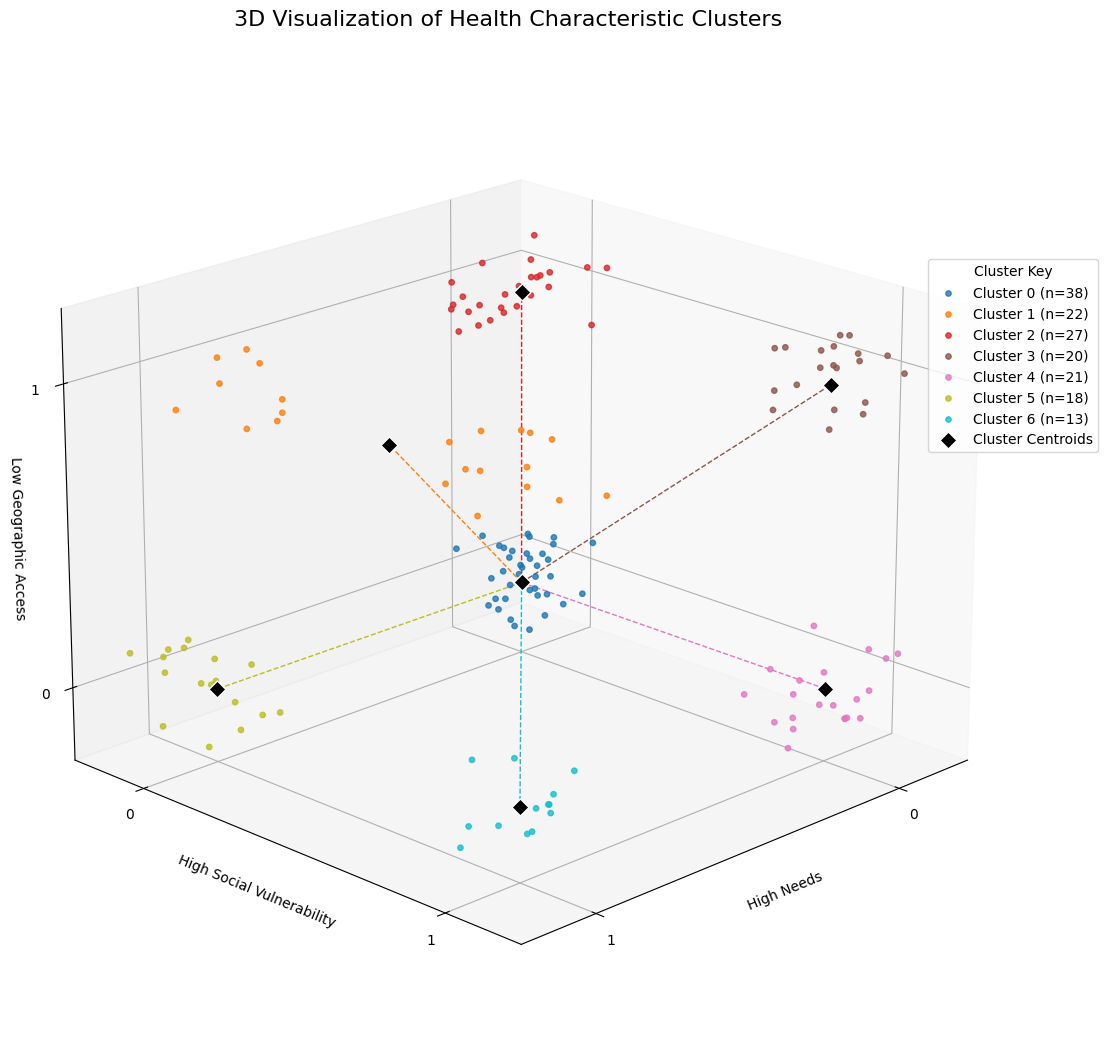

In [ ]:
# ==============================================================================
# Step 1: Import Packages
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting
from google.colab import files
from sklearn.cluster import KMeans

print("="*80)
print("3D Cluster Visualization Generator using Matplotlib")
print("="*80)

# ==============================================================================
# Step 2: Load Data and Perform Clustering
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '3factors-2.csv'
    demographic_data_path = 'original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data, demo_data, on='Response ID', how='inner')
print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)

# ==============================================================================
# Step 3: Prepare Data for 3D Plotting
# ==============================================================================
# Add "jitter" (small random noise) to spread points out for visibility
jitter_strength = 0.15
for var in clustering_vars:
    merged_data[f'{var}_jittered'] = merged_data[var] + np.random.uniform(
        -jitter_strength, jitter_strength, size=len(merged_data)
    )

# Calculate the centroid (average position) for each cluster
centroids = merged_data.groupby('Cluster')[clustering_vars].mean().reset_index()
print("\nCluster Centroids:")
print(centroids)

# ==============================================================================
# Step 4: Create the 3D Plot with Matplotlib
# ==============================================================================
print("\nGenerating 3D plot with Matplotlib...")

# --- Initialize Figure and 3D Axis ---
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Define a color map
colors = plt.cm.get_cmap('tab10', 7)

# --- Plot Cluster Points ---
for cluster in sorted(merged_data['Cluster'].unique()):
    cluster_df = merged_data[merged_data['Cluster'] == cluster]
    ax.scatter(
        cluster_df['high_needs_binary_jittered'],
        cluster_df['high_social_vulnerability_jittered'],
        cluster_df['low_geographic_access_jittered'],
        color=colors(cluster),
        s=15, # Smaller point size
        alpha=0.8,
        label=f'Cluster {cluster} (n={len(cluster_df)})'
    )

# --- Plot Lines from Origin to Centroids ---
for i, row in centroids.iterrows():
    cluster_num = int(row['Cluster'])
    ax.plot(
        [0, row['high_needs_binary']],
        [0, row['high_social_vulnerability']],
        [0, row['low_geographic_access']],
        color=colors(cluster_num),
        linestyle='--',
        linewidth=1
    )

# --- Plot Cluster Centroids ---
ax.scatter(
    centroids['high_needs_binary'],
    centroids['high_social_vulnerability'],
    centroids['low_geographic_access'],
    color='black',
    s=75, # Larger size for centroids
    marker='D', # Diamond marker
    edgecolor='white',
    depthshade=False,
    label='Cluster Centroids'
)

# --- Configure and Style the Plot ---
ax.set_title('3D Visualization of Health Characteristic Clusters', fontsize=16, pad=20)
ax.set_xlabel('High Needs')
ax.set_ylabel('High Social Vulnerability')
ax.set_zlabel('Low Geographic Access',  labelpad=0)

# Set ticks to be just 0 and 1
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_zticks([0, 1])

# Set a viewing angle
ax.view_init(elev=20, azim=45)

# Add a legend
ax.legend(title='Cluster Key', bbox_to_anchor=(1.1, 0.8))

plt.tight_layout()
plt.show()

3D Health Clusters - Diagonal and High Elevation Views

Assuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.

Loading and processing data...
✓ Data loaded, clustered, and merged successfully.
--------------------------------------------------------------------------------

Generating 3D Health Clusters with diagonal and high elevation views...


/tmp/ipython-input-2017650725.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 7)


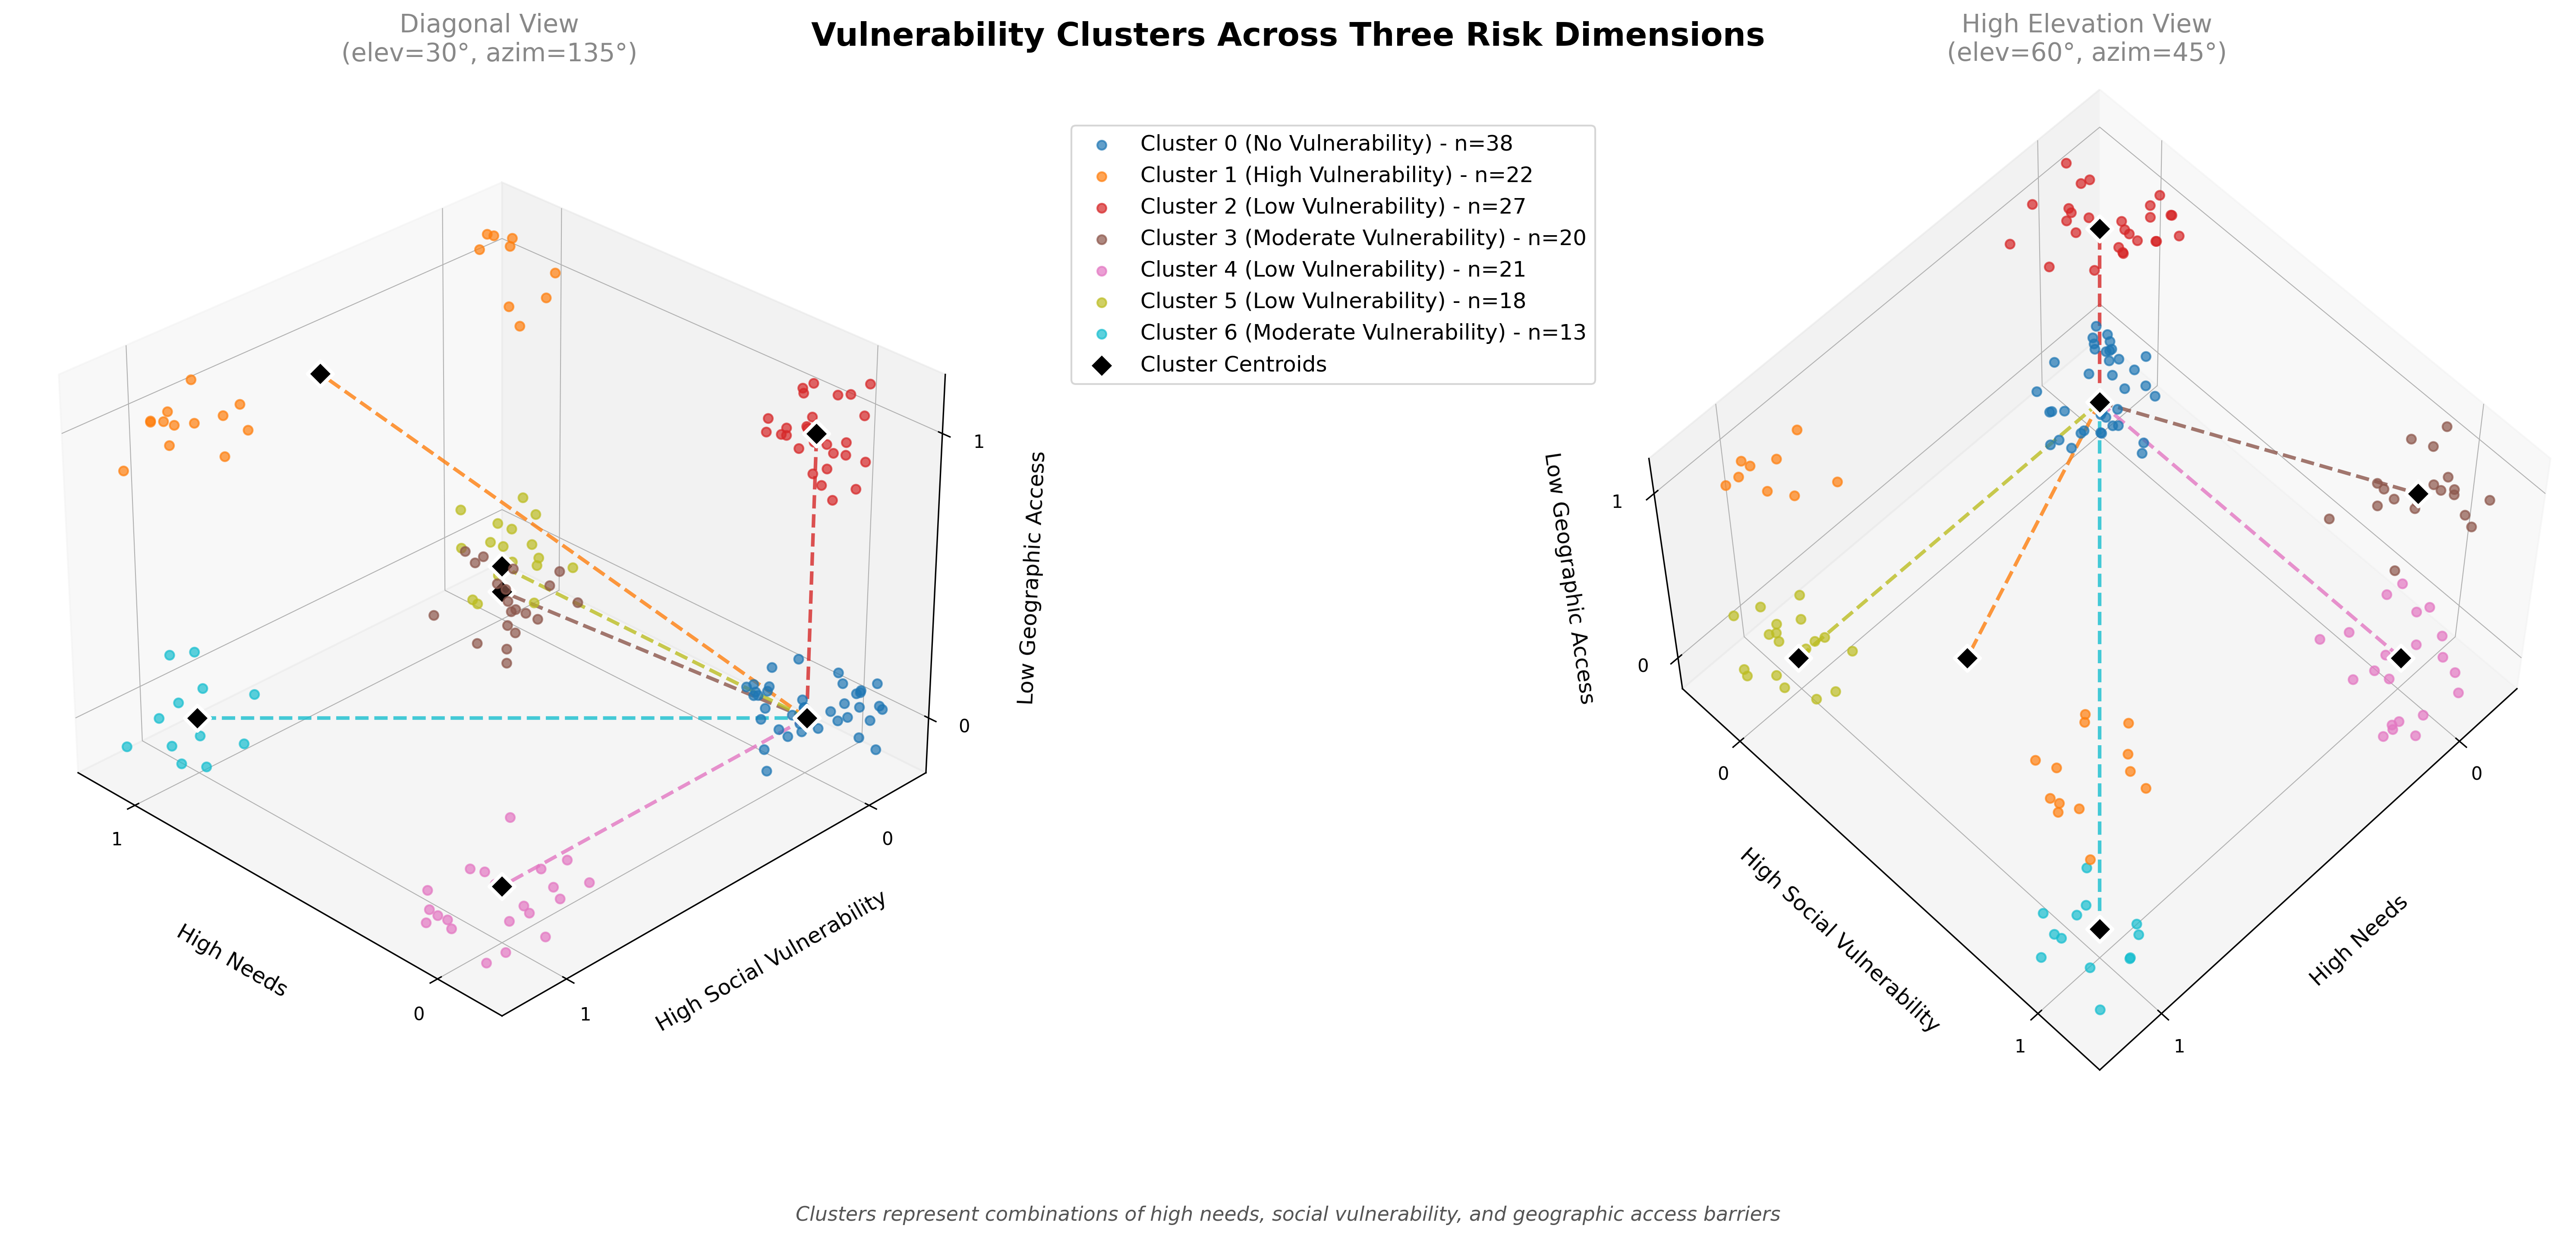


✓ 3D Health Clusters generated successfully!
✓ Diagonal view (30°, 135°) with trend lines
✓ High elevation view (60°, 45°) with trend lines
✓ Cluster centroids and origin lines included
✓ Risk levels: Lower Risk (1), Some Risk (3), Moderate Risk (2), High Risk (1)


In [2]:
# ==============================================================================
# Step 1: Import Packages
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting
from google.colab import files
from sklearn.cluster import KMeans

print("="*80)
print("3D Health Clusters - Diagonal and High Elevation Views")
print("="*80)


plt.rcParams['figure.dpi'] = 300  # High resolution
plt.rcParams['savefig.dpi'] = 300  # High resolution for saving
plt.rcParams['font.size'] = 10    # Slightly smaller base font for crisp text
plt.rcParams['axes.linewidth'] = 0.8  # Thinner, crisper lines
plt.rcParams['grid.linewidth'] = 0.5

# ==============================================================================
# Step 2: Load Data and Perform Clustering
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '/content/drive/MyDrive/Downloads/3factors-2.csv'
    demographic_data_path = '/content/drive/MyDrive/WIC /original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data, demo_data, on='Response ID', how='inner')

# Add jitter for better visibility
jitter_strength = 0.15
for var in clustering_vars:
    merged_data[f'{var}_jittered'] = merged_data[var] + np.random.uniform(
        -jitter_strength, jitter_strength, size=len(merged_data)
    )

# Calculate centroids
centroids = merged_data.groupby('Cluster')[clustering_vars].mean().reset_index()
colors = plt.cm.get_cmap('tab10', 7)

# Define cluster risk levels

"""Cluster 0 (no vulnerability)
Cluster 1 (high vulnerability)
Cluster 2 (low vulnerability)
Cluster 3 (moderate vulnerability)
Cluster 4 (low vulnerability)
Cluster 5 (low vulnerability)
Cluster 6 (moderate vulnerability)"""
cluster_names = {
    0: 'No Vulnerability',
    1: 'High Vulnerability',
    2: 'Low Vulnerability',
    3: 'Moderate Vulnerability',
    4: 'Low Vulnerability',
    5: 'Low Vulnerability',
    6: 'Moderate Vulnerability'
}

print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)

# ==============================================================================
# Step 3: Create Diagonal and High Elevation Views with Lines
# ==============================================================================

def create_3d_view_with_lines(elev, azim, title, subplot_pos, fig):
    """Create a 3D view with specified elevation and azimuth, including lines"""
    ax = fig.add_subplot(1, 2, subplot_pos, projection='3d')

    # Plot cluster points
    for cluster in sorted(merged_data['Cluster'].unique()):
        cluster_df = merged_data[merged_data['Cluster'] == cluster]
        ax.scatter(
            cluster_df['high_needs_binary_jittered'],
            cluster_df['high_social_vulnerability_jittered'],
            cluster_df['low_geographic_access_jittered'],
            color=colors(cluster),
            s=25,
            alpha=0.7,
            label=f'Cluster {cluster} ({cluster_names[cluster]}) - n={len(cluster_df)}'
        )

    # Plot lines from origin to centroids
    for i, row in centroids.iterrows():
        cluster_num = int(row['Cluster'])
        ax.plot(
            [0, row['high_needs_binary']],
            [0, row['high_social_vulnerability']],
            [0, row['low_geographic_access']],
            color=colors(cluster_num),
            linestyle='--',
            linewidth=2,
            alpha=0.8
        )

    # Plot cluster centroids
    ax.scatter(
        centroids['high_needs_binary'],
        centroids['high_social_vulnerability'],
        centroids['low_geographic_access'],
        color='black',
        s=100,
        marker='D',
        edgecolor='white',
        linewidth=2,
        depthshade=False,
        label='Cluster Centroids'
    )

    # Set view angle
    ax.view_init(elev=elev, azim=azim)

    # Configure plot
    ax.set_title(f'{title}\n(elev={elev}°, azim={azim}°)', fontsize=14, fontweight='normal', color = '#888888',  pad=30)
    ax.set_xlabel('High Needs', fontsize=12, labelpad=10)
    ax.set_ylabel('High Social Vulnerability', fontsize=12, labelpad=10)
    ax.set_zlabel('Low Geographic Access', fontsize=12, labelpad=10)

    # Set axis limits and ticks
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.2, 1.2)
    ax.set_zlim(-0.2, 1.2)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_zticks([0, 1])

    # Style the grid
    ax.grid(True, alpha=0.3)

    return ax

# Create the figure with both views
print("\nGenerating 3D Health Clusters with diagonal and high elevation views...")
fig = plt.figure(figsize=(20, 10))

# Diagonal view (30° elevation, 135° azimuth)
ax1 = create_3d_view_with_lines(30, 135, "Diagonal View", 1, fig)

# High elevation view (60° elevation, 45° azimuth)
ax2 = create_3d_view_with_lines(60, 45, "High Elevation View", 2, fig)

# Add legend to the first subplot with a larger font size
ax1.legend(bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=12)

# Main title
fig.suptitle('Vulnerability Clusters Across Three Risk Dimensions', fontsize=18, fontweight='bold', y=0.95)

# Add footer with cluster risk information
footer_text = (
               "Clusters represent combinations of high needs, social vulnerability, and geographic access barriers")
fig.text(0.5, 0.02, footer_text, ha='center', va='bottom', fontsize=11,
         style='italic', color='#555555', wrap=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  # Make room for footer
plt.savefig('3d_health_clusters.png') # Move savefig before show
plt.show()


print("\n" + "="*80)
print("✓ 3D Health Clusters generated successfully!")
print("✓ Diagonal view (30°, 135°) with trend lines")
print("✓ High elevation view (60°, 45°) with trend lines")
print("✓ Cluster centroids and origin lines included")
print("✓ Risk levels: Lower Risk (1), Some Risk (3), Moderate Risk (2), High Risk (1)")
print("="*80)

In [ ]:
!pip install datashader holoviews colorcet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 62.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import datashader as ds
import datashader.transfer_functions as tf
import colorcet as cc
import matplotlib.colors as mcolors # Import mcolors for color conversion

print("="*80)
print("High-Resolution 3D Health Clusters Generator")
print("="*80)

# ==============================================================================
# 1. LOAD AND PREPARE DATA (Same as your original code)
# ==============================================================================
try:
    print("\nLoading and processing data...")
    # --- UPDATED FILE PATHS ---
    cluster_data_path = '/content/drive/MyDrive/Downloads/3factors-2.csv'
    demographic_data_path = '/content/drive/MyDrive/WIC /original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError as e:
    print(f"\n❌ File not found. Please ensure the paths are correct and you have mounted your Google Drive.")
    print(f"Error details: {e}")
    exit()

clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data, demo_data, on='Response ID', how='inner')

# --- FIX: Convert 'Cluster' column to categorical type for Datashader ---
merged_data['Cluster'] = merged_data['Cluster'].astype('category')

# Add jitter for better visibility
jitter_strength = 0.15
for var in clustering_vars:
    merged_data[f'{var}_jittered'] = merged_data[var] + np.random.uniform(
        -jitter_strength, jitter_strength, size=len(merged_data)
    )

# Calculate centroids
# FIX: Add observed=True to groupby to align with future pandas behavior and silence warning.
centroids = merged_data.groupby('Cluster', observed=True)[clustering_vars].mean().reset_index()

# Define cluster names and colors
cluster_names = {
    0: 'Low Vulnerability', 1: 'High Vulnerability', 2: 'Moderate Vulnerability',
    3: 'Moderate Vulnerability', 4: 'Moderate Vulnerability', 5: 'Low Vulnerability',
    6: 'High Vulnerability'
}
# FIX: Create a single color map (cluster number -> hex string) to be used by both libraries.
# This avoids the TypeError and the MatplotlibDeprecationWarning.
# Convert the list of float colors from colorcet to hex strings
colorcet_colors_rgb = cc.glasbey_category10
cluster_color_map_hex = {i: mcolors.to_hex(color) for i, color in enumerate(colorcet_colors_rgb[:7])} # Use up to 7 colors

# Datashader color key needs category values (the cluster numbers) mapped to hex colors
# FIX: Ensure keys are integers, matching the cluster numbers
color_key_ds = {cat: color for cat, color in cluster_color_map_hex.items()}


print(f"✓ Data loaded, clustered, and merged successfully. Total points: {len(merged_data)}")
print("-" * 80)

# ==============================================================================
# 2. CORE FUNCTIONS FOR HYBRID RENDERING
# ==============================================================================

def project_3d_to_2d(points_3d, elev, azim):
    """
    Projects 3D points to a 2D plane based on Matplotlib's camera angle logic.

    Args:
        points_3d (np.array): A NumPy array of shape (n, 3) for (x, y, z).
        elev (float): The elevation angle in degrees.
        azim (float): The azimuth angle in degrees.

    Returns:
        np.array: A NumPy array of shape (n, 2) for the projected (x, y).
    """
    # Convert angles to radians
    elev_rad = np.deg2rad(elev)
    azim_rad = np.deg2rad(azim)

    # Create rotation matrices
    # 1. Rotation around Z-axis (azimuth)
    Rz = np.array([
        [np.cos(azim_rad), np.sin(azim_rad), 0],
        [-np.sin(azim_rad), np.cos(azim_rad), 0],
        [0, 0, 1]
    ])
    # 2. Rotation around a new X'-axis (elevation)
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(elev_rad), np.sin(elev_rad)],
        [0, -np.sin(elev_rad), np.cos(elev_rad)]
    ])

    # Apply rotations
    rotated_points = np.dot(points_3d, Rz)
    rotated_points = np.dot(rotated_points, Rx)

    # Return the first two dimensions for the 2D projection
    return rotated_points[:, :2]


def create_high_res_plot(df_all, df_centroids, elev, azim, title, filename):
    """
    Creates a single high-resolution plot using the hybrid Datashader + Matplotlib approach.
    """
    print(f"Rendering high-resolution view: '{title}'...")

    # --- Part 1: Datashader Rendering (The Heavy Lifting) ---

    # Get the 3D coordinates of all data points
    points_3d_all = df_all[[f'{var}_jittered' for var in clustering_vars]].values

    # Project all points to 2D based on the camera angle
    projected_points_2d = project_3d_to_2d(points_3d_all, elev, azim)
    df_all[['proj_x', 'proj_y']] = projected_points_2d

    # Define the image resolution
    IMAGE_WIDTH = 4000
    IMAGE_HEIGHT = 4000

    # Define the canvas bounds based on the projected data
    x_range = (df_all['proj_x'].min() - 0.1, df_all['proj_x'].max() + 0.1)
    y_range = (df_all['proj_y'].min() - 0.1, df_all['proj_y'].max() + 0.1)

    canvas = ds.Canvas(plot_width=IMAGE_WIDTH, plot_height=IMAGE_HEIGHT, x_range=x_range, y_range=y_range)

    # Render the point cloud with Datashader, colored by cluster
    # Use the corrected color_key_ds
    agg = canvas.points(df_all, x='proj_x', y='proj_y', agg=ds.by('Cluster', ds.count()))
    img = tf.shade(agg, color_key=color_key_ds, how='eq_hist')

    # --- Part 2: Matplotlib Overlay (The Details) ---

    # Create a Matplotlib figure
    fig, ax = plt.subplots(figsize=(12, 12), dpi=300)

    # Display the high-resolution Datashader image as the background
    ax.imshow(img.to_pil(), extent=[*x_range, *y_range], origin="lower")

    # Project the centroid and origin line points
    for i, row in df_centroids.iterrows():
        cluster_num = int(row['Cluster'])

        # Project the origin (0,0,0) and the centroid
        line_3d = np.array([[0, 0, 0], [row['high_needs_binary'], row['high_social_vulnerability'], row['low_geographic_access']]])
        line_2d = project_3d_to_2d(line_3d, elev, azim)

        # Plot the projected line using the unified color map (hex colors)
        ax.plot(line_2d[:, 0], line_2d[:, 1], color=cluster_color_map_hex[cluster_num], linestyle='--', linewidth=1.5, alpha=0.9)

    # Project and plot the centroid markers
    centroids_3d = df_centroids[clustering_vars].values
    centroids_2d = project_3d_to_2d(centroids_3d, elev, azim)
    ax.scatter(centroids_2d[:, 0], centroids_2d[:, 1], color='black', s=150, marker='D', edgecolor='white', linewidth=1.5, label='Cluster Centroids')

    # --- Part 3: Final Touches and Saving ---

    # Configure plot aesthetics
    ax.set_title(f'{title}\n(elev={elev}°, azim={azim}°)', fontsize=16, pad=20)
    ax.set_xlabel('Projected View X', fontsize=12)
    ax.set_ylabel('Projected View Y', fontsize=12)
    ax.grid(True, alpha=0.2, color='white')
    ax.set_facecolor('#222222') # Dark background to see white grid

    # Create a custom legend using the unified color map (hex colors)
    # Need to get the actual categories from the DataFrame for the legend
    cluster_categories = sorted(df_all['Cluster'].cat.categories)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {c} ({cluster_names[c]})',
                                  markerfacecolor=cluster_color_map_hex[c], markersize=10) for c in cluster_categories]
    legend_elements.append(plt.Line2D([0], [0], marker='D', color='w', label='Cluster Centroids', markerfacecolor='black', markersize=10))
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.25, 1))

    # Save the final composite image
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close(fig) # Close the figure to free up memory
    print(f"✓ Successfully saved high-resolution plot to '{filename}'")


# ==============================================================================
# 3. GENERATE AND SAVE THE PLOTS
# ==============================================================================

# Create the Diagonal View
create_high_res_plot(merged_data, centroids,
                     elev=30, azim=135,
                     title="Diagonal View",
                     filename="hd_view_diagonal.png")

# Create the High Elevation View
create_high_res_plot(merged_data, centroids,
                     elev=60, azim=45,
                     title="High Elevation View",
                     filename="hd_view_high_elevation.png")

print("\n" + "="*80)
print("✓ All high-resolution plots generated and saved.")
print("="*80)

High-Resolution 3D Health Clusters Generator

Loading and processing data...
✓ Data loaded, clustered, and merged successfully. Total points: 159
--------------------------------------------------------------------------------
Rendering high-resolution view: 'Diagonal View'...
✓ Successfully saved high-resolution plot to 'hd_view_diagonal.png'
Rendering high-resolution view: 'High Elevation View'...
✓ Successfully saved high-resolution plot to 'hd_view_high_elevation.png'

✓ All high-resolution plots generated and saved.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
from sklearn.cluster import KMeans

print("="*80)
print("3D Health Clusters - High Quality with 3D Background Preserved")
print("="*80)

# ==============================================================================
# HIGH QUALITY SETTINGS (Conservative for Colab)
# ==============================================================================
plt.rcParams['savefig.dpi'] = 200  # High quality for saved images only
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['grid.linewidth'] = 0.4

# ==============================================================================
# Step 2: Load Data and Perform Clustering (Original Code)
# ==============================================================================
try:
    print("\nAssuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.")
    cluster_data_path = '3factors-2.csv'
    demographic_data_path = 'original.csv'
    cluster_data = pd.read_csv(cluster_data_path)
    demo_data = pd.read_csv(demographic_data_path)
except FileNotFoundError:
    print("\n❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.")
    exit()

print("\nLoading and processing data...")
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)
merged_data = pd.merge(cluster_data, demo_data, on='Response ID', how='inner')

# Add jitter for better visibility
jitter_strength = 0.15
for var in clustering_vars:
    merged_data[f'{var}_jittered'] = merged_data[var] + np.random.uniform(
        -jitter_strength, jitter_strength, size=len(merged_data)
    )

# Calculate centroids
centroids = merged_data.groupby('Cluster')[clustering_vars].mean().reset_index()
colors = plt.cm.get_cmap('tab10', 7)

# Define cluster risk levels
cluster_names = {
    0: 'Low Vulnerability',
    1: 'High Vulnerability',
    2: 'Moderate Vulnerability',
    3: 'Moderate Vulnerability',
    4: 'Moderate Vulnerability',
    5: 'Low Vulnerability',
    6: 'High Vulnerability'
}

print("✓ Data loaded, clustered, and merged successfully.")
print("-" * 80)

# ==============================================================================
# Step 3: Enhanced 3D Views with Original Structure
# ==============================================================================

def create_enhanced_3d_view(elev, azim, title, subplot_pos, fig):
    """Create enhanced 3D view keeping original structure but with better quality"""
    ax = fig.add_subplot(1, 2, subplot_pos, projection='3d')

    # Plot cluster points with enhanced quality
    for cluster in sorted(merged_data['Cluster'].unique()):
        cluster_df = merged_data[merged_data['Cluster'] == cluster]
        ax.scatter(
            cluster_df['high_needs_binary_jittered'],
            cluster_df['high_social_vulnerability_jittered'],
            cluster_df['low_geographic_access_jittered'],
            color=colors(cluster),
            s=35,  # Slightly larger points for better visibility
            alpha=0.8,  # Slightly more opaque
            edgecolors='white',  # White edges for definition
            linewidths=0.4,     # Thin white edge
            depthshade=True,    # Enable depth shading for 3D effect
            label=f'Cluster {cluster} ({cluster_names[cluster]}) - n={len(cluster_df)}'
        )

    # Plot lines from origin to centroids (original design)
    for i, row in centroids.iterrows():
        cluster_num = int(row['Cluster'])
        ax.plot(
            [0, row['high_needs_binary']],
            [0, row['high_social_vulnerability']],
            [0, row['low_geographic_access']],
            color=colors(cluster_num),
            linestyle='--',
            linewidth=2.5,  # Slightly thicker for better visibility
            alpha=0.9
        )

    # Plot cluster centroids (original design)
    ax.scatter(
        centroids['high_needs_binary'],
        centroids['high_social_vulnerability'],
        centroids['low_geographic_access'],
        color='black',
        s=120,  # Slightly larger
        marker='D',
        edgecolor='white',
        linewidth=2,
        depthshade=False,
        label='Cluster Centroids'
    )

    # Set view angle
    ax.view_init(elev=elev, azim=azim)

    # Enhanced 3D styling while keeping original structure
    ax.set_title(f'{title}\n(elev={elev}°, azim={azim}°)',
                fontsize=14, fontweight='normal', color='#888888', pad=30)
    ax.set_xlabel('High Needs', fontsize=12, labelpad=10)
    ax.set_ylabel('High Social Vulnerability', fontsize=12, labelpad=10)
    ax.set_zlabel('Low Geographic Access', fontsize=12, labelpad=10)

    # Set axis limits and ticks (original)
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.2, 1.2)
    ax.set_zlim(-0.2, 1.2)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_zticks([0, 1])

    # Enhanced 3D grid and panes (keeping 3D look)
    ax.grid(True, alpha=0.3, linewidth=0.6)

    # Keep 3D panes but make them more subtle and crisp
    ax.xaxis.pane.fill = True
    ax.yaxis.pane.fill = True
    ax.zaxis.pane.fill = True

    # Set pane colors to very light gray with transparency
    ax.xaxis.pane.set_facecolor('#f8f8f8')
    ax.yaxis.pane.set_facecolor('#f8f8f8')
    ax.zaxis.pane.set_facecolor('#f8f8f8')
    ax.xaxis.pane.set_alpha(0.1)
    ax.yaxis.pane.set_alpha(0.1)
    ax.zaxis.pane.set_alpha(0.1)

    # Enhanced pane edges
    ax.xaxis.pane.set_edgecolor('#cccccc')
    ax.yaxis.pane.set_edgecolor('#cccccc')
    ax.zaxis.pane.set_edgecolor('#cccccc')
    ax.xaxis.pane.set_linewidth(0.8)
    ax.yaxis.pane.set_linewidth(0.8)
    ax.zaxis.pane.set_linewidth(0.8)

    # Enhanced tick styling
    ax.tick_params(axis='x', colors='#444444', labelsize=10, pad=2)
    ax.tick_params(axis='y', colors='#444444', labelsize=10, pad=2)
    ax.tick_params(axis='z', colors='#444444', labelsize=10, pad=2)

    return ax

# ==============================================================================
# Step 4: Create Enhanced Visualization with Original 3D Structure
# ==============================================================================

print("\nGenerating Enhanced 3D Health Clusters with preserved 3D background...")

# Create figure with enhanced settings
fig = plt.figure(figsize=(22, 11))  # Slightly larger for better quality
fig.patch.set_facecolor('white')

# Diagonal view (30° elevation, 135° azimuth)
ax1 = create_enhanced_3d_view(30, 135, "Diagonal View", 1, fig)

# High elevation view (60° elevation, 45° azimuth)
ax2 = create_enhanced_3d_view(60, 45, "High Elevation View", 2, fig)

# Add enhanced legend with original design
legend = ax1.legend(bbox_to_anchor=(1.1, 1),
                   loc='upper left',
                   fontsize=12,
                   frameon=True,
                   fancybox=True,
                   shadow=True,
                   framealpha=0.95,
                   edgecolor='#dddddd',
                   facecolor='white')

# Enhance legend frame
legend.get_frame().set_linewidth(0.8)

# Original titles and styling
fig.suptitle('Vulnerability Clusters Across Three Risk Dimensions',
             fontsize=18, fontweight='bold', y=0.95)

# Add footer with original design
footer_text = ("Clusters represent combinations of high needs, social vulnerability, and geographic access barriers")
fig.text(0.5, 0.02, footer_text, ha='center', va='bottom', fontsize=11,
         style='italic', color='#555555', wrap=True)

# Tight layout with original spacing
plt.tight_layout()
plt.subplots_adjust(bottom=0.12, top=0.88)
plt.show()

# Save enhanced version
plt.savefig('enhanced_3d_health_clusters.png', dpi=200, bbox_inches='tight',
            facecolor='white', edgecolor='none', format='png')

print("\n" + "="*80)
print("✓ Enhanced 3D Health Clusters generated successfully!")
print("✓ Preserved original 3D background and structure")
print("✓ Enhanced point quality with white edges and depth shading")
print("✓ Improved grid lines and pane transparency")
print("✓ Slightly larger, crisper elements")
print("✓ 200 DPI save quality")
print("✓ Diagonal view (30°, 135°) with trend lines")
print("✓ High elevation view (60°, 45°) with trend lines")
print("✓ All original 3D visual elements maintained")
print("="*80)

3D Health Clusters - High Quality with 3D Background Preserved

Assuming files '3factors-2.csv' and 'original.csv' are already present in Colab environment.

❌ Files not found. Please upload '3factors-2.csv' and 'original.csv'.

Loading and processing data...


NameError: name 'cluster_data' is not defined

✓ Data loaded, clustered, and merged successfully.

Calculating proportions for specified variables...
✓ Proportions calculated:
   Cluster        POC  college_ed_binary  employed_binary  \
0        0  42.105263          39.473684        57.894737   
1        1  59.090909          18.181818        54.545455   
2        2  40.740741          33.333333        62.962963   
3        3  40.000000          35.000000        50.000000   
4        4  61.904762          28.571429        52.380952   
5        5  33.333333          50.000000        72.222222   
6        6  46.153846          15.384615        46.153846   

   self_insured_binary  difficult_afford_health  
0            78.947368                39.473684  
1            63.636364                63.636364  
2            70.370370                40.740741  
3            55.000000                30.000000  
4            61.904762                42.857143  
5           100.000000                55.555556  
6            53.846154          

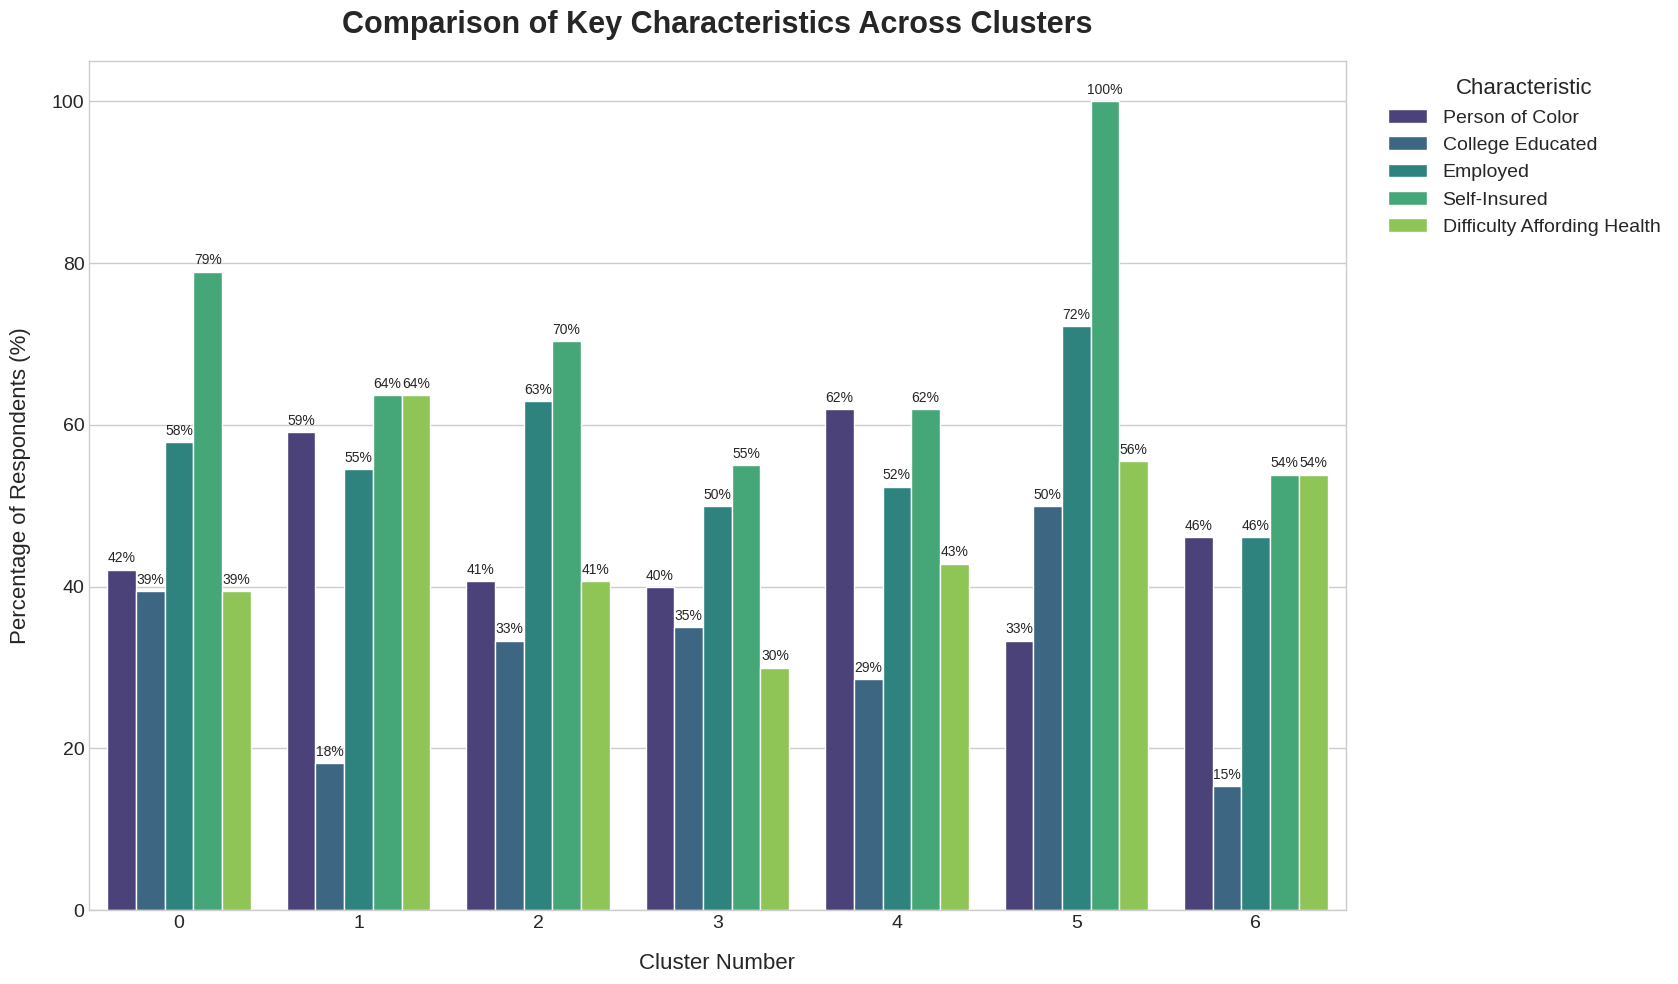

In [ ]:
# ==============================================================================
# Step 1: Import necessary packages
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.cluster import KMeans


# ==============================================================================
# Step 3: Load Data and Perform Clustering


clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars]

kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_data['Cluster'] = kmeans.fit_predict(X)

merged_data = pd.merge(cluster_data[['Response ID', 'Cluster']], demo_data, on='Response ID', how='inner')
print("✓ Data loaded, clustered, and merged successfully.")

# ==============================================================================
# Step 4: Calculate Proportions for the Bar Chart
# ==============================================================================
print("\nCalculating proportions for specified variables...")

# These are the original binary columns you requested
vars_to_plot = [
    'POC',
    'college_ed_binary',
    'employed_binary',
    'self_insured_binary',
    'difficult_afford_health'
]

# Check for missing columns
missing_vars = [var for var in vars_to_plot if var not in merged_data.columns]
if missing_vars:
    print(f"\n❌ Error: The following columns were not found: {missing_vars}")
    exit()

# Group by cluster and calculate the mean for each binary variable to get proportions
cluster_proportions = merged_data.groupby('Cluster')[vars_to_plot].mean().reset_index()

# Convert proportions to percentages
for var in vars_to_plot:
    cluster_proportions[var] = cluster_proportions[var] * 100

print("✓ Proportions calculated:")
print(cluster_proportions)

# ==============================================================================
# Step 5: Create and Save the Grouped Bar Chart
# ==============================================================================
print("\nGenerating grouped bar chart...")

# "Melt" the dataframe to make it suitable for seaborn's barplot function
plot_data = cluster_proportions.melt(id_vars='Cluster', var_name='Characteristic', value_name='Percentage')

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(
    data=plot_data,
    x='Cluster',
    y='Percentage',
    hue='Characteristic',
    palette='viridis',
    ax=ax
)

# --- Formatting the plot for clarity ---
ax.set_title('Comparison of Key Characteristics Across Clusters', fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Cluster Number', fontsize=16, labelpad=15)
ax.set_ylabel('Percentage of Respondents (%)', fontsize=16, labelpad=15)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim(0, 105) # Set y-limit to 105 to give space for labels

# Improve the legend with more descriptive labels
new_labels = [
    'Person of Color',
    'College Educated',
    'Employed',
    'Self-Insured',
    'Difficulty Affording Health'
]
ax.legend(handles=ax.get_legend().legend_handles, labels=new_labels, title='Characteristic', fontsize=14, title_fontsize=16, bbox_to_anchor=(1.02, 1), loc='upper left')

# Add percentage labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%', fontsize=10, padding=3)

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend

# Save the figure
output_filename = 'cluster_characteristics_barchart.png'
plt.savefig(output_filename)

print(f"\n✓ Chart saved as '{output_filename}'. You can download it from the Colab file pane.")
plt.show()

In [ ]:
# Healthcare Access Clustering Analysis Following Lanni et al. Methodology
# Analysis of social vulnerability, geographic access, and health needs patterns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, Birch, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, tukey_hsd
import time
import warnings
import itertools
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42

print("="*80)
print("HEALTHCARE ACCESS CLUSTERING ANALYSIS")
print("Following Lanni et al. (2024) Methodology")
print("="*80)

# ==================================================================================
# STEP 1: CLUSTERING ANALYSIS
# ==================================================================================

print("\n" + "="*50)
print("STEP 1: CLUSTERING ANALYSIS")
print("="*50)

# Load clustering data
print("\nLoading clustering data...")
try:
    cluster_data = pd.read_csv('/content/3factors-2.csv')
    print(f"✓ Loaded clustering data: {cluster_data.shape}")
    print(f"Columns: {list(cluster_data.columns)}")
    print(f"First few rows:")
    print(cluster_data.head())
except FileNotFoundError:
    print("❌ Error: 3factor.csv not found. Please upload the file.")
    exit()

# Prepare clustering variables
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars].copy()

print(f"\nClustering variables:")
for var in clustering_vars:
    print(f"  - {var}: {X[var].value_counts().to_dict()}")

# Standardize data for algorithms that require it
X_scaled = StandardScaler().fit_transform(X)

# Define clustering algorithms to test
algorithms = {
    'K-means': lambda k: KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10),
    'Hierarchical (Ward)': lambda k: AgglomerativeClustering(n_clusters=k, linkage='ward'),
    'Spectral': lambda k: SpectralClustering(n_clusters=k, random_state=RANDOM_STATE),
    'Birch': lambda k: Birch(n_clusters=k),
    'Gaussian Mixture': lambda k: GaussianMixture(n_components=k, random_state=RANDOM_STATE),
    'DBSCAN': lambda k: DBSCAN(eps=0.5, min_samples=5)
}

# Test different numbers of clusters (following Lanni paper approach)
k_range = range(2, 8)  # Test 2-7 clusters
results = []

print("\nTesting clustering algorithms...")
print("Algorithm".ljust(20), "K".ljust(3), "Silhouette".ljust(12), "Davies-Bouldin".ljust(15),
      "Calinski-Harabasz".ljust(18), "Execution Time")
print("-" * 75)

for algo_name, algo_func in algorithms.items():
    if algo_name == 'DBSCAN':
        # DBSCAN doesn't take k parameter
        start_time = time.time()
        try:
            model = algo_func(None)
            if algo_name in ['Spectral']:
                labels = model.fit_predict(X_scaled)
            else:
                labels = model.fit_predict(X)
            end_time = time.time()

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1 and len(set(labels)) > 1:
                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
                exec_time = end_time - start_time

                # Check if DBSCAN results are suspiciously perfect
                if sil_score > 0.99:
                    print(f"{algo_name:<20} {n_clusters:<3} {'EXCLUDED':<12} {'(Perfect)':<15} {'(Likely overfitting)':<18} {exec_time:.3f}")
                    continue

                results.append({
                    'Algorithm': algo_name,
                    'K': n_clusters,
                    'Silhouette_Score': sil_score,
                    'Davies_Bouldin_Index': db_score,
                    'Calinski_Harabasz_Index': ch_score,
                    'Execution_Time': exec_time,
                    'Labels': labels
                })

                print(f"{algo_name:<20} {n_clusters:<3} {sil_score:<12.3f} {db_score:<15.3f} {ch_score:<18.1f} {exec_time:.3f}")
            else:
                print(f"{algo_name:<20} {'N/A':<3} {'No clusters':<12} {'found':<15} {'':<18}")
        except Exception as e:
            print(f"{algo_name:<20} {'ERR':<3} {'Error:':<12} {str(e)[:15]:<15}")
    else:
        # For other algorithms, test different k values
        for k in k_range:
            start_time = time.time()
            try:
                model = algo_func(k)
                if algo_name in ['Spectral']:
                    labels = model.fit_predict(X_scaled)
                else:
                    labels = model.fit_predict(X)
                end_time = time.time()

                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
                exec_time = end_time - start_time

                results.append({
                    'Algorithm': algo_name,
                    'K': k,
                    'Silhouette_Score': sil_score,
                    'Davies_Bouldin_Index': db_score,
                    'Calinski_Harabasz_Index': ch_score,
                    'Execution_Time': exec_time,
                    'Labels': labels
                })

                print(f"{algo_name:<20} {k:<3} {sil_score:<12.3f} {db_score:<15.3f} {ch_score:<18.1f} {exec_time:.3f}")

            except Exception as e:
                print(f"{algo_name:<20} {k:<3} {'Error:':<12} {str(e)[:15]:<15}")

# Convert results to DataFrame and find best model
results_df = pd.DataFrame(results)

print(f"\n\nCLUSTERING VALIDATION RESULTS")
print("="*50)

# Create validation table similar to Lanni paper Table X
validation_table = results_df.groupby('Algorithm').apply(
    lambda x: x.loc[x['Silhouette_Score'].idxmax()]
).reset_index(drop=True)

# Sort by Silhouette Score (higher is better)
validation_table = validation_table.sort_values('Silhouette_Score', ascending=False)

print("\nTable X. Validation results of clustering methods")
print("-" * 90)
print(f"{'Algorithm':<20} {'Silhouette':<12} {'Davies-Bouldin':<15} {'Calinski-Harabasz':<18} {'Execution'}")
print(f"{'':20} {'Score':<12} {'Index':<15} {'Index':<18} {'Time^a'}")
print("-" * 90)

for _, row in validation_table.iterrows():
    print(f"{row['Algorithm']:<20} {row['Silhouette_Score']:<12.3f} {row['Davies_Bouldin_Index']:<15.3f} "
          f"{row['Calinski_Harabasz_Index']:<18.1f} {row['Execution_Time']:<.3f}")

print("\nNote: ^a all variables assessed execution time in seconds.")

# Select best clustering solution
best_solution = validation_table.iloc[0]
print(f"\n🏆 BEST CLUSTERING SOLUTION:")
print(f"   Algorithm: {best_solution['Algorithm']}")
print(f"   Number of clusters: {best_solution['K']}")
print(f"   Silhouette Score: {best_solution['Silhouette_Score']:.3f}")

# Get the best clustering labels
best_labels = best_solution['Labels']
cluster_data['Cluster'] = best_labels

# Analyze cluster distribution
print(f"\nCluster distribution:")
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = (count / len(best_labels)) * 100
    print(f"   Cluster {cluster}: N={count} ({pct:.1f}%)")

# ==================================================================================
# STEP 2: DEMOGRAPHIC PROFILING
# ==================================================================================

print("\n" + "="*50)
print("STEP 2: DEMOGRAPHIC PROFILING")
print("="*50)

# Load demographic data
print("\nLoading demographic data...")
try:
    demo_data = pd.read_csv('/content/original.csv')
    print(f"✓ Loaded demographic data: {demo_data.shape}")
except FileNotFoundError:
    print("❌ Error: new_cluster_data.csv not found. Please upload the file.")
    exit()

# Merge cluster assignments with demographic data
print("\nMerging cluster assignments with demographic data...")
# Include clustering variables in the merge for later interpretation
merged_data = pd.merge(cluster_data[['Response ID', 'Cluster'] + clustering_vars], demo_data, on='Response ID', how='inner')
print(f"✓ Merged data: {merged_data.shape}")

# Define demographic variables for profiling
demographic_vars = {
    'Age': 'continuous',
    'POC': 'categorical',  # Person of Color
    'HH_num': 'continuous',  # Household size
    'children_in_HH': 'continuous',  # Children in household
    'pregnant_binary': 'categorical',  # Currently pregnant
    'college_ed_binary': 'categorical',  # College education
    'employed_binary': 'categorical',  # Currently employed
    'self_insured_binary': 'categorical',  # Self-insured
    'kids_insured_binary': 'categorical',  # Children insured
    'difficult_afford_health': 'categorical',  # Difficulty affording care
    'born_outside_US': 'categorical',  # Born outside US
    'ESL': 'categorical'  # English as second language
}

# Note: RUCC remote not found in the provided columns, excluding from analysis

print(f"\nDemographic variables for analysis:")
for var, var_type in demographic_vars.items():
    if var in merged_data.columns:
        print(f"   ✓ {var} ({var_type})")
    else:
        print(f"   ❌ {var} (not found)")

# Create cluster comparison tables
def calculate_effect_size_categorical(contingency_table):
    """Calculate Cramer's V for categorical variables"""
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    return cramers_v

def calculate_effect_size_continuous(f_stat, df_between, df_within):
    """Calculate partial eta-squared for continuous variables"""
    eta_squared = (f_stat * df_between) / (f_stat * df_between + df_within)
    return eta_squared

def perform_posthoc_continuous(data, cluster_col, outcome_var, alpha=0.05):
    """Perform Tukey's HSD post-hoc test for continuous variables"""
    # Get data for each cluster
    groups = []
    cluster_labels = []

    for cluster in sorted(data[cluster_col].unique()):
        cluster_data = pd.to_numeric(data[data[cluster_col] == cluster][outcome_var], errors='coerce').dropna()
        if len(cluster_data) > 0:
            groups.append(cluster_data.values)
            cluster_labels.append(cluster)

    if len(groups) < 2:
        return {}

    # Perform Tukey's HSD
    try:
        res = tukey_hsd(*groups)

        # Create pairwise comparison results
        posthoc_results = {}
        for i, cluster_i in enumerate(cluster_labels):
            for j, cluster_j in enumerate(cluster_labels):
                if i < j:  # Only compare each pair once
                    p_value = res.pvalue[i, j]
                    significant = p_value < alpha
                    posthoc_results[(cluster_i, cluster_j)] = {
                        'p_value': p_value,
                        'significant': significant
                    }

        return posthoc_results
    except Exception as e:
        print(f"   ⚠️  Error in Tukey's HSD: {str(e)}")
        return {}

def perform_posthoc_categorical(data, cluster_col, outcome_var, alpha=0.05):
    """Perform pairwise chi-square tests for categorical variables"""
    posthoc_results = {}
    clusters = sorted(data[cluster_col].unique())

    for i, cluster_i in enumerate(clusters):
        for j, cluster_j in enumerate(clusters):
            if i < j:  # Only compare each pair once
                # Create 2x2 contingency table for this pair
                pair_data = data[data[cluster_col].isin([cluster_i, cluster_j])]
                if len(pair_data) > 0:
                    try:
                        contingency = pd.crosstab(pair_data[cluster_col], pair_data[outcome_var])
                        if contingency.shape == (2, 2) and contingency.sum().sum() > 0:
                            chi2, p_value, _, _ = chi2_contingency(contingency)
                            significant = p_value < alpha
                            posthoc_results[(cluster_i, cluster_j)] = {
                                'p_value': p_value,
                                'significant': significant
                            }
                    except Exception as e:
                        continue

    return posthoc_results

def assign_significance_groups(clusters, posthoc_results):
    """Assign letters (a, b, c) to clusters based on post-hoc results"""
    # Create a graph of which clusters are significantly different
    sig_different = set()
    for (cluster_i, cluster_j), result in posthoc_results.items():
        if result['significant']:
            sig_different.add((cluster_i, cluster_j))

    # Group clusters that are NOT significantly different from each other
    groups = {}
    letters = 'abcdefghijklmnopqrstuvwxyz'
    letter_idx = 0

    for cluster in clusters:
        if cluster not in groups:
            # Find all clusters that are not significantly different from this one
            group_members = {cluster}
            for other_cluster in clusters:
                if other_cluster != cluster:
                    pair = tuple(sorted([cluster, other_cluster]))
                    if pair not in sig_different:
                        group_members.add(other_cluster)

            # Assign letter to this group
            for member in group_members:
                if member not in groups:
                    groups[member] = letters[letter_idx]

            letter_idx += 1

    return groups

# Perform statistical analysis following Lanni methodology
cluster_results = []
statistical_results = []
posthoc_results = {}

n_clusters = len(merged_data['Cluster'].unique())
n_comparisons = len(demographic_vars)

print(f"\nPerforming statistical analysis with Bonferroni correction...")
print(f"Number of comparisons: {n_comparisons}")
print(f"Bonferroni-corrected alpha: {0.05/n_comparisons:.4f}")

for var, var_type in demographic_vars.items():
    if var not in merged_data.columns:
        continue

    print(f"\nAnalyzing {var}...")

    # Calculate total sample statistics
    if var_type == 'categorical':
        total_sample_value = merged_data[var].mean() * 100  # Percentage
        total_sample_n = len(merged_data[var].dropna())
        total_sample_sd = np.nan  # No SD for categorical
    else:
        total_sample_value = merged_data[var].mean()
        total_sample_n = len(merged_data[var].dropna())
        total_sample_sd = merged_data[var].std()

    if var_type == 'categorical':
        # Chi-square test for categorical variables
        analysis_data = merged_data[['Cluster', var]].dropna()

        if len(analysis_data) < 10:
            print(f"   ❌ Insufficient data for {var}. Skipping.")
            continue

        contingency_table = pd.crosstab(analysis_data['Cluster'], analysis_data[var])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        effect_size = calculate_effect_size_categorical(contingency_table)

        # Bonferroni correction
        p_value_corrected = min(p_value * n_comparisons, 1.0)

        # Perform post-hoc tests if significant
        posthoc = {}
        significance_groups = {}
        if p_value_corrected < 0.05:
            print(f"   Performing post-hoc pairwise comparisons...")
            posthoc = perform_posthoc_categorical(analysis_data, 'Cluster', var, alpha=0.05/n_comparisons)
            clusters = sorted(analysis_data['Cluster'].unique())
            significance_groups = assign_significance_groups(clusters, posthoc)
            posthoc_results[var] = {'type': 'categorical', 'results': posthoc, 'groups': significance_groups}

        statistical_results.append({
            'Variable': var,
            'Type': 'Categorical',
            'Test_Statistic': chi2,
            'P_Value': p_value,
            'P_Value_Corrected': p_value_corrected,
            'Effect_Size': effect_size,
            'Effect_Size_Type': "Cramer's V",
            'Total_Sample_Value': total_sample_value,
            'Total_Sample_N': total_sample_n,
            'Total_Sample_SD': total_sample_sd
        })

        # Calculate proportions for each cluster
        for cluster in sorted(merged_data['Cluster'].unique()):
            cluster_data_subset = analysis_data[analysis_data['Cluster'] == cluster]
            if len(cluster_data_subset) > 0:
                value = cluster_data_subset[var].mean() * 100
                n = len(cluster_data_subset)
                sd = np.nan  # No SD for categorical
            else:
                value = 0
                n = 0
                sd = np.nan

            # Add significance group letter if available
            sig_group = significance_groups.get(cluster, '')

            cluster_results.append({
                'Variable': var,
                'Cluster': cluster,
                'N': n,
                'Value': value,
                'SD': sd,
                'Type': 'Percentage',
                'Significance_Group': sig_group
            })

    elif var_type == 'continuous':
        # ANOVA for continuous variables
        groups = []
        cluster_info = []

        for cluster in sorted(merged_data['Cluster'].unique()):
            cluster_data = pd.to_numeric(merged_data[merged_data['Cluster'] == cluster][var], errors='coerce').dropna()
            if len(cluster_data) > 0:
                groups.append(cluster_data)
                cluster_info.append(cluster)

        if len(groups) >= 2 and all(len(group) > 0 for group in groups):
            try:
                f_stat, p_value = f_oneway(*groups)

                # Calculate effect size (partial eta-squared)
                df_between = len(groups) - 1
                df_within = sum(len(group) for group in groups) - len(groups)
                effect_size = calculate_effect_size_continuous(f_stat, df_between, df_within)

                # Bonferroni correction
                p_value_corrected = min(p_value * n_comparisons, 1.0)

                # Perform post-hoc tests if significant
                posthoc = {}
                significance_groups = {}
                if p_value_corrected < 0.05:
                    print(f"   Performing Tukey's HSD post-hoc test...")
                    posthoc = perform_posthoc_continuous(merged_data, 'Cluster', var, alpha=0.05/n_comparisons)
                    clusters = sorted(merged_data['Cluster'].unique())
                    significance_groups = assign_significance_groups(clusters, posthoc)
                    posthoc_results[var] = {'type': 'continuous', 'results': posthoc, 'groups': significance_groups}

                statistical_results.append({
                    'Variable': var,
                    'Type': 'Continuous',
                    'Test_Statistic': f_stat,
                    'P_Value': p_value,
                    'P_Value_Corrected': p_value_corrected,
                    'Effect_Size': effect_size,
                    'Effect_Size_Type': 'Partial η²',
                    'Total_Sample_Value': total_sample_value,
                    'Total_Sample_N': total_sample_n,
                    'Total_Sample_SD': total_sample_sd
                })

            except Exception as e:
                print(f"   ❌ Error in ANOVA for {var}: {str(e)}")
                continue
        else:
            print(f"   ❌ Insufficient groups with valid data for ANOVA on {var}")
            continue

        # Calculate means and SDs for each cluster
        for cluster in sorted(merged_data['Cluster'].unique()):
            cluster_data_subset = merged_data[merged_data['Cluster'] == cluster]
            cluster_data_clean = pd.to_numeric(cluster_data_subset[var], errors='coerce').dropna()

            if len(cluster_data_clean) > 0:
                value = cluster_data_clean.mean()
                n = len(cluster_data_clean)
                sd = cluster_data_clean.std()
            else:
                value = np.nan
                n = 0
                sd = np.nan

            # Add significance group letter if available
            sig_group = significance_groups.get(cluster, '')

            cluster_results.append({
                'Variable': var,
                'Cluster': cluster,
                'N': n,
                'Value': value,
                'SD': sd,
                'Type': 'Mean',
                'Significance_Group': sig_group
            })

# Create demographic profile table
demographic_profile = pd.DataFrame(cluster_results)
stats_df = pd.DataFrame(statistical_results)

# Create final demographic comparison table
print(f"\n\nDEMOGRAPHIC CLUSTER PROFILES")
print("="*50)

# Create summary table
summary_data = []
cluster_names = sorted(merged_data['Cluster'].unique())

for var in demographic_vars.keys():
    if var not in merged_data.columns:
        continue

    row = {'Variable': var}

    # Add total sample data
    stat_subset = stats_df[stats_df['Variable'] == var]
    if len(stat_subset) > 0:
        stat_row = stat_subset.iloc[0]
        if demographic_vars[var] == 'categorical':
            row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.1f}% (n={stat_row['Total_Sample_N']})"
        else:
            row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.2f} ± {stat_row['Total_Sample_SD']:.2f} (n={stat_row['Total_Sample_N']})"

    # Add data for each cluster
    for cluster in cluster_names:
        cluster_subset = demographic_profile[
            (demographic_profile['Variable'] == var) &
            (demographic_profile['Cluster'] == cluster)
        ]

        if len(cluster_subset) > 0:
            value = cluster_subset['Value'].iloc[0]
            n = cluster_subset['N'].iloc[0]
            sd = cluster_subset['SD'].iloc[0]
            sig_group = cluster_subset['Significance_Group'].iloc[0]

            if demographic_vars[var] == 'categorical':
                cluster_text = f"{value:.1f}% (n={n})"
            else:
                if pd.notna(sd):
                    cluster_text = f"{value:.2f} ± {sd:.2f} (n={n})"
                else:
                    cluster_text = f"{value:.2f} (n={n})"

            # Add significance group letter
            if sig_group:
                cluster_text += f"^{sig_group}"

            row[f'Cluster_{cluster}'] = cluster_text

    # Add statistical results
    if len(stat_subset) > 0:
        stat_row = stat_subset.iloc[0]
        row['Test_Statistic'] = f"{stat_row['Test_Statistic']:.2f}"
        row['P_Value'] = f"{stat_row['P_Value_Corrected']:.4f}"
        row['Effect_Size'] = f"{stat_row['Effect_Size']:.3f}"

        # Significance markers
        if stat_row['P_Value_Corrected'] < 0.001:
            row['Significance'] = '***'
        elif stat_row['P_Value_Corrected'] < 0.01:
            row['Significance'] = '**'
        elif stat_row['P_Value_Corrected'] < 0.05:
            row['Significance'] = '*'
        else:
            row['Significance'] = ''

    summary_data.append(row)

demographic_summary = pd.DataFrame(summary_data)

# Display the table
print("\nTable 2. CLUSTER DIFFERENCES IN DEMOGRAPHIC AND HOUSEHOLD CHARACTERISTICS")
print("-" * 100)

for _, row in demographic_summary.iterrows():
    var_name = row['Variable']
    print(f"\n{var_name}:")

    for cluster in cluster_names:
        col_name = f'Cluster_{cluster}'
        if col_name in row and pd.notna(row[col_name]):
            print(f"   Cluster {cluster}: {row[col_name]}")

    if 'Test_Statistic' in row and pd.notna(row['Test_Statistic']):
        stat_type = stats_df[stats_df['Variable'] == var_name]['Type'].iloc[0]
        test_name = 'χ²' if stat_type == 'Categorical' else 'F'
        print(f"   {test_name} = {row['Test_Statistic']}, p = {row['P_Value']}{row.get('Significance', '')}")

        effect_type = stats_df[stats_df['Variable'] == var_name]['Effect_Size_Type'].iloc[0]
        print(f"   {effect_type} = {row['Effect_Size']}")

# Save demographic results to CSV
demographic_summary.to_csv('demographic_cluster_profiles.csv', index=False)
print(f"\n✓ Demographic profiles saved to: demographic_cluster_profiles.csv")

# ==================================================================================
# STEP 3: OUTCOME ANALYSIS
# ==================================================================================

print("\n" + "="*50)
print("STEP 3: OUTCOME ANALYSIS")
print("="*50)

# Define outcome variables
outcome_vars = {
    'pct_times_get_Care': 'continuous',
    'mean_satisfaction': 'continuous',
    'sought_care_recently': 'categorical'
}

print(f"\nAnalyzing care outcome variables:")
for var, var_type in outcome_vars.items():
    if var in merged_data.columns:
        print(f"   ✓ {var} ({var_type})")
        # Check data type and sample values
        print(f"       Data type: {merged_data[var].dtype}")
        print(f"       Sample values: {merged_data[var].dropna().head(3).tolist()}")
        print(f"       Unique values (first 10): {sorted(merged_data[var].dropna().unique())[:10]}")
        print(f"       Missing values: {merged_data[var].isna().sum()}/{len(merged_data)}")
    else:
        print(f"   ❌ {var} (not found)")

# Clean and convert outcome variables to appropriate types
print(f"\nCleaning outcome variables...")
for var, var_type in outcome_vars.items():
    if var in merged_data.columns:
        print(f"\nProcessing {var}:")
        original_valid = merged_data[var].notna().sum()
        print(f"   Originally valid: {original_valid}/{len(merged_data)}")

        if var_type == 'continuous':
            # Special handling for percentage values
            if var == 'pct_times_get_Care':
                print(f"   Special handling for percentage values in {var}")
                # Remove '%' symbol and convert to numeric
                original_data = merged_data[var].copy()

                # Convert percentage strings to numeric
                def convert_percentage(x):
                    if pd.isna(x):
                        return np.nan
                    try:
                        # Remove '%' and convert to float
                        if isinstance(x, str) and '%' in x:
                            return float(x.replace('%', ''))
                        else:
                            return float(x)
                    except:
                        return np.nan

                merged_data[var] = merged_data[var].apply(convert_percentage)
                after_conversion = merged_data[var].notna().sum()
                print(f"   After percentage conversion: {after_conversion}/{len(merged_data)}")
            else:
                # Convert to numeric, replacing any non-numeric values with NaN
                original_data = merged_data[var].copy()
                merged_data[var] = pd.to_numeric(merged_data[var], errors='coerce')
                after_conversion = merged_data[var].notna().sum()
                print(f"   After numeric conversion: {after_conversion}/{len(merged_data)}")

            # Show what values were lost in conversion
            if after_conversion < original_valid:
                lost_mask = original_data.notna() & merged_data[var].isna()
                if lost_mask.sum() > 0:
                    lost_values = original_data[lost_mask].unique()
                    print(f"   ⚠️  Lost values in conversion: {lost_values[:10]}")
                else:
                    print(f"   ✓ No values lost in conversion")

        elif var_type == 'categorical':
            # Ensure categorical variables are properly encoded
            if merged_data[var].dtype == 'object':
                # Convert to binary if it looks like yes/no or similar
                unique_vals = merged_data[var].dropna().unique()
                print(f"       Unique values in {var}: {unique_vals}")

                # Try to convert common categorical formats to binary
                if len(unique_vals) <= 2:
                    # Map common categorical responses to 0/1
                    mapping_dict = {}
                    for val in unique_vals:
                        val_str = str(val).lower().strip()
                        if val_str in ['yes', 'y', '1', 'true', 'recently', 'recent']:
                            mapping_dict[val] = 1
                        elif val_str in ['no', 'n', '0', 'false', 'not recently', 'not recent']:
                            mapping_dict[val] = 0
                        else:
                            # If we can't map it, try to convert to numeric
                            try:
                                mapping_dict[val] = float(val)
                            except:
                                mapping_dict[val] = val

                    merged_data[var] = merged_data[var].map(mapping_dict)
                    print(f"   ✓ Mapped {var} values: {mapping_dict}")

            # Final conversion to numeric if possible
            if merged_data[var].dtype == 'object':
                merged_data[var] = pd.to_numeric(merged_data[var], errors='coerce')
                final_valid = merged_data[var].notna().sum()
                print(f"   ✓ Final conversion of {var} to numeric. Valid: {final_valid}/{len(merged_data)}")

# Perform outcome analysis
outcome_results = []
outcome_statistical_results = []

n_outcome_comparisons = len(outcome_vars)
print(f"\nPerforming outcome analysis with Bonferroni correction...")
print(f"Number of outcome comparisons: {n_outcome_comparisons}")
print(f"Bonferroni-corrected alpha: {0.05/n_outcome_comparisons:.4f}")

# Perform outcome analysis
outcome_results = []
outcome_statistical_results = []
outcome_posthoc_results = {}

n_outcome_comparisons = len(outcome_vars)
print(f"\nPerforming outcome analysis with Bonferroni correction...")
print(f"Number of outcome comparisons: {n_outcome_comparisons}")
print(f"Bonferroni-corrected alpha: {0.05/n_outcome_comparisons:.4f}")

for var, var_type in outcome_vars.items():
    if var not in merged_data.columns:
        continue

    print(f"\nAnalyzing outcome: {var}...")

    # Check if variable has valid data
    valid_data = merged_data[var].dropna()
    if len(valid_data) == 0:
        print(f"   ❌ No valid data for {var}. Skipping analysis.")
        continue

    print(f"   Valid observations: {len(valid_data)}/{len(merged_data)}")

    # Calculate total sample statistics
    if var_type == 'categorical':
        total_sample_value = merged_data[var].mean() * 100  # Percentage
        total_sample_n = len(merged_data[var].dropna())
        total_sample_sd = np.nan  # No SD for categorical
    else:
        # Convert to numeric for total sample calculation
        numeric_data = pd.to_numeric(merged_data[var], errors='coerce').dropna()
        if len(numeric_data) > 0:
            total_sample_value = numeric_data.mean()
            total_sample_n = len(numeric_data)
            total_sample_sd = numeric_data.std()
        else:
            total_sample_value = np.nan
            total_sample_n = 0
            total_sample_sd = np.nan

    try:
        if var_type == 'categorical':
            # Chi-square test for categorical outcomes
            # Only include rows where both cluster and outcome variable are not null
            analysis_data = merged_data[['Cluster', var]].dropna()

            if len(analysis_data) < 10:  # Minimum sample size for chi-square
                print(f"   ❌ Insufficient data for {var} chi-square test. Skipping.")
                continue

            contingency_table = pd.crosstab(analysis_data['Cluster'], analysis_data[var])
            print(f"   Contingency table shape: {contingency_table.shape}")

            # Check if contingency table is valid (no cells with expected frequency < 5)
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            if np.any(expected < 5):
                print(f"   ⚠️  Warning: Some expected frequencies < 5. Results may be unreliable.")

            effect_size = calculate_effect_size_categorical(contingency_table)

            # Bonferroni correction
            p_value_corrected = min(p_value * n_outcome_comparisons, 1.0)

            # Perform post-hoc tests if significant
            posthoc = {}
            significance_groups = {}
            if p_value_corrected < 0.05:
                print(f"   Performing post-hoc pairwise comparisons...")
                posthoc = perform_posthoc_categorical(analysis_data, 'Cluster', var, alpha=0.05/n_outcome_comparisons)
                clusters = sorted(analysis_data['Cluster'].unique())
                significance_groups = assign_significance_groups(clusters, posthoc)
                outcome_posthoc_results[var] = {'type': 'categorical', 'results': posthoc, 'groups': significance_groups}

            outcome_statistical_results.append({
                'Outcome': var,
                'Type': 'Categorical',
                'Test_Statistic': chi2,
                'P_Value': p_value,
                'P_Value_Corrected': p_value_corrected,
                'Effect_Size': effect_size,
                'Effect_Size_Type': "Cramer's V",
                'Total_Sample_Value': total_sample_value,
                'Total_Sample_N': total_sample_n,
                'Total_Sample_SD': total_sample_sd
            })

            # Calculate proportions for each cluster
            for cluster in sorted(merged_data['Cluster'].unique()):
                cluster_data_subset = analysis_data[analysis_data['Cluster'] == cluster]
                if len(cluster_data_subset) > 0:
                    value = cluster_data_subset[var].mean() * 100
                    n = len(cluster_data_subset)
                    sd = np.nan  # No SD for categorical
                else:
                    value = 0
                    n = 0
                    sd = np.nan

                # Add significance group letter if available
                sig_group = significance_groups.get(cluster, '')

                outcome_results.append({
                    'Outcome': var,
                    'Cluster': cluster,
                    'N': n,
                    'Value': value,
                    'SD': sd,
                    'Type': 'Percentage',
                    'Significance_Group': sig_group
                })

        elif var_type == 'continuous':
            # ANOVA for continuous outcomes
            groups = []
            cluster_info = []

            for cluster in sorted(merged_data['Cluster'].unique()):
                cluster_data = merged_data[merged_data['Cluster'] == cluster][var].dropna()
                if len(cluster_data) > 0:
                    # Ensure all values are numeric
                    cluster_data_numeric = pd.to_numeric(cluster_data, errors='coerce').dropna()
                    if len(cluster_data_numeric) > 0:
                        groups.append(cluster_data_numeric)
                        cluster_info.append(cluster)
                        print(f"   Cluster {cluster}: n={len(cluster_data_numeric)}, mean={cluster_data_numeric.mean():.3f}")

            if len(groups) >= 2 and all(len(group) > 0 for group in groups):
                try:
                    f_stat, p_value = f_oneway(*groups)

                    # Calculate effect size (partial eta-squared)
                    df_between = len(groups) - 1
                    df_within = sum(len(group) for group in groups) - len(groups)
                    effect_size = calculate_effect_size_continuous(f_stat, df_between, df_within)

                    # Bonferroni correction
                    p_value_corrected = min(p_value * n_outcome_comparisons, 1.0)

                    # Perform post-hoc tests if significant
                    posthoc = {}
                    significance_groups = {}
                    if p_value_corrected < 0.05:
                        print(f"   Performing Tukey's HSD post-hoc test...")
                        posthoc = perform_posthoc_continuous(merged_data, 'Cluster', var, alpha=0.05/n_outcome_comparisons)
                        clusters = sorted(merged_data['Cluster'].unique())
                        significance_groups = assign_significance_groups(clusters, posthoc)
                        outcome_posthoc_results[var] = {'type': 'continuous', 'results': posthoc, 'groups': significance_groups}

                    outcome_statistical_results.append({
                        'Outcome': var,
                        'Type': 'Continuous',
                        'Test_Statistic': f_stat,
                        'P_Value': p_value,
                        'P_Value_Corrected': p_value_corrected,
                        'Effect_Size': effect_size,
                        'Effect_Size_Type': 'Partial η²',
                        'Total_Sample_Value': total_sample_value,
                        'Total_Sample_N': total_sample_n,
                        'Total_Sample_SD': total_sample_sd
                    })

                    print(f"   ANOVA: F={f_stat:.3f}, p={p_value:.4f}")

                except Exception as e:
                    print(f"   ❌ Error in ANOVA for {var}: {str(e)}")
                    continue
            else:
                print(f"   ❌ Insufficient groups with valid data for ANOVA on {var}")
                continue

            # Calculate means and SDs for each cluster
            for cluster in sorted(merged_data['Cluster'].unique()):
                cluster_data_subset = merged_data[merged_data['Cluster'] == cluster]
                cluster_data_clean = pd.to_numeric(cluster_data_subset[var], errors='coerce').dropna()

                if len(cluster_data_clean) > 0:
                    value = cluster_data_clean.mean()
                    n = len(cluster_data_clean)
                    sd = cluster_data_clean.std()
                else:
                    value = np.nan
                    n = 0
                    sd = np.nan

                # Add significance group letter if available
                sig_group = significance_groups.get(cluster, '')

                outcome_results.append({
                    'Outcome': var,
                    'Cluster': cluster,
                    'N': n,
                    'Value': value,
                    'SD': sd,
                    'Type': 'Mean',
                    'Significance_Group': sig_group
                })

    except Exception as e:
        print(f"   ❌ Error analyzing {var}: {str(e)}")
        continue

# Create outcome profile table
outcome_profile = pd.DataFrame(outcome_results)
outcome_stats_df = pd.DataFrame(outcome_statistical_results)

# Create outcome summary table
print(f"\n\nCARE OUTCOME ANALYSIS")
print("="*50)

outcome_summary_data = []

for var in outcome_vars.keys():
    if var not in merged_data.columns:
        continue

    row = {'Outcome': var}

    # Add total sample data
    stat_subset = outcome_stats_df[outcome_stats_df['Outcome'] == var]
    if len(stat_subset) > 0:
        stat_row = stat_subset.iloc[0]
        if outcome_vars[var] == 'categorical':
            row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.1f}% (n={stat_row['Total_Sample_N']})"
        else:
            if pd.notna(stat_row['Total_Sample_SD']):
                if var == 'pct_times_get_Care':
                    row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.1f}% ± {stat_row['Total_Sample_SD']:.1f} (n={stat_row['Total_Sample_N']})"
                else:
                    row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.2f} ± {stat_row['Total_Sample_SD']:.2f} (n={stat_row['Total_Sample_N']})"
            else:
                row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.2f} (n={stat_row['Total_Sample_N']})"

    # Add data for each cluster
    for cluster in cluster_names:
        cluster_subset = outcome_profile[
            (outcome_profile['Outcome'] == var) &
            (outcome_profile['Cluster'] == cluster)
        ]

        if len(cluster_subset) > 0:
            value = cluster_subset['Value'].iloc[0]
            n = cluster_subset['N'].iloc[0]
            sd = cluster_subset['SD'].iloc[0]
            sig_group = cluster_subset['Significance_Group'].iloc[0]

            # Handle NaN values
            if pd.isna(value):
                row[f'Cluster_{cluster}'] = f"No data (n={n})"
            else:
                if outcome_vars[var] == 'categorical':
                    cluster_text = f"{value:.1f}% (n={n})"
                else:
                    # Special formatting for percentage outcomes
                    if var == 'pct_times_get_Care':
                        if pd.notna(sd):
                            cluster_text = f"{value:.1f}% ± {sd:.1f} (n={n})"
                        else:
                            cluster_text = f"{value:.1f}% (n={n})"
                    else:
                        if pd.notna(sd):
                            cluster_text = f"{value:.2f} ± {sd:.2f} (n={n})"
                        else:
                            cluster_text = f"{value:.2f} (n={n})"

                # Add significance group letter
                if sig_group:
                    cluster_text += f"^{sig_group}"

                row[f'Cluster_{cluster}'] = cluster_text
        else:
            row[f'Cluster_{cluster}'] = "No data"

    # Add statistical results
    if len(stat_subset) > 0:
        stat_row = stat_subset.iloc[0]
        row['Test_Statistic'] = f"{stat_row['Test_Statistic']:.2f}"
        row['P_Value'] = f"{stat_row['P_Value_Corrected']:.4f}"
        row['Effect_Size'] = f"{stat_row['Effect_Size']:.3f}"

        # Significance markers
        if stat_row['P_Value_Corrected'] < 0.001:
            row['Significance'] = '***'
        elif stat_row['P_Value_Corrected'] < 0.01:
            row['Significance'] = '**'
        elif stat_row['P_Value_Corrected'] < 0.05:
            row['Significance'] = '*'
        else:
            row['Significance'] = ''
    else:
        row['Test_Statistic'] = "No test"
        row['P_Value'] = "N/A"
        row['Effect_Size'] = "N/A"
        row['Significance'] = ''

    outcome_summary_data.append(row)

outcome_summary = pd.DataFrame(outcome_summary_data)

# Display outcome results
print("\nTable 3. CLUSTER DIFFERENCES IN CARE OUTCOMES")
print("-" * 120)

for _, row in outcome_summary.iterrows():
    var_name = row['Outcome']
    print(f"\n{var_name}:")

    # Show total sample first
    if 'Total_Sample' in row and pd.notna(row['Total_Sample']):
        print(f"   Total Sample: {row['Total_Sample']}")

    for cluster in cluster_names:
        col_name = f'Cluster_{cluster}'
        if col_name in row and pd.notna(row[col_name]):
            print(f"   Cluster {cluster}: {row[col_name]}")

    # Check if statistical results exist for this variable
    stat_subset = outcome_stats_df[outcome_stats_df['Outcome'] == var_name]

    if len(stat_subset) > 0 and 'Test_Statistic' in row and row['Test_Statistic'] != "No test":
        stat_row = stat_subset.iloc[0]
        stat_type = stat_row['Type']
        test_name = 'χ²' if stat_type == 'Categorical' else 'F'
        print(f"   {test_name} = {row['Test_Statistic']}, p = {row['P_Value']}{row.get('Significance', '')}")

        effect_type = stat_row['Effect_Size_Type']
        print(f"   {effect_type} = {row['Effect_Size']}")

        # Show post-hoc results if available
        if var_name in outcome_posthoc_results and row.get('Significance', '') in ['*', '**', '***']:
            print(f"   Post-hoc: Clusters with different superscripts are significantly different")
    else:
        print(f"   No statistical test performed (insufficient valid data)")

# Add footnote explanation
print(f"\nNote: Values are mean ± SD for continuous variables and percentage for categorical variables.")
print(f"For pct_times_get_Care, values represent percentage of times care was obtained.")
print(f"Superscripts (a, b, c) indicate significance groups from post-hoc tests.")
print(f"*p<.05; **p<.01; ***p<.001")

# Save outcome results to CSV
outcome_summary.to_csv('outcome_cluster_analysis.csv', index=False)
print(f"\n✓ Outcome analysis saved to: outcome_cluster_analysis.csv")

# Display detailed post-hoc results if any significant differences were found
significant_posthoc = {**posthoc_results, **outcome_posthoc_results}
if significant_posthoc:
    print(f"\n\nDETAILED POST-HOC TEST RESULTS")
    print("="*50)

    for var_name, posthoc_data in significant_posthoc.items():
        print(f"\n{var_name} - Pairwise Comparisons:")
        print("-" * 40)

        if posthoc_data['results']:
            for (cluster_i, cluster_j), result in posthoc_data['results'].items():
                significance = "***" if result['p_value'] < 0.001 else "**" if result['p_value'] < 0.01 else "*" if result['p_value'] < 0.05 else "ns"
                print(f"   Cluster {cluster_i} vs Cluster {cluster_j}: p = {result['p_value']:.4f} {significance}")

            print(f"   Significance groups: {posthoc_data['groups']}")
        else:
            print("   No significant pairwise differences found")

    print(f"\nNote: ns = not significant; *p<.05; **p<.01; ***p<.001")

# ==================================================================================
# CLUSTER INTERPRETATION AND VISUALIZATION
# ==================================================================================

print("\n" + "="*50)
print("CLUSTER INTERPRETATION")
print("="*50)

# Analyze cluster characteristics based on clustering variables
print(f"\nCluster characteristics based on clustering variables:")
cluster_interpretation = merged_data.groupby('Cluster')[clustering_vars].mean()

print("\nCluster profiles:")
for cluster in sorted(merged_data['Cluster'].unique()):
    print(f"\nCluster {cluster} (n={cluster_counts[cluster]}):")
    cluster_subset = merged_data[merged_data['Cluster'] == cluster]

    high_needs = cluster_subset['high_needs_binary'].mean()
    high_social_vuln = cluster_subset['high_social_vulnerability'].mean()
    low_geo_access = cluster_subset['low_geographic_access'].mean()

    print(f"   - High needs: {high_needs:.1%}")
    print(f"   - High social vulnerability: {high_social_vuln:.1%}")
    print(f"   - Low geographic access: {low_geo_access:.1%}")

    # Suggest cluster label based on characteristics
    if high_needs > 0.5 and high_social_vuln > 0.5 and low_geo_access > 0.5:
        suggested_label = "High Risk (High needs + High social vulnerability + Low geographic access)"
    elif (high_needs > 0.5 and high_social_vuln > 0.5) or (high_needs > 0.5 and low_geo_access > 0.5) or (high_social_vuln > 0.5 and low_geo_access > 0.5):
        suggested_label = "Moderate Risk (Multiple barriers)"
    elif high_needs > 0.5 or high_social_vuln > 0.5 or low_geo_access > 0.5:
        suggested_label = "Some Risk (Single barrier)"
    else:
        suggested_label = "Lower Risk (Fewer barriers)"

    print(f"   → Suggested label: {suggested_label}")

# Test hypothesis about cluster outcomes
print(f"\n\nHYPOTHESIS TESTING:")
print("="*30)
print("Hypothesis: Profiles with theoretically worse indicators of care access")
print("(high social vulnerability, low geographic access, high needs)")
print("should show worse indicators of care outcomes")
print("(lower satisfaction scores, lower % times getting care, less likely to get care recently)")

# Create risk score for each cluster
cluster_risk_scores = []
for cluster in sorted(merged_data['Cluster'].unique()):
    cluster_subset = merged_data[merged_data['Cluster'] == cluster]
    risk_score = (cluster_subset['high_needs_binary'].mean() +
                 cluster_subset['high_social_vulnerability'].mean() +
                 cluster_subset['low_geographic_access'].mean())
    cluster_risk_scores.append((cluster, risk_score))

cluster_risk_scores.sort(key=lambda x: x[1], reverse=True)

print(f"\nCluster risk ranking (highest to lowest):")
for i, (cluster, risk_score) in enumerate(cluster_risk_scores):
    print(f"   {i+1}. Cluster {cluster}: Risk score = {risk_score:.2f}")

# Check if outcomes align with hypothesis
print(f"\nOutcome verification:")
for outcome_var in ['pct_times_get_Care', 'mean_satisfaction']:
    if outcome_var in merged_data.columns:
        cluster_outcomes = []
        for cluster, _ in cluster_risk_scores:
            cluster_subset = merged_data[merged_data['Cluster'] == cluster]
            # Convert to numeric and handle NaN values
            outcome_data = pd.to_numeric(cluster_subset[outcome_var], errors='coerce').dropna()
            if len(outcome_data) > 0:
                outcome_mean = outcome_data.mean()
            else:
                outcome_mean = np.nan
            cluster_outcomes.append((cluster, outcome_mean))

        print(f"\n{outcome_var}:")
        valid_outcomes = [(cluster, outcome) for cluster, outcome in cluster_outcomes if not pd.isna(outcome)]

        if len(valid_outcomes) < 2:
            print(f"   ⚠️  Insufficient valid data for hypothesis testing")
            continue

        for cluster, outcome_mean in cluster_outcomes:
            if pd.isna(outcome_mean):
                print(f"   Cluster {cluster}: No valid data")
            else:
                if outcome_var == 'pct_times_get_Care':
                    print(f"   Cluster {cluster}: {outcome_mean:.1f}%")
                else:
                    print(f"   Cluster {cluster}: {outcome_mean:.2f}")

        # Check if highest risk cluster has worst outcomes
        highest_risk_cluster = cluster_risk_scores[0][0]
        lowest_risk_cluster = cluster_risk_scores[-1][0]

        highest_risk_outcome = None
        lowest_risk_outcome = None

        for cluster, outcome in valid_outcomes:
            if cluster == highest_risk_cluster:
                highest_risk_outcome = outcome
            elif cluster == lowest_risk_cluster:
                lowest_risk_outcome = outcome

        if highest_risk_outcome is not None and lowest_risk_outcome is not None:
            if outcome_var == 'pct_times_get_Care':
                hypothesis_supported = highest_risk_outcome < lowest_risk_outcome
                print(f"   Highest risk cluster ({highest_risk_cluster}): {highest_risk_outcome:.1f}%")
                print(f"   Lowest risk cluster ({lowest_risk_cluster}): {lowest_risk_outcome:.1f}%")
            else:  # satisfaction
                hypothesis_supported = highest_risk_outcome < lowest_risk_outcome
                print(f"   Highest risk cluster ({highest_risk_cluster}): {highest_risk_outcome:.2f}")
                print(f"   Lowest risk cluster ({lowest_risk_cluster}): {lowest_risk_outcome:.2f}")

            print(f"   Hypothesis supported: {'✓' if hypothesis_supported else '✗'}")
        else:
            print(f"   ⚠️  Cannot compare highest and lowest risk clusters due to missing data")

print(f"\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"✓ Clustering validation results saved to clustering output")
print(f"✓ Demographic profiles saved to: demographic_cluster_profiles.csv")
print(f"✓ Outcome analysis saved to: outcome_cluster_analysis.csv")
print(f"\nFiles are ready for further analysis and reporting.")

HEALTHCARE ACCESS CLUSTERING ANALYSIS
Following Lanni et al. (2024) Methodology

STEP 1: CLUSTERING ANALYSIS

Loading clustering data...
✓ Loaded clustering data: (159, 4)
Columns: ['Response ID', 'high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
First few rows:
         Response ID  high_needs_binary  high_social_vulnerability  \
0  R_3JCz3zdTAVO9cfh                  0                          0   
1  R_1IGbr1gBEhUZUc0                  0                          0   
2  R_Qb7rTnzQz92j0Tn                  0                          0   
3  R_1K3hHoVGo8WgR65                  1                          0   
4  R_2XaPUcbDh4d3Tck                  1                          1   

   low_geographic_access  
0                      1  
1                      0  
2                      0  
3                      0  
4                      1  

Clustering variables:
  - high_needs_binary: {0: 106, 1: 53}
  - high_social_vulnerability: {0: 92, 1: 67}
  - low_geographic_ac

In [ ]:
# Healthcare Access Clustering Analysis Following Lanni et al. Methodology
# Analysis of social vulnerability, geographic access, and health needs patterns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, Birch, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, tukey_hsd
import time
import warnings
import itertools
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42

print("="*80)
print("HEALTHCARE ACCESS CLUSTERING ANALYSIS")
print("Following Lanni et al. (2024) Methodology")
print("="*80)

# ==================================================================================
# STEP 1: CLUSTERING ANALYSIS
# ==================================================================================

print("\n" + "="*50)
print("STEP 1: CLUSTERING ANALYSIS")
print("="*50)

# Load clustering data
print("\nLoading clustering data...")
try:
    cluster_data = pd.read_csv('/content/3factors-2.csv')
    print(f"✓ Loaded clustering data: {cluster_data.shape}")
    print(f"Columns: {list(cluster_data.columns)}")
    print(f"First few rows:")
    print(cluster_data.head())
except FileNotFoundError:
    print("❌ Error: 3factor.csv not found. Please upload the file.")
    exit()

# Prepare clustering variables
clustering_vars = ['high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
X = cluster_data[clustering_vars].copy()

print(f"\nClustering variables:")
for var in clustering_vars:
    print(f"  - {var}: {X[var].value_counts().to_dict()}")

# Standardize data for algorithms that require it
X_scaled = StandardScaler().fit_transform(X)

# Define clustering algorithms to test
algorithms = {
    'K-means': lambda k: KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10),
    'Hierarchical (Ward)': lambda k: AgglomerativeClustering(n_clusters=k, linkage='ward'),
    'Spectral': lambda k: SpectralClustering(n_clusters=k, random_state=RANDOM_STATE),
    'Birch': lambda k: Birch(n_clusters=k),
    'Gaussian Mixture': lambda k: GaussianMixture(n_components=k, random_state=RANDOM_STATE),
    'DBSCAN': lambda k: DBSCAN(eps=0.5, min_samples=5)
}

# Test different numbers of clusters (following Lanni paper approach)
k_range = range(2, 8)  # Test 2-7 clusters
results = []

print("\nTesting clustering algorithms...")
print("Algorithm".ljust(20), "K".ljust(3), "Silhouette".ljust(12), "Davies-Bouldin".ljust(15),
      "Calinski-Harabasz".ljust(18), "Execution Time")
print("-" * 75)

for algo_name, algo_func in algorithms.items():
    if algo_name == 'DBSCAN':
        # DBSCAN doesn't take k parameter
        start_time = time.time()
        try:
            model = algo_func(None)
            if algo_name in ['Spectral']:
                labels = model.fit_predict(X_scaled)
            else:
                labels = model.fit_predict(X)
            end_time = time.time()

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1 and len(set(labels)) > 1:
                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
                exec_time = end_time - start_time

                # Check if DBSCAN results are suspiciously perfect
                if sil_score > 0.99:
                    print(f"{algo_name:<20} {n_clusters:<3} {'EXCLUDED':<12} {'(Perfect)':<15} {'(Likely overfitting)':<18} {exec_time:.3f}")
                    continue

                results.append({
                    'Algorithm': algo_name,
                    'K': n_clusters,
                    'Silhouette_Score': sil_score,
                    'Davies_Bouldin_Index': db_score,
                    'Calinski_Harabasz_Index': ch_score,
                    'Execution_Time': exec_time,
                    'Labels': labels
                })

                print(f"{algo_name:<20} {n_clusters:<3} {sil_score:<12.3f} {db_score:<15.3f} {ch_score:<18.1f} {exec_time:.3f}")
            else:
                print(f"{algo_name:<20} {'N/A':<3} {'No clusters':<12} {'found':<15} {'':<18}")
        except Exception as e:
            print(f"{algo_name:<20} {'ERR':<3} {'Error:':<12} {str(e)[:15]:<15}")
    else:
        # For other algorithms, test different k values
        for k in k_range:
            start_time = time.time()
            try:
                model = algo_func(k)
                if algo_name in ['Spectral']:
                    labels = model.fit_predict(X_scaled)
                else:
                    labels = model.fit_predict(X)
                end_time = time.time()

                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
                exec_time = end_time - start_time

                results.append({
                    'Algorithm': algo_name,
                    'K': k,
                    'Silhouette_Score': sil_score,
                    'Davies_Bouldin_Index': db_score,
                    'Calinski_Harabasz_Index': ch_score,
                    'Execution_Time': exec_time,
                    'Labels': labels
                })

                print(f"{algo_name:<20} {k:<3} {sil_score:<12.3f} {db_score:<15.3f} {ch_score:<18.1f} {exec_time:.3f}")

            except Exception as e:
                print(f"{algo_name:<20} {k:<3} {'Error:':<12} {str(e)[:15]:<15}")

# Convert results to DataFrame and find best model
results_df = pd.DataFrame(results)

print(f"\n\nCLUSTERING VALIDATION RESULTS")
print("="*50)

# Create validation table similar to Lanni paper Table X
validation_table = results_df.groupby('Algorithm').apply(
    lambda x: x.loc[x['Silhouette_Score'].idxmax()]
).reset_index(drop=True)

# Sort by Silhouette Score (higher is better)
validation_table = validation_table.sort_values('Silhouette_Score', ascending=False)

print("\nTable X. Validation results of clustering methods")
print("-" * 90)
print(f"{'Algorithm':<20} {'Silhouette':<12} {'Davies-Bouldin':<15} {'Calinski-Harabasz':<18} {'Execution'}")
print(f"{'':20} {'Score':<12} {'Index':<15} {'Index':<18} {'Time^a'}")
print("-" * 90)

for _, row in validation_table.iterrows():
    print(f"{row['Algorithm']:<20} {row['Silhouette_Score']:<12.3f} {row['Davies_Bouldin_Index']:<15.3f} "
          f"{row['Calinski_Harabasz_Index']:<18.1f} {row['Execution_Time']:<.3f}")

print("\nNote: ^a all variables assessed execution time in seconds.")

# Select best clustering solution
best_solution = validation_table.iloc[0]
print(f"\n🏆 BEST CLUSTERING SOLUTION:")
print(f"   Algorithm: {best_solution['Algorithm']}")
print(f"   Number of clusters: {best_solution['K']}")
print(f"   Silhouette Score: {best_solution['Silhouette_Score']:.3f}")

# Get the best clustering labels
best_labels = best_solution['Labels']
cluster_data['Cluster'] = best_labels

# Analyze cluster distribution
print(f"\nCluster distribution:")
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = (count / len(best_labels)) * 100
    print(f"   Cluster {cluster}: N={count} ({pct:.1f}%)")

# ==================================================================================
# STEP 2: DEMOGRAPHIC PROFILING
# ==================================================================================

print("\n" + "="*50)
print("STEP 2: DEMOGRAPHIC PROFILING")
print("="*50)

# Load demographic data
print("\nLoading demographic data...")
try:
    demo_data = pd.read_csv('/content/original.csv')
    print(f"✓ Loaded demographic data: {demo_data.shape}")
except FileNotFoundError:
    print("❌ Error: new_cluster_data.csv not found. Please upload the file.")
    exit()

# Merge cluster assignments with demographic data
print("\nMerging cluster assignments with demographic data...")
# Include clustering variables in the merge for later interpretation
merged_data = pd.merge(cluster_data[['Response ID', 'Cluster'] + clustering_vars], demo_data, on='Response ID', how='inner')
print(f"✓ Merged data: {merged_data.shape}")

# Define demographic variables for profiling
demographic_vars = {
    'Age': 'continuous',
    'POC': 'categorical',  # Person of Color
    'HH_num': 'continuous',  # Household size
    'children_in_HH': 'continuous',  # Children in household
    'pregnant_binary': 'categorical',  # Currently pregnant
    'college_ed_binary': 'categorical',  # College education
    'employed_binary': 'categorical',  # Currently employed
    'self_insured_binary': 'categorical',  # Self-insured
    'kids_insured_binary': 'categorical',  # Children insured
    'difficult_afford_health': 'categorical',  # Difficulty affording care
    'born_outside_US': 'categorical',  # Born outside US
    'ESL': 'categorical'  # English as second language
}

# Note: RUCC remote not found in the provided columns, excluding from analysis

print(f"\nDemographic variables for analysis:")
for var, var_type in demographic_vars.items():
    if var in merged_data.columns:
        print(f"   ✓ {var} ({var_type})")
    else:
        print(f"   ❌ {var} (not found)")

# Create cluster comparison tables
def calculate_effect_size_categorical(contingency_table):
    """Calculate Cramer's V for categorical variables"""
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    return cramers_v

def calculate_effect_size_continuous(f_stat, df_between, df_within):
    """Calculate partial eta-squared for continuous variables"""
    eta_squared = (f_stat * df_between) / (f_stat * df_between + df_within)
    return eta_squared

def perform_posthoc_continuous(data, cluster_col, outcome_var, alpha=0.05):
    """Perform Tukey's HSD post-hoc test for continuous variables"""
    # Get data for each cluster
    groups = []
    cluster_labels = []

    for cluster in sorted(data[cluster_col].unique()):
        cluster_data = pd.to_numeric(data[data[cluster_col] == cluster][outcome_var], errors='coerce').dropna()
        if len(cluster_data) > 0:
            groups.append(cluster_data.values)
            cluster_labels.append(cluster)

    if len(groups) < 2:
        return {}

    # Perform Tukey's HSD
    try:
        res = tukey_hsd(*groups)

        # Create pairwise comparison results
        posthoc_results = {}
        for i, cluster_i in enumerate(cluster_labels):
            for j, cluster_j in enumerate(cluster_labels):
                if i < j:  # Only compare each pair once
                    p_value = res.pvalue[i, j]
                    significant = p_value < alpha
                    posthoc_results[(cluster_i, cluster_j)] = {
                        'p_value': p_value,
                        'significant': significant
                    }

        return posthoc_results
    except Exception as e:
        print(f"   ⚠️  Error in Tukey's HSD: {str(e)}")
        return {}

def perform_posthoc_categorical(data, cluster_col, outcome_var, alpha=0.05):
    """Perform pairwise chi-square tests for categorical variables"""
    posthoc_results = {}
    clusters = sorted(data[cluster_col].unique())

    for i, cluster_i in enumerate(clusters):
        for j, cluster_j in enumerate(clusters):
            if i < j:  # Only compare each pair once
                # Create 2x2 contingency table for this pair
                pair_data = data[data[cluster_col].isin([cluster_i, cluster_j])]
                if len(pair_data) > 0:
                    try:
                        contingency = pd.crosstab(pair_data[cluster_col], pair_data[outcome_var])
                        if contingency.shape == (2, 2) and contingency.sum().sum() > 0:
                            chi2, p_value, _, _ = chi2_contingency(contingency)
                            significant = p_value < alpha
                            posthoc_results[(cluster_i, cluster_j)] = {
                                'p_value': p_value,
                                'significant': significant
                            }
                    except Exception as e:
                        continue

    return posthoc_results

def assign_significance_groups(clusters, posthoc_results):
    """Assign letters (a, b, c) to clusters based on post-hoc results"""
    # Create a graph of which clusters are significantly different
    sig_different = set()
    for (cluster_i, cluster_j), result in posthoc_results.items():
        if result['significant']:
            sig_different.add((cluster_i, cluster_j))

    # Group clusters that are NOT significantly different from each other
    groups = {}
    letters = 'abcdefghijklmnopqrstuvwxyz'
    letter_idx = 0

    for cluster in clusters:
        if cluster not in groups:
            # Find all clusters that are not significantly different from this one
            group_members = {cluster}
            for other_cluster in clusters:
                if other_cluster != cluster:
                    pair = tuple(sorted([cluster, other_cluster]))
                    if pair not in sig_different:
                        group_members.add(other_cluster)

            # Assign letter to this group
            for member in group_members:
                if member not in groups:
                    groups[member] = letters[letter_idx]

            letter_idx += 1

    return groups

# Perform statistical analysis following Lanni methodology
cluster_results = []
statistical_results = []
posthoc_results = {}

n_clusters = len(merged_data['Cluster'].unique())
n_comparisons = len(demographic_vars)

print(f"\nPerforming statistical analysis with Bonferroni correction...")
print(f"Number of comparisons: {n_comparisons}")
print(f"Bonferroni-corrected alpha: {0.05/n_comparisons:.4f}")

for var, var_type in demographic_vars.items():
    if var not in merged_data.columns:
        continue

    print(f"\nAnalyzing {var}...")

    # Calculate total sample statistics
    if var_type == 'categorical':
        total_sample_value = merged_data[var].mean() * 100  # Percentage
        total_sample_n = len(merged_data[var].dropna())
        total_sample_sd = np.nan  # No SD for categorical
    else:
        total_sample_value = merged_data[var].mean()
        total_sample_n = len(merged_data[var].dropna())
        total_sample_sd = merged_data[var].std()

    if var_type == 'categorical':
        # Chi-square test for categorical variables
        analysis_data = merged_data[['Cluster', var]].dropna()

        if len(analysis_data) < 10:
            print(f"   ❌ Insufficient data for {var}. Skipping.")
            continue

        contingency_table = pd.crosstab(analysis_data['Cluster'], analysis_data[var])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        effect_size = calculate_effect_size_categorical(contingency_table)

        # Bonferroni correction
        p_value_corrected = min(p_value * n_comparisons, 1.0)

        print(f"   χ² = {chi2:.3f}, p = {p_value:.4f}, p_corrected = {p_value_corrected:.4f}")

        # Perform post-hoc tests if significant (using original p-value for decision)
        posthoc = {}
        significance_groups = {}
        if p_value < 0.05:  # Use uncorrected p-value to decide on post-hoc
            print(f"   Performing post-hoc pairwise comparisons...")
            posthoc = perform_posthoc_categorical(analysis_data, 'Cluster', var, alpha=0.05)
            clusters = sorted(analysis_data['Cluster'].unique())
            significance_groups = assign_significance_groups(clusters, posthoc)
            posthoc_results[var] = {'type': 'categorical', 'results': posthoc, 'groups': significance_groups}

        statistical_results.append({
            'Variable': var,
            'Type': 'Categorical',
            'Test_Statistic': chi2,
            'P_Value': p_value,
            'P_Value_Corrected': p_value_corrected,
            'Effect_Size': effect_size,
            'Effect_Size_Type': "Cramer's V",
            'Total_Sample_Value': total_sample_value,
            'Total_Sample_N': total_sample_n,
            'Total_Sample_SD': total_sample_sd
        })

        # Calculate proportions for each cluster
        for cluster in sorted(merged_data['Cluster'].unique()):
            cluster_data_subset = analysis_data[analysis_data['Cluster'] == cluster]
            if len(cluster_data_subset) > 0:
                value = cluster_data_subset[var].mean() * 100
                n = len(cluster_data_subset)
                sd = np.nan  # No SD for categorical
            else:
                value = 0
                n = 0
                sd = np.nan

            # Add significance group letter if available
            sig_group = significance_groups.get(cluster, '')

            cluster_results.append({
                'Variable': var,
                'Cluster': cluster,
                'N': n,
                'Value': value,
                'SD': sd,
                'Type': 'Percentage',
                'Significance_Group': sig_group
            })

    elif var_type == 'continuous':
        # ANOVA for continuous variables
        groups = []
        cluster_info = []

        for cluster in sorted(merged_data['Cluster'].unique()):
            cluster_data = pd.to_numeric(merged_data[merged_data['Cluster'] == cluster][var], errors='coerce').dropna()
            if len(cluster_data) > 0:
                groups.append(cluster_data)
                cluster_info.append(cluster)

        if len(groups) >= 2 and all(len(group) > 0 for group in groups):
            try:
                f_stat, p_value = f_oneway(*groups)

                # Calculate effect size (partial eta-squared)
                df_between = len(groups) - 1
                df_within = sum(len(group) for group in groups) - len(groups)
                effect_size = calculate_effect_size_continuous(f_stat, df_between, df_within)

                # Bonferroni correction
                p_value_corrected = min(p_value * n_comparisons, 1.0)

                print(f"   F = {f_stat:.3f}, p = {p_value:.4f}, p_corrected = {p_value_corrected:.4f}")

                # Perform post-hoc tests if significant (using original p-value for decision)
                posthoc = {}
                significance_groups = {}
                if p_value < 0.05:  # Use uncorrected p-value to decide on post-hoc
                    print(f"   Performing Tukey's HSD post-hoc test...")
                    posthoc = perform_posthoc_continuous(merged_data, 'Cluster', var, alpha=0.05)
                    clusters = sorted(merged_data['Cluster'].unique())
                    significance_groups = assign_significance_groups(clusters, posthoc)
                    posthoc_results[var] = {'type': 'continuous', 'results': posthoc, 'groups': significance_groups}

                statistical_results.append({
                    'Variable': var,
                    'Type': 'Continuous',
                    'Test_Statistic': f_stat,
                    'P_Value': p_value,
                    'P_Value_Corrected': p_value_corrected,
                    'Effect_Size': effect_size,
                    'Effect_Size_Type': 'Partial η²',
                    'Total_Sample_Value': total_sample_value,
                    'Total_Sample_N': total_sample_n,
                    'Total_Sample_SD': total_sample_sd
                })

            except Exception as e:
                print(f"   ❌ Error in ANOVA for {var}: {str(e)}")
                continue
        else:
            print(f"   ❌ Insufficient groups with valid data for ANOVA on {var}")
            continue

        # Calculate means and SDs for each cluster
        for cluster in sorted(merged_data['Cluster'].unique()):
            cluster_data_subset = merged_data[merged_data['Cluster'] == cluster]
            cluster_data_clean = pd.to_numeric(cluster_data_subset[var], errors='coerce').dropna()

            if len(cluster_data_clean) > 0:
                value = cluster_data_clean.mean()
                n = len(cluster_data_clean)
                sd = cluster_data_clean.std()
            else:
                value = np.nan
                n = 0
                sd = np.nan

            # Add significance group letter if available
            sig_group = significance_groups.get(cluster, '')

            cluster_results.append({
                'Variable': var,
                'Cluster': cluster,
                'N': n,
                'Value': value,
                'SD': sd,
                'Type': 'Mean',
                'Significance_Group': sig_group
            })

# Create demographic profile table
demographic_profile = pd.DataFrame(cluster_results)
stats_df = pd.DataFrame(statistical_results)

# Create final demographic comparison table
print(f"\n\nDEMOGRAPHIC CLUSTER PROFILES")
print("="*50)

# Create summary table
summary_data = []
cluster_names = sorted(merged_data['Cluster'].unique())

for var in demographic_vars.keys():
    if var not in merged_data.columns:
        continue

    row = {'Variable': var}

    # Add total sample data
    stat_subset = stats_df[stats_df['Variable'] == var]
    if len(stat_subset) > 0:
        stat_row = stat_subset.iloc[0]
        if demographic_vars[var] == 'categorical':
            row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.1f}% (n={stat_row['Total_Sample_N']})"
        else:
            row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.2f} ± {stat_row['Total_Sample_SD']:.2f} (n={stat_row['Total_Sample_N']})"

    # Add data for each cluster
    for cluster in cluster_names:
        cluster_subset = demographic_profile[
            (demographic_profile['Variable'] == var) &
            (demographic_profile['Cluster'] == cluster)
        ]

        if len(cluster_subset) > 0:
            value = cluster_subset['Value'].iloc[0]
            n = cluster_subset['N'].iloc[0]
            sd = cluster_subset['SD'].iloc[0]
            sig_group = cluster_subset['Significance_Group'].iloc[0]

            if demographic_vars[var] == 'categorical':
                cluster_text = f"{value:.1f}% (n={n})"
            else:
                if pd.notna(sd):
                    cluster_text = f"{value:.2f} ± {sd:.2f} (n={n})"
                else:
                    cluster_text = f"{value:.2f} (n={n})"

            # Add significance group letter
            if sig_group:
                cluster_text += f"^{sig_group}"

            row[f'Cluster_{cluster}'] = cluster_text

    # Add statistical results
    if len(stat_subset) > 0:
        stat_row = stat_subset.iloc[0]
        row['Test_Statistic'] = f"{stat_row['Test_Statistic']:.2f}"
        row['P_Value_Original'] = f"{stat_row['P_Value']:.4f}"
        row['P_Value'] = f"{stat_row['P_Value_Corrected']:.4f}"
        row['Effect_Size'] = f"{stat_row['Effect_Size']:.3f}"

        # Significance markers (using corrected p-value)
        if stat_row['P_Value_Corrected'] < 0.001:
            row['Significance'] = '***'
        elif stat_row['P_Value_Corrected'] < 0.01:
            row['Significance'] = '**'
        elif stat_row['P_Value_Corrected'] < 0.05:
            row['Significance'] = '*'
        else:
            row['Significance'] = ''

        # Also check if original p-value was significant
        if stat_row['P_Value'] < 0.05:
            row['Significant_Before_Correction'] = 'Yes'
        else:
            row['Significant_Before_Correction'] = 'No'

    summary_data.append(row)

demographic_summary = pd.DataFrame(summary_data)

# Display the table
print("\nTable 2. CLUSTER DIFFERENCES IN DEMOGRAPHIC AND HOUSEHOLD CHARACTERISTICS")
print("-" * 100)

for _, row in demographic_summary.iterrows():
    var_name = row['Variable']
    print(f"\n{var_name}:")

    for cluster in cluster_names:
        col_name = f'Cluster_{cluster}'
        if col_name in row and pd.notna(row[col_name]):
            print(f"   Cluster {cluster}: {row[col_name]}")

    if 'Test_Statistic' in row and pd.notna(row['Test_Statistic']):
        stat_type = stats_df[stats_df['Variable'] == var_name]['Type'].iloc[0]
        test_name = 'χ²' if stat_type == 'Categorical' else 'F'
        print(f"   {test_name} = {row['Test_Statistic']}, p = {row['P_Value']}{row.get('Significance', '')}")

        effect_type = stats_df[stats_df['Variable'] == var_name]['Effect_Size_Type'].iloc[0]
        print(f"   {effect_type} = {row['Effect_Size']}")

# Save demographic results to CSV
demographic_summary.to_csv('demographic_cluster_profiles.csv', index=False)
print(f"\n✓ Demographic profiles saved to: demographic_cluster_profiles.csv")

# ==================================================================================
# STEP 3: OUTCOME ANALYSIS
# ==================================================================================

print("\n" + "="*50)
print("STEP 3: OUTCOME ANALYSIS")
print("="*50)

# Define outcome variables
outcome_vars = {
    'pct_times_get_Care': 'continuous',
    'mean_satisfaction': 'continuous',
    'sought_care_recently': 'categorical'
}

print(f"\nAnalyzing care outcome variables:")
for var, var_type in outcome_vars.items():
    if var in merged_data.columns:
        print(f"   ✓ {var} ({var_type})")
        # Check data type and sample values
        print(f"       Data type: {merged_data[var].dtype}")
        print(f"       Sample values: {merged_data[var].dropna().head(3).tolist()}")
        print(f"       Unique values (first 10): {sorted(merged_data[var].dropna().unique())[:10]}")
        print(f"       Missing values: {merged_data[var].isna().sum()}/{len(merged_data)}")
    else:
        print(f"   ❌ {var} (not found)")

# Clean and convert outcome variables to appropriate types
print(f"\nCleaning outcome variables...")
for var, var_type in outcome_vars.items():
    if var in merged_data.columns:
        print(f"\nProcessing {var}:")
        original_valid = merged_data[var].notna().sum()
        print(f"   Originally valid: {original_valid}/{len(merged_data)}")

        if var_type == 'continuous':
            # Special handling for percentage values
            if var == 'pct_times_get_Care':
                print(f"   Special handling for percentage values in {var}")
                # Remove '%' symbol and convert to numeric
                original_data = merged_data[var].copy()

                # Convert percentage strings to numeric
                def convert_percentage(x):
                    if pd.isna(x):
                        return np.nan
                    try:
                        # Remove '%' and convert to float
                        if isinstance(x, str) and '%' in x:
                            return float(x.replace('%', ''))
                        else:
                            return float(x)
                    except:
                        return np.nan

                merged_data[var] = merged_data[var].apply(convert_percentage)
                after_conversion = merged_data[var].notna().sum()
                print(f"   After percentage conversion: {after_conversion}/{len(merged_data)}")
            else:
                # Convert to numeric, replacing any non-numeric values with NaN
                original_data = merged_data[var].copy()
                merged_data[var] = pd.to_numeric(merged_data[var], errors='coerce')
                after_conversion = merged_data[var].notna().sum()
                print(f"   After numeric conversion: {after_conversion}/{len(merged_data)}")

            # Show what values were lost in conversion
            if after_conversion < original_valid:
                lost_mask = original_data.notna() & merged_data[var].isna()
                if lost_mask.sum() > 0:
                    lost_values = original_data[lost_mask].unique()
                    print(f"   ⚠️  Lost values in conversion: {lost_values[:10]}")
                else:
                    print(f"   ✓ No values lost in conversion")

        elif var_type == 'categorical':
            # Ensure categorical variables are properly encoded
            if merged_data[var].dtype == 'object':
                # Convert to binary if it looks like yes/no or similar
                unique_vals = merged_data[var].dropna().unique()
                print(f"       Unique values in {var}: {unique_vals}")

                # Try to convert common categorical formats to binary
                if len(unique_vals) <= 2:
                    # Map common categorical responses to 0/1
                    mapping_dict = {}
                    for val in unique_vals:
                        val_str = str(val).lower().strip()
                        if val_str in ['yes', 'y', '1', 'true', 'recently', 'recent']:
                            mapping_dict[val] = 1
                        elif val_str in ['no', 'n', '0', 'false', 'not recently', 'not recent']:
                            mapping_dict[val] = 0
                        else:
                            # If we can't map it, try to convert to numeric
                            try:
                                mapping_dict[val] = float(val)
                            except:
                                mapping_dict[val] = val

                    merged_data[var] = merged_data[var].map(mapping_dict)
                    print(f"   ✓ Mapped {var} values: {mapping_dict}")

            # Final conversion to numeric if possible
            if merged_data[var].dtype == 'object':
                merged_data[var] = pd.to_numeric(merged_data[var], errors='coerce')
                final_valid = merged_data[var].notna().sum()
                print(f"   ✓ Final conversion of {var} to numeric. Valid: {final_valid}/{len(merged_data)}")

# Perform outcome analysis
outcome_results = []
outcome_statistical_results = []

n_outcome_comparisons = len(outcome_vars)
print(f"\nPerforming outcome analysis with Bonferroni correction...")
print(f"Number of outcome comparisons: {n_outcome_comparisons}")
print(f"Bonferroni-corrected alpha: {0.05/n_outcome_comparisons:.4f}")

# Perform outcome analysis
outcome_results = []
outcome_statistical_results = []
outcome_posthoc_results = {}

n_outcome_comparisons = len(outcome_vars)
print(f"\nPerforming outcome analysis with Bonferroni correction...")
print(f"Number of outcome comparisons: {n_outcome_comparisons}")
print(f"Bonferroni-corrected alpha: {0.05/n_outcome_comparisons:.4f}")

for var, var_type in outcome_vars.items():
    if var not in merged_data.columns:
        continue

    print(f"\nAnalyzing outcome: {var}...")

    # Check if variable has valid data
    valid_data = merged_data[var].dropna()
    if len(valid_data) == 0:
        print(f"   ❌ No valid data for {var}. Skipping analysis.")
        continue

    print(f"   Valid observations: {len(valid_data)}/{len(merged_data)}")

    # Calculate total sample statistics
    if var_type == 'categorical':
        total_sample_value = merged_data[var].mean() * 100  # Percentage
        total_sample_n = len(merged_data[var].dropna())
        total_sample_sd = np.nan  # No SD for categorical
    else:
        # Convert to numeric for total sample calculation
        numeric_data = pd.to_numeric(merged_data[var], errors='coerce').dropna()
        if len(numeric_data) > 0:
            total_sample_value = numeric_data.mean()
            total_sample_n = len(numeric_data)
            total_sample_sd = numeric_data.std()
        else:
            total_sample_value = np.nan
            total_sample_n = 0
            total_sample_sd = np.nan

    try:
        if var_type == 'categorical':
            # Chi-square test for categorical outcomes
            # Only include rows where both cluster and outcome variable are not null
            analysis_data = merged_data[['Cluster', var]].dropna()

            if len(analysis_data) < 10:  # Minimum sample size for chi-square
                print(f"   ❌ Insufficient data for {var} chi-square test. Skipping.")
                continue

            contingency_table = pd.crosstab(analysis_data['Cluster'], analysis_data[var])
            print(f"   Contingency table shape: {contingency_table.shape}")

            # Check if contingency table is valid (no cells with expected frequency < 5)
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            if np.any(expected < 5):
                print(f"   ⚠️  Warning: Some expected frequencies < 5. Results may be unreliable.")

            effect_size = calculate_effect_size_categorical(contingency_table)

            # Bonferroni correction
            p_value_corrected = min(p_value * n_outcome_comparisons, 1.0)

            # Perform post-hoc tests if significant
            posthoc = {}
            significance_groups = {}
            if p_value_corrected < 0.05:
                print(f"   Performing post-hoc pairwise comparisons...")
                posthoc = perform_posthoc_categorical(analysis_data, 'Cluster', var, alpha=0.05/n_outcome_comparisons)
                clusters = sorted(analysis_data['Cluster'].unique())
                significance_groups = assign_significance_groups(clusters, posthoc)
                outcome_posthoc_results[var] = {'type': 'categorical', 'results': posthoc, 'groups': significance_groups}

            outcome_statistical_results.append({
                'Outcome': var,
                'Type': 'Categorical',
                'Test_Statistic': chi2,
                'P_Value': p_value,
                'P_Value_Corrected': p_value_corrected,
                'Effect_Size': effect_size,
                'Effect_Size_Type': "Cramer's V",
                'Total_Sample_Value': total_sample_value,
                'Total_Sample_N': total_sample_n,
                'Total_Sample_SD': total_sample_sd
            })

            # Calculate proportions for each cluster
            for cluster in sorted(merged_data['Cluster'].unique()):
                cluster_data_subset = analysis_data[analysis_data['Cluster'] == cluster]
                if len(cluster_data_subset) > 0:
                    value = cluster_data_subset[var].mean() * 100
                    n = len(cluster_data_subset)
                    sd = np.nan  # No SD for categorical
                else:
                    value = 0
                    n = 0
                    sd = np.nan

                # Add significance group letter if available
                sig_group = significance_groups.get(cluster, '')

                outcome_results.append({
                    'Outcome': var,
                    'Cluster': cluster,
                    'N': n,
                    'Value': value,
                    'SD': sd,
                    'Type': 'Percentage',
                    'Significance_Group': sig_group
                })

        elif var_type == 'continuous':
            # ANOVA for continuous outcomes
            groups = []
            cluster_info = []

            for cluster in sorted(merged_data['Cluster'].unique()):
                cluster_data = merged_data[merged_data['Cluster'] == cluster][var].dropna()
                if len(cluster_data) > 0:
                    # Ensure all values are numeric
                    cluster_data_numeric = pd.to_numeric(cluster_data, errors='coerce').dropna()
                    if len(cluster_data_numeric) > 0:
                        groups.append(cluster_data_numeric)
                        cluster_info.append(cluster)
                        print(f"   Cluster {cluster}: n={len(cluster_data_numeric)}, mean={cluster_data_numeric.mean():.3f}")

            if len(groups) >= 2 and all(len(group) > 0 for group in groups):
                try:
                    f_stat, p_value = f_oneway(*groups)

                    # Calculate effect size (partial eta-squared)
                    df_between = len(groups) - 1
                    df_within = sum(len(group) for group in groups) - len(groups)
                    effect_size = calculate_effect_size_continuous(f_stat, df_between, df_within)

                    # Bonferroni correction
                    p_value_corrected = min(p_value * n_outcome_comparisons, 1.0)

                    # Perform post-hoc tests if significant
                    posthoc = {}
                    significance_groups = {}
                    if p_value_corrected < 0.05:
                        print(f"   Performing Tukey's HSD post-hoc test...")
                        posthoc = perform_posthoc_continuous(merged_data, 'Cluster', var, alpha=0.05/n_outcome_comparisons)
                        clusters = sorted(merged_data['Cluster'].unique())
                        significance_groups = assign_significance_groups(clusters, posthoc)
                        outcome_posthoc_results[var] = {'type': 'continuous', 'results': posthoc, 'groups': significance_groups}

                    outcome_statistical_results.append({
                        'Outcome': var,
                        'Type': 'Continuous',
                        'Test_Statistic': f_stat,
                        'P_Value': p_value,
                        'P_Value_Corrected': p_value_corrected,
                        'Effect_Size': effect_size,
                        'Effect_Size_Type': 'Partial η²',
                        'Total_Sample_Value': total_sample_value,
                        'Total_Sample_N': total_sample_n,
                        'Total_Sample_SD': total_sample_sd
                    })

                    print(f"   ANOVA: F={f_stat:.3f}, p={p_value:.4f}")

                except Exception as e:
                    print(f"   ❌ Error in ANOVA for {var}: {str(e)}")
                    continue
            else:
                print(f"   ❌ Insufficient groups with valid data for ANOVA on {var}")
                continue

            # Calculate means and SDs for each cluster
            for cluster in sorted(merged_data['Cluster'].unique()):
                cluster_data_subset = merged_data[merged_data['Cluster'] == cluster]
                cluster_data_clean = pd.to_numeric(cluster_data_subset[var], errors='coerce').dropna()

                if len(cluster_data_clean) > 0:
                    value = cluster_data_clean.mean()
                    n = len(cluster_data_clean)
                    sd = cluster_data_clean.std()
                else:
                    value = np.nan
                    n = 0
                    sd = np.nan

                # Add significance group letter if available
                sig_group = significance_groups.get(cluster, '')

                outcome_results.append({
                    'Outcome': var,
                    'Cluster': cluster,
                    'N': n,
                    'Value': value,
                    'SD': sd,
                    'Type': 'Mean',
                    'Significance_Group': sig_group
                })

    except Exception as e:
        print(f"   ❌ Error analyzing {var}: {str(e)}")
        continue

# Create outcome profile table
outcome_profile = pd.DataFrame(outcome_results)
outcome_stats_df = pd.DataFrame(outcome_statistical_results)

# Create outcome summary table
print(f"\n\nCARE OUTCOME ANALYSIS")
print("="*50)

outcome_summary_data = []

for var in outcome_vars.keys():
    if var not in merged_data.columns:
        continue

    row = {'Outcome': var}

    # Add total sample data
    stat_subset = outcome_stats_df[outcome_stats_df['Outcome'] == var]
    if len(stat_subset) > 0:
        stat_row = stat_subset.iloc[0]
        if outcome_vars[var] == 'categorical':
            row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.1f}% (n={stat_row['Total_Sample_N']})"
        else:
            if pd.notna(stat_row['Total_Sample_SD']):
                if var == 'pct_times_get_Care':
                    row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.1f}% ± {stat_row['Total_Sample_SD']:.1f} (n={stat_row['Total_Sample_N']})"
                else:
                    row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.2f} ± {stat_row['Total_Sample_SD']:.2f} (n={stat_row['Total_Sample_N']})"
            else:
                row['Total_Sample'] = f"{stat_row['Total_Sample_Value']:.2f} (n={stat_row['Total_Sample_N']})"

    # Add data for each cluster
    for cluster in cluster_names:
        cluster_subset = outcome_profile[
            (outcome_profile['Outcome'] == var) &
            (outcome_profile['Cluster'] == cluster)
        ]

        if len(cluster_subset) > 0:
            value = cluster_subset['Value'].iloc[0]
            n = cluster_subset['N'].iloc[0]
            sd = cluster_subset['SD'].iloc[0]
            sig_group = cluster_subset['Significance_Group'].iloc[0]

            # Handle NaN values
            if pd.isna(value):
                row[f'Cluster_{cluster}'] = f"No data (n={n})"
            else:
                if outcome_vars[var] == 'categorical':
                    cluster_text = f"{value:.1f}% (n={n})"
                else:
                    # Special formatting for percentage outcomes
                    if var == 'pct_times_get_Care':
                        if pd.notna(sd):
                            cluster_text = f"{value:.1f}% ± {sd:.1f} (n={n})"
                        else:
                            cluster_text = f"{value:.1f}% (n={n})"
                    else:
                        if pd.notna(sd):
                            cluster_text = f"{value:.2f} ± {sd:.2f} (n={n})"
                        else:
                            cluster_text = f"{value:.2f} (n={n})"

                # Add significance group letter
                if sig_group:
                    cluster_text += f"^{sig_group}"

                row[f'Cluster_{cluster}'] = cluster_text
        else:
            row[f'Cluster_{cluster}'] = "No data"

    # Add statistical results
    if len(stat_subset) > 0:
        stat_row = stat_subset.iloc[0]
        row['Test_Statistic'] = f"{stat_row['Test_Statistic']:.2f}"
        row['P_Value_Original'] = f"{stat_row['P_Value']:.4f}"
        row['P_Value'] = f"{stat_row['P_Value_Corrected']:.4f}"
        row['Effect_Size'] = f"{stat_row['Effect_Size']:.3f}"

        # Significance markers (using corrected p-value)
        if stat_row['P_Value_Corrected'] < 0.001:
            row['Significance'] = '***'
        elif stat_row['P_Value_Corrected'] < 0.01:
            row['Significance'] = '**'
        elif stat_row['P_Value_Corrected'] < 0.05:
            row['Significance'] = '*'
        else:
            row['Significance'] = ''

        # Also check if original p-value was significant
        if stat_row['P_Value'] < 0.05:
            row['Significant_Before_Correction'] = 'Yes'
        else:
            row['Significant_Before_Correction'] = 'No'
    else:
        row['Test_Statistic'] = "No test"
        row['P_Value_Original'] = "N/A"
        row['P_Value'] = "N/A"
        row['Effect_Size'] = "N/A"
        row['Significance'] = ''
        row['Significant_Before_Correction'] = 'No'

    outcome_summary_data.append(row)

outcome_summary = pd.DataFrame(outcome_summary_data)

# Display outcome results
print("\nTable 3. CLUSTER DIFFERENCES IN CARE OUTCOMES")
print("-" * 120)

for _, row in outcome_summary.iterrows():
    var_name = row['Outcome']
    print(f"\n{var_name}:")

    # Show total sample first
    if 'Total_Sample' in row and pd.notna(row['Total_Sample']):
        print(f"   Total Sample: {row['Total_Sample']}")

    for cluster in cluster_names:
        col_name = f'Cluster_{cluster}'
        if col_name in row and pd.notna(row[col_name]):
            print(f"   Cluster {cluster}: {row[col_name]}")

    # Check if statistical results exist for this variable
    stat_subset = outcome_stats_df[outcome_stats_df['Outcome'] == var_name]

    if len(stat_subset) > 0 and 'Test_Statistic' in row and row['Test_Statistic'] != "No test":
        stat_row = stat_subset.iloc[0]
        stat_type = stat_row['Type']
        test_name = 'χ²' if stat_type == 'Categorical' else 'F'
        print(f"   {test_name} = {row['Test_Statistic']}, p_original = {row['P_Value_Original']}, p_corrected = {row['P_Value']}{row.get('Significance', '')}")

        effect_type = stat_row['Effect_Size_Type']
        print(f"   {effect_type} = {row['Effect_Size']}")

        # Show if it was significant before correction
        if row.get('Significant_Before_Correction') == 'Yes':
            print(f"   ⚠️  Significant before Bonferroni correction (p = {row['P_Value_Original']})")

        # Show post-hoc results if available
        if var_name in outcome_posthoc_results and row.get('Significant_Before_Correction') == 'Yes':
            print(f"   Post-hoc: Clusters with different superscripts are significantly different")
    else:
        print(f"   No statistical test performed (insufficient valid data)")

# Add footnote explanation
print(f"\nNote: Values are mean ± SD for continuous variables and percentage for categorical variables.")
print(f"For pct_times_get_Care, values represent percentage of times care was obtained.")
print(f"Superscripts (a, b, c) indicate significance groups from post-hoc tests.")
print(f"*p<.05; **p<.01; ***p<.001")

# Summary of outcome significance
print(f"\n\nSUMMARY: OUTCOME DIFFERENCES")
print("="*50)

outcome_significant_before = []
outcome_significant_after = []

for _, row in outcome_summary.iterrows():
    var_name = row['Outcome']
    if row.get('Significant_Before_Correction') == 'Yes':
        outcome_significant_before.append(var_name)
    if row.get('Significance', '') in ['*', '**', '***']:
        outcome_significant_after.append(var_name)

print(f"Outcomes significant BEFORE Bonferroni correction (p < 0.05):")
if outcome_significant_before:
    for var in outcome_significant_before:
        stat_subset = outcome_stats_df[outcome_stats_df['Outcome'] == var]
        if len(stat_subset) > 0:
            p_orig = stat_subset.iloc[0]['P_Value']
            effect_size = stat_subset.iloc[0]['Effect_Size']
            print(f"   - {var}: p = {p_orig:.4f}, effect size = {effect_size:.3f}")
else:
    print("   None")

print(f"\nOutcomes significant AFTER Bonferroni correction (p < {0.05/n_outcome_comparisons:.4f}):")
if outcome_significant_after:
    for var in outcome_significant_after:
        stat_subset = outcome_stats_df[outcome_stats_df['Outcome'] == var]
        if len(stat_subset) > 0:
            p_corr = stat_subset.iloc[0]['P_Value_Corrected']
            effect_size = stat_subset.iloc[0]['Effect_Size']
            print(f"   - {var}: p_corrected = {p_corr:.4f}, effect size = {effect_size:.3f}")
else:
    print("   None")

# Save outcome results to CSV
outcome_summary.to_csv('outcome_cluster_analysis.csv', index=False)
print(f"\n✓ Outcome analysis saved to: outcome_cluster_analysis.csv")

# Display detailed post-hoc results if any significant differences were found
significant_posthoc = {**posthoc_results, **outcome_posthoc_results}
if significant_posthoc:
    print(f"\n\nDETAILED POST-HOC TEST RESULTS")
    print("="*50)

    for var_name, posthoc_data in significant_posthoc.items():
        print(f"\n{var_name} - Pairwise Comparisons:")
        print("-" * 40)

        if posthoc_data['results']:
            for (cluster_i, cluster_j), result in posthoc_data['results'].items():
                significance = "***" if result['p_value'] < 0.001 else "**" if result['p_value'] < 0.01 else "*" if result['p_value'] < 0.05 else "ns"
                print(f"   Cluster {cluster_i} vs Cluster {cluster_j}: p = {result['p_value']:.4f} {significance}")

            print(f"   Significance groups: {posthoc_data['groups']}")
        else:
            print("   No significant pairwise differences found")

    print(f"\nNote: ns = not significant; *p<.05; **p<.01; ***p<.001")

# ==================================================================================
# CLUSTER INTERPRETATION AND VISUALIZATION
# ==================================================================================

print("\n" + "="*50)
print("CLUSTER INTERPRETATION")
print("="*50)

# Analyze cluster characteristics based on clustering variables
print(f"\nCluster characteristics based on clustering variables:")
cluster_interpretation = merged_data.groupby('Cluster')[clustering_vars].mean()

print("\nCluster profiles:")
for cluster in sorted(merged_data['Cluster'].unique()):
    print(f"\nCluster {cluster} (n={cluster_counts[cluster]}):")
    cluster_subset = merged_data[merged_data['Cluster'] == cluster]

    high_needs = cluster_subset['high_needs_binary'].mean()
    high_social_vuln = cluster_subset['high_social_vulnerability'].mean()
    low_geo_access = cluster_subset['low_geographic_access'].mean()

    print(f"   - High needs: {high_needs:.1%}")
    print(f"   - High social vulnerability: {high_social_vuln:.1%}")
    print(f"   - Low geographic access: {low_geo_access:.1%}")

    # Suggest cluster label based on characteristics
    if high_needs > 0.5 and high_social_vuln > 0.5 and low_geo_access > 0.5:
        suggested_label = "High Risk (High needs + High social vulnerability + Low geographic access)"
    elif (high_needs > 0.5 and high_social_vuln > 0.5) or (high_needs > 0.5 and low_geo_access > 0.5) or (high_social_vuln > 0.5 and low_geo_access > 0.5):
        suggested_label = "Moderate Risk (Multiple barriers)"
    elif high_needs > 0.5 or high_social_vuln > 0.5 or low_geo_access > 0.5:
        suggested_label = "Some Risk (Single barrier)"
    else:
        suggested_label = "Lower Risk (Fewer barriers)"

    print(f"   → Suggested label: {suggested_label}")

# Test hypothesis about cluster outcomes
print(f"\n\nHYPOTHESIS TESTING:")
print("="*30)
print("Hypothesis: Profiles with theoretically worse indicators of care access")
print("(high social vulnerability, low geographic access, high needs)")
print("should show worse indicators of care outcomes")
print("(lower satisfaction scores, lower % times getting care, less likely to get care recently)")

# Create risk score for each cluster
cluster_risk_scores = []
for cluster in sorted(merged_data['Cluster'].unique()):
    cluster_subset = merged_data[merged_data['Cluster'] == cluster]
    risk_score = (cluster_subset['high_needs_binary'].mean() +
                 cluster_subset['high_social_vulnerability'].mean() +
                 cluster_subset['low_geographic_access'].mean())
    cluster_risk_scores.append((cluster, risk_score))

cluster_risk_scores.sort(key=lambda x: x[1], reverse=True)

print(f"\nCluster risk ranking (highest to lowest):")
for i, (cluster, risk_score) in enumerate(cluster_risk_scores):
    print(f"   {i+1}. Cluster {cluster}: Risk score = {risk_score:.2f}")

# Check if outcomes align with hypothesis
print(f"\nOutcome verification:")
for outcome_var in ['pct_times_get_Care', 'mean_satisfaction']:
    if outcome_var in merged_data.columns:
        cluster_outcomes = []
        for cluster, _ in cluster_risk_scores:
            cluster_subset = merged_data[merged_data['Cluster'] == cluster]
            # Convert to numeric and handle NaN values
            outcome_data = pd.to_numeric(cluster_subset[outcome_var], errors='coerce').dropna()
            if len(outcome_data) > 0:
                outcome_mean = outcome_data.mean()
            else:
                outcome_mean = np.nan
            cluster_outcomes.append((cluster, outcome_mean))

        print(f"\n{outcome_var}:")
        valid_outcomes = [(cluster, outcome) for cluster, outcome in cluster_outcomes if not pd.isna(outcome)]

        if len(valid_outcomes) < 2:
            print(f"   ⚠️  Insufficient valid data for hypothesis testing")
            continue

        for cluster, outcome_mean in cluster_outcomes:
            if pd.isna(outcome_mean):
                print(f"   Cluster {cluster}: No valid data")
            else:
                if outcome_var == 'pct_times_get_Care':
                    print(f"   Cluster {cluster}: {outcome_mean:.1f}%")
                else:
                    print(f"   Cluster {cluster}: {outcome_mean:.2f}")

        # Check if highest risk cluster has worst outcomes
        highest_risk_cluster = cluster_risk_scores[0][0]
        lowest_risk_cluster = cluster_risk_scores[-1][0]

        highest_risk_outcome = None
        lowest_risk_outcome = None

        for cluster, outcome in valid_outcomes:
            if cluster == highest_risk_cluster:
                highest_risk_outcome = outcome
            elif cluster == lowest_risk_cluster:
                lowest_risk_outcome = outcome

        if highest_risk_outcome is not None and lowest_risk_outcome is not None:
            if outcome_var == 'pct_times_get_Care':
                hypothesis_supported = highest_risk_outcome < lowest_risk_outcome
                print(f"   Highest risk cluster ({highest_risk_cluster}): {highest_risk_outcome:.1f}%")
                print(f"   Lowest risk cluster ({lowest_risk_cluster}): {lowest_risk_outcome:.1f}%")
            else:  # satisfaction
                hypothesis_supported = highest_risk_outcome < lowest_risk_outcome
                print(f"   Highest risk cluster ({highest_risk_cluster}): {highest_risk_outcome:.2f}")
                print(f"   Lowest risk cluster ({lowest_risk_cluster}): {lowest_risk_outcome:.2f}")

            print(f"   Hypothesis supported: {'✓' if hypothesis_supported else '✗'}")
        else:
            print(f"   ⚠️  Cannot compare highest and lowest risk clusters due to missing data")

print(f"\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"✓ Clustering validation results saved to clustering output")
print(f"✓ Demographic profiles saved to: demographic_cluster_profiles.csv")
print(f"✓ Outcome analysis saved to: outcome_cluster_analysis.csv")
print(f"\nFiles are ready for further analysis and reporting.")

HEALTHCARE ACCESS CLUSTERING ANALYSIS
Following Lanni et al. (2024) Methodology

STEP 1: CLUSTERING ANALYSIS

Loading clustering data...
✓ Loaded clustering data: (159, 4)
Columns: ['Response ID', 'high_needs_binary', 'high_social_vulnerability', 'low_geographic_access']
First few rows:
         Response ID  high_needs_binary  high_social_vulnerability  \
0  R_3JCz3zdTAVO9cfh                  0                          0   
1  R_1IGbr1gBEhUZUc0                  0                          0   
2  R_Qb7rTnzQz92j0Tn                  0                          0   
3  R_1K3hHoVGo8WgR65                  1                          0   
4  R_2XaPUcbDh4d3Tck                  1                          1   

   low_geographic_access  
0                      1  
1                      0  
2                      0  
3                      0  
4                      1  

Clustering variables:
  - high_needs_binary: {0: 106, 1: 53}
  - high_social_vulnerability: {0: 92, 1: 67}
  - low_geographic_ac

In [ ]:
# ==================================================================================
# STEP 4: GENERATE RESPONDENT-LEVEL OUTPUT FILE
# ==================================================================================

print("\n" + "="*50)
print("STEP 4: GENERATING FINAL OUTPUT FILE")
print("="*50)

# Define the columns you want in the final output file
# This includes the respondent identifier, their assigned cluster, and all demographic variables
final_output_columns = ['Response ID', 'Cluster'] + list(demographic_vars.keys())

# Ensure all specified columns exist in the merged_data DataFrame
# This prevents errors if a demographic variable wasn't in the original file
existing_cols = [col for col in final_output_columns if col in merged_data.columns]

# Create the final DataFrame
final_output_df = merged_data[existing_cols]

# Save the DataFrame to a CSV file
output_filename = 'respondent_cluster_demographics.csv'
try:
    final_output_df.to_csv(output_filename, index=False)
    print(f"\n✓ Successfully created the raw data file with cluster assignments.")
    print(f"   File saved as: {output_filename}")
    print(f"   Shape of the file: {final_output_df.shape}")
    print(f"   Columns: {list(final_output_df.columns)}")
except Exception as e:
    print(f"❌ Error saving the file: {str(e)}")


STEP 4: GENERATING FINAL OUTPUT FILE

✓ Successfully created the raw data file with cluster assignments.
   File saved as: respondent_cluster_demographics.csv
   Shape of the file: (159, 14)
   Columns: ['Response ID', 'Cluster', 'Age', 'POC', 'HH_num', 'children_in_HH', 'pregnant_binary', 'college_ed_binary', 'employed_binary', 'self_insured_binary', 'kids_insured_binary', 'difficult_afford_health', 'born_outside_US', 'ESL']


In [ ]:
# ==================================================================================
# STEP 4: GENERATE RESPONDENT-LEVEL OUTPUT FILE
# ==================================================================================

print("\n" + "="*50)
print("STEP 4: GENERATING FINAL OUTPUT FILE")
print("="*50)

# Define the columns you want in the final output file
# This now includes the respondent identifier, their assigned cluster, all demographic variables, AND all outcome variables.
final_output_columns = ['Response ID', 'Cluster'] + list(demographic_vars.keys()) + list(outcome_vars.keys())

# Ensure all specified columns exist in the merged_data DataFrame
# This prevents errors if a variable wasn't in the original file
existing_cols = [col for col in final_output_columns if col in merged_data.columns]

# Create the final DataFrame
final_output_df = merged_data[existing_cols]

# Save the DataFrame to a CSV file
output_filename = 'respondent_cluster_demographics_and_outcomes.csv'
try:
    final_output_df.to_csv(output_filename, index=False)
    print(f"\n✓ Successfully created the raw data file with cluster assignments.")
    print(f"   File saved as: {output_filename}")
    print(f"   Shape of the file: {final_output_df.shape}")
    print(f"   Columns: {list(final_output_df.columns)}")
except Exception as e:
    print(f"❌ Error saving the file: {str(e)}")


STEP 4: GENERATING FINAL OUTPUT FILE

✓ Successfully created the raw data file with cluster assignments.
   File saved as: respondent_cluster_demographics_and_outcomes.csv
   Shape of the file: (159, 17)
   Columns: ['Response ID', 'Cluster', 'Age', 'POC', 'HH_num', 'children_in_HH', 'pregnant_binary', 'college_ed_binary', 'employed_binary', 'self_insured_binary', 'kids_insured_binary', 'difficult_afford_health', 'born_outside_US', 'ESL', 'pct_times_get_Care', 'mean_satisfaction', 'sought_care_recently']


In [ ]:
# ==================================================================================
# STEP 5: GENERATE OUTPUT FILES FOR TOP 3 CLUSTERING ALGORITHMS
# ==================================================================================

print("\n" + "="*50)
print("STEP 5: GENERATING OUTPUT FILES FOR TOP 3 ALGORITHMS")
print("="*50)

# Select the top 3 best-performing algorithms from the validation table
top_3_algorithms = validation_table.head(3)

print(f"Identifying top 3 algorithms based on Silhouette Score:")
for index, row in top_3_algorithms.iterrows():
    print(f"  - {row['Algorithm']} (k={row['K']}) with score: {row['Silhouette_Score']:.3f}")

# Define the columns to be included in the output files
output_columns = ['Response ID', 'Cluster'] + list(demographic_vars.keys()) + list(outcome_vars.keys())

# Loop through each of the top 3 algorithms and create a dedicated output file
for index, row in top_3_algorithms.iterrows():
    algorithm_name = row['Algorithm']
    cluster_labels = row['Labels']

    print(f"\nProcessing file for: {algorithm_name}...")

    # Create a temporary DataFrame for this algorithm's results
    # Start with the original merged data and assign the correct cluster labels
    temp_df = merged_data.copy()
    temp_df['Cluster'] = cluster_labels

    # Ensure all desired output columns exist in the DataFrame
    existing_cols = [col for col in output_columns if col in temp_df.columns]

    # Format the algorithm name to be safe for a filename
    algo_name_formatted = algorithm_name.replace(' ', '_').replace('(', '').replace(')', '')
    output_filename = f'respondent_data_{algo_name_formatted}.csv'

    # Save the DataFrame for the current algorithm to a unique CSV file
    try:
        temp_df[existing_cols].to_csv(output_filename, index=False)
        print(f"✓ Successfully created data file for {algorithm_name}.")
        print(f"  File saved as: {output_filename}")
    except Exception as e:
        print(f"❌ Error saving the file for {algorithm_name}: {str(e)}")


STEP 5: GENERATING OUTPUT FILES FOR TOP 3 ALGORITHMS
Identifying top 3 algorithms based on Silhouette Score:
  - Gaussian Mixture (k=7) with score: 0.930
  - K-means (k=7) with score: 0.930
  - Hierarchical (Ward) (k=7) with score: 0.930

Processing file for: Gaussian Mixture...
✓ Successfully created data file for Gaussian Mixture.
  File saved as: respondent_data_Gaussian_Mixture.csv

Processing file for: K-means...
✓ Successfully created data file for K-means.
  File saved as: respondent_data_K-means.csv

Processing file for: Hierarchical (Ward)...
✓ Successfully created data file for Hierarchical (Ward).
  File saved as: respondent_data_Hierarchical_Ward.csv


In [ ]:
# ==================================================================================
# STEP 6: COMPARATIVE ANALYSIS OF TOP 3 CLUSTERING SOLUTIONS
# ==================================================================================
from sklearn.metrics import adjusted_rand_score
from itertools import combinations

print("\n" + "="*80)
print("STEP 6: COMPARATIVE ANALYSIS OF TOP 3 CLUSTERING SOLUTIONS")
print("="*80)

# Check if there are at least 2 algorithms to compare
if len(top_3_algorithms) < 2:
    print("Cannot perform comparison, less than 2 algorithms in the top results.")
else:
    # --- PART 1: COMPARE CLUSTER COMPOSITION ---
    print("\n" + "="*50)
    print("PART 1: CLUSTER COMPOSITION COMPARISON")
    print("="*50)

    # Get the names and labels of the top 3 algorithms
    algo_names = top_3_algorithms['Algorithm'].tolist()
    algo_labels = top_3_algorithms['Labels'].tolist()

    # Iterate through all unique pairs of algorithms to compare them
    for (idx1, idx2) in combinations(range(len(top_3_algorithms)), 2):
        name1, labels1 = algo_names[idx1], algo_labels[idx1]
        name2, labels2 = algo_names[idx2], algo_labels[idx2]

        print(f"\n--- Comparing '{name1}' vs. '{name2}' ---")

        # 1. Calculate the Adjusted Rand Index (ARI)
        # ARI measures the similarity of the two clusterings. 1.0 is identical.
        ari_score = adjusted_rand_score(labels1, labels2)
        print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
        if ari_score > 0.9:
            print("Interpretation: The cluster assignments are very highly similar.")
        elif ari_score > 0.7:
            print("Interpretation: The cluster assignments are moderately similar.")
        else:
            print("Interpretation: The cluster assignments have low similarity.")

        # 2. Create a cross-tabulation (contingency table)
        # This shows how members of one algorithm's clusters are distributed in the other's
        crosstab = pd.crosstab(pd.Series(labels1, name=name1), pd.Series(labels2, name=name2))
        print("\nCluster Membership Cross-Tabulation:")
        print(crosstab)
        print("-" * 40)

    # --- PART 2: COMPARE STATISTICAL OUTCOMES ---
    print("\n" + "="*50)
    print("PART 2: KEY STATISTICAL OUTCOME COMPARISON")
    print("="*50)
    print("Re-running ANOVA for significant outcome variables on each of the top 3 clusterings.")

    # Define the outcome variables that were significant in the original analysis
    significant_outcomes = ['pct_times_get_Care', 'mean_satisfaction']

    # Loop through each of the top 3 algorithms
    for index, row in top_3_algorithms.iterrows():
        algorithm_name = row['Algorithm']
        cluster_labels = row['Labels']

        print(f"\n--- Analyzing Outcomes for: {algorithm_name} ---")

        # Temporarily assign this algorithm's clusters to the data
        temp_df = merged_data.copy()
        temp_df['Cluster'] = cluster_labels

        # For each significant outcome, re-run the ANOVA
        for outcome in significant_outcomes:
            if outcome in temp_df.columns:
                groups = []
                for cluster_num in sorted(temp_df['Cluster'].unique()):
                    group_data = temp_df[temp_df['Cluster'] == cluster_num][outcome].dropna()
                    if len(group_data) > 0:
                        groups.append(group_data)

                # Perform ANOVA if there are groups to compare
                if len(groups) >= 2:
                    f_stat, p_value = f_oneway(*groups)
                    print(f"  - Outcome: {outcome}")
                    print(f"    F-statistic = {f_stat:.3f}, p-value = {p_value:.4f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''}")
                else:
                    print(f"  - Outcome: {outcome}: Not enough data to perform ANOVA.")

# --- PART 3: FINAL SUMMARY ---
print("\n" + "="*50)
print("PART 3: SUMMARY OF COMPARISON")
print("="*50)
print("This analysis helps determine if the choice of clustering algorithm significantly alters the study's conclusions.")
print("If the ARI scores are high and the statistical outcomes (F-stats, p-values) are very similar across algorithms,")
print("it provides strong evidence that the identified patterns are robust and not just an artifact of a single method.")



STEP 6: COMPARATIVE ANALYSIS OF TOP 3 CLUSTERING SOLUTIONS

PART 1: CLUSTER COMPOSITION COMPARISON

--- Comparing 'Gaussian Mixture' vs. 'K-means' ---
Adjusted Rand Index (ARI): 1.0000
Interpretation: The cluster assignments are very highly similar.

Cluster Membership Cross-Tabulation:
K-means            0   1   2   3   4   5   6
Gaussian Mixture                            
0                 38   0   0   0   0   0   0
1                  0  22   0   0   0   0   0
2                  0   0  27   0   0   0   0
3                  0   0   0  20   0   0   0
4                  0   0   0   0  21   0   0
5                  0   0   0   0   0  18   0
6                  0   0   0   0   0   0  13
----------------------------------------

--- Comparing 'Gaussian Mixture' vs. 'Hierarchical (Ward)' ---
Adjusted Rand Index (ARI): 1.0000
Interpretation: The cluster assignments are very highly similar.

Cluster Membership Cross-Tabulation:
Hierarchical (Ward)   0   1   2   3   4   5   6
Gaussian Mixture

In [ ]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
